# DIAYN

In [1]:
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import numpy as np
from network_utils import np2torch

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_util import make_vec_env
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
NUM_SKILLS = 20

class SkillDist(nn.Module):
    def __init__(self, num_skills=NUM_SKILLS, skill_size=10):
        super(SkillDist, self).__init__()

        self.num_skills = num_skills
        self.skill_size = skill_size
        self.p = 1 / num_skills
        self.p_ = torch.tensor([self.p])
        self.dist = torch.distributions.Categorical(probs = torch.ones(num_skills) * self.p)
        self.embed = torch.nn.Embedding(self.num_skills, self.skill_size)
        self.embed.weight.requires_grad = False

    def sample(self):
        hello = self.dist.sample()
        return self.embed(hello), hello.detach().numpy()

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        nn.init.uniform_(self.fc1.weight, -0.01, 0.01)
        nn.init.uniform_(self.fc2.weight, -0.01, 0.01)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: Env):
        super(CustomEnvWrapper, self).__init__(env)
        self.discriminator = Discriminator(input_size=env.observation_space.shape[0], hidden_size=128, output_size=NUM_SKILLS)
        self.optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)

        self.skill_dist = SkillDist()
        self.skill, self.skill_i = self.skill_dist.sample()

        low = self.observation_space.low
        high = self.observation_space.high
        for i in range(self.skill_dist.skill_size):
            low = np.append(low, -np.inf)
            high = np.append(high, np.inf)
        self.observation_space = Box(low, high, dtype=np.float32)

        self.rewards = []
        self.loss = []
    
    def reset(self, seed=137):
        state = self.env.reset(seed=seed)
        self.skill, self.skill_i = self.skill_dist.sample()
        new_state = np.append(state[0], self.skill.detach().numpy())
        return (new_state, state[1])

    def step(self, action):
        state, reward, done, info, _ = self.env.step(action)
        reward = self.custom_reward_function(action, state, reward)

        self.rewards.append(reward)

        state = np.append(state, self.skill.detach().numpy())

        # Change skill if new trajectory
        if done:
            self.skill, self.skill_i = self.skill_dist.sample()

        return state, reward, done, info, _
    
    def custom_reward_function(self, action, state, original_reward):
        a = torch.log(self.discriminator(np2torch(state)))[self.skill_i]
        b = torch.log(self.skill_dist.p_)

        r = a - b

        f = -a

        self.loss.append(a.item())

        self.optimizer.zero_grad()
        f.backward()
        self.optimizer.step()

        r_ = r.detach().numpy()

        return r_
    
    def cur_skill(self):
        return self.skill_i
    
    def set_skill(self, i):
        assert i < self.skill_dist.num_skills
        self.skill_i = i
        self.skill = self.skill_dist.embed(torch.tensor([i]))

In [3]:
# DIAYN on PPO
env = gym.make("HalfCheetah-v4")
env = CustomEnvWrapper(env)

model = PPO(
    "MlpPolicy",  # Use the Multi-Layer Perceptron (MLP) policy
    env,  # The environment
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.2,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,  # Set to 1 to enable verbose output
)
model.learn(total_timesteps=1000000, progress_bar=True)
model.save("diayn_ppo_cheetah_big3")

all_rewards = env.rewards
all_loss = env.loss
del model # remove to demonstrate saving and loading

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.6e+03  |
| time/              |          |
|    fps             | 887      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.28e+03    |
| time/                   |             |
|    fps                  | 893         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020342682 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.69       |
|    explained_variance   | 0.00159     |
|    learning_rate        | 0.0003      |
|    loss                 | 319         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0163     |
|    std                  | 1.05        |
|    value_loss           | 855         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.1e+03     |
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 3           |
|    time_elapsed         | 6           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.020581279 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.95       |
|    explained_variance   | 0.124       |
|    learning_rate        | 0.0003      |
|    loss                 | 201         |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0164     |
|    std                  | 1.1         |
|    value_loss           | 499         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.21e+03    |
| time/                   |             |
|    fps                  | 906         |
|    iterations           | 4           |
|    time_elapsed         | 9           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.021472909 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.24       |
|    explained_variance   | -0.084      |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0129     |
|    std                  | 1.16        |
|    value_loss           | 266         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 969         |
| time/                   |             |
|    fps                  | 927         |
|    iterations           | 5           |
|    time_elapsed         | 11          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.023310378 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.57       |
|    explained_variance   | 0.0898      |
|    learning_rate        | 0.0003      |
|    loss                 | 276         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0163     |
|    std                  | 1.23        |
|    value_loss           | 721         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 959        |
| time/                   |            |
|    fps                  | 947        |
|    iterations           | 6          |
|    time_elapsed         | 12         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.01968959 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.89      |
|    explained_variance   | 0.511      |
|    learning_rate        | 0.0003     |
|    loss                 | 27.6       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0125    |
|    std                  | 1.29       |
|    value_loss           | 80.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 946         |
| time/                   |             |
|    fps                  | 952         |
|    iterations           | 7           |
|    time_elapsed         | 15          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.013893591 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.1       |
|    explained_variance   | -0.287      |
|    learning_rate        | 0.0003      |
|    loss                 | 63          |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0108     |
|    std                  | 1.34        |
|    value_loss           | 347         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 982         |
| time/                   |             |
|    fps                  | 961         |
|    iterations           | 8           |
|    time_elapsed         | 17          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013478717 |
|    clip_fraction        | 0.0817      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.4       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.0003      |
|    loss                 | 285         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0123     |
|    std                  | 1.39        |
|    value_loss           | 682         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 952         |
| time/                   |             |
|    fps                  | 969         |
|    iterations           | 9           |
|    time_elapsed         | 19          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.019149244 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.7       |
|    explained_variance   | 0.315       |
|    learning_rate        | 0.0003      |
|    loss                 | 200         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0112     |
|    std                  | 1.47        |
|    value_loss           | 633         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 914         |
| time/                   |             |
|    fps                  | 975         |
|    iterations           | 10          |
|    time_elapsed         | 20          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.015724512 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.9       |
|    explained_variance   | 0.696       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0131     |
|    std                  | 1.53        |
|    value_loss           | 231         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 888          |
| time/                   |              |
|    fps                  | 978          |
|    iterations           | 11           |
|    time_elapsed         | 23           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0031795658 |
|    clip_fraction        | 0.00713      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.1        |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 292          |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00679     |
|    std                  | 1.56         |
|    value_loss           | 738          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 945         |
| time/                   |             |
|    fps                  | 982         |
|    iterations           | 12          |
|    time_elapsed         | 25          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.019681595 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.0003      |
|    loss                 | 124         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00883    |
|    std                  | 1.64        |
|    value_loss           | 267         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 932          |
| time/                   |              |
|    fps                  | 988          |
|    iterations           | 13           |
|    time_elapsed         | 26           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0062313946 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.6        |
|    explained_variance   | 0.573        |
|    learning_rate        | 0.0003       |
|    loss                 | 301          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00946     |
|    std                  | 1.68         |
|    value_loss           | 607          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 887         |
| time/                   |             |
|    fps                  | 994         |
|    iterations           | 14          |
|    time_elapsed         | 28          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.023156676 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | -0.278      |
|    learning_rate        | 0.0003      |
|    loss                 | 221         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00651    |
|    std                  | 1.79        |
|    value_loss           | 527         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 950         |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 15          |
|    time_elapsed         | 30          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.030430153 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.2       |
|    explained_variance   | 0.0541      |
|    learning_rate        | 0.0003      |
|    loss                 | 98.3        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00718    |
|    std                  | 1.91        |
|    value_loss           | 263         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 963         |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 16          |
|    time_elapsed         | 32          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.024356665 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.6       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.0003      |
|    loss                 | 168         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.01       |
|    std                  | 2.04        |
|    value_loss           | 584         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 921         |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 17          |
|    time_elapsed         | 34          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.002759656 |
|    clip_fraction        | 0.00542     |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.9       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.0003      |
|    loss                 | 251         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00543    |
|    std                  | 2.08        |
|    value_loss           | 660         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 841         |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 18          |
|    time_elapsed         | 36          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.012885983 |
|    clip_fraction        | 0.0438      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13         |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 172         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00641    |
|    std                  | 2.17        |
|    value_loss           | 390         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 865         |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 19          |
|    time_elapsed         | 38          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.013634354 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.3       |
|    explained_variance   | 0.38        |
|    learning_rate        | 0.0003      |
|    loss                 | 14.6        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00987    |
|    std                  | 2.27        |
|    value_loss           | 92.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 832         |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 20          |
|    time_elapsed         | 40          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008039679 |
|    clip_fraction        | 0.0252      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.5       |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.7        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00706    |
|    std                  | 2.35        |
|    value_loss           | 282         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 795         |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 21          |
|    time_elapsed         | 42          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.009627966 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.7       |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00834    |
|    std                  | 2.43        |
|    value_loss           | 246         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 700         |
| time/                   |             |
|    fps                  | 1015        |
|    iterations           | 22          |
|    time_elapsed         | 44          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.005055554 |
|    clip_fraction        | 0.0133      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.9       |
|    explained_variance   | 0.053       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.5        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00559    |
|    std                  | 2.5         |
|    value_loss           | 218         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 648         |
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 23          |
|    time_elapsed         | 46          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.013962986 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.1       |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.0003      |
|    loss                 | 37          |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00858    |
|    std                  | 2.62        |
|    value_loss           | 199         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 663         |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 24          |
|    time_elapsed         | 48          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.029789483 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.5       |
|    explained_variance   | 0.155       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.02        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00497    |
|    std                  | 2.81        |
|    value_loss           | 36.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 627        |
| time/                   |            |
|    fps                  | 1024       |
|    iterations           | 25         |
|    time_elapsed         | 49         |
|    total_timesteps      | 51200      |
| train/                  |            |
|    approx_kl            | 0.03108062 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -15        |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.0003     |
|    loss                 | 18.1       |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.00689   |
|    std                  | 3.02       |
|    value_loss           | 53.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 623         |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 26          |
|    time_elapsed         | 51          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.023983438 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.3       |
|    explained_variance   | 0.507       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.68        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0071     |
|    std                  | 3.2         |
|    value_loss           | 50          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 662         |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 27          |
|    time_elapsed         | 53          |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.020140406 |
|    clip_fraction        | 0.0998      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.7       |
|    explained_variance   | -0.332      |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00725    |
|    std                  | 3.37        |
|    value_loss           | 43.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 640         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 28          |
|    time_elapsed         | 55          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.026650775 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -16         |
|    explained_variance   | 0.48        |
|    learning_rate        | 0.0003      |
|    loss                 | 45          |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00599    |
|    std                  | 3.6         |
|    value_loss           | 169         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 680          |
| time/                   |              |
|    fps                  | 1030         |
|    iterations           | 29           |
|    time_elapsed         | 57           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0053649675 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -16.3        |
|    explained_variance   | 0.506        |
|    learning_rate        | 0.0003       |
|    loss                 | 70.3         |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00505     |
|    std                  | 3.7          |
|    value_loss           | 226          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 610         |
| time/                   |             |
|    fps                  | 1032        |
|    iterations           | 30          |
|    time_elapsed         | 59          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.017691795 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|    entropy_loss         | -16.5       |
|    explained_variance   | 0.643       |
|    learning_rate        | 0.0003      |
|    loss                 | 68          |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00308    |
|    std                  | 3.9         |
|    value_loss           | 299         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 638          |
| time/                   |              |
|    fps                  | 1035         |
|    iterations           | 31           |
|    time_elapsed         | 61           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0028490578 |
|    clip_fraction        | 0.00542      |
|    clip_range           | 0.2          |
|    entropy_loss         | -16.7        |
|    explained_variance   | -0.323       |
|    learning_rate        | 0.0003       |
|    loss                 | 273          |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00344     |
|    std                  | 3.98         |
|    value_loss           | 1.33e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 656         |
| time/                   |             |
|    fps                  | 1033        |
|    iterations           | 32          |
|    time_elapsed         | 63          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.025825225 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -17         |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.2        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00495    |
|    std                  | 4.26        |
|    value_loss           | 233         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 625         |
| time/                   |             |
|    fps                  | 1033        |
|    iterations           | 33          |
|    time_elapsed         | 65          |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.010451119 |
|    clip_fraction        | 0.0435      |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.3       |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.5        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00392    |
|    std                  | 4.45        |
|    value_loss           | 227         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 592         |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 34          |
|    time_elapsed         | 67          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.002396323 |
|    clip_fraction        | 0.00288     |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.5       |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.7        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00296    |
|    std                  | 4.54        |
|    value_loss           | 258         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 650         |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 35          |
|    time_elapsed         | 69          |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.018274853 |
|    clip_fraction        | 0.0785      |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.8       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 90.8        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00531    |
|    std                  | 4.8         |
|    value_loss           | 218         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 687         |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 36          |
|    time_elapsed         | 71          |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.059015505 |
|    clip_fraction        | 0.305       |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.3       |
|    explained_variance   | 0.0327      |
|    learning_rate        | 0.0003      |
|    loss                 | 54.9        |
|    n_updates            | 350         |
|    policy_gradient_loss | 0.00376     |
|    std                  | 5.33        |
|    value_loss           | 336         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 663          |
| time/                   |              |
|    fps                  | 1036         |
|    iterations           | 37           |
|    time_elapsed         | 73           |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0025432212 |
|    clip_fraction        | 0.00493      |
|    clip_range           | 0.2          |
|    entropy_loss         | -18.6        |
|    explained_variance   | 0.855        |
|    learning_rate        | 0.0003       |
|    loss                 | 129          |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00263     |
|    std                  | 5.44         |
|    value_loss           | 420          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 677          |
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 38           |
|    time_elapsed         | 75           |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0015860603 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -18.7        |
|    explained_variance   | 0.31         |
|    learning_rate        | 0.0003       |
|    loss                 | 92.9         |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00266     |
|    std                  | 5.53         |
|    value_loss           | 244          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 649          |
| time/                   |              |
|    fps                  | 1028         |
|    iterations           | 39           |
|    time_elapsed         | 77           |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0010661706 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -18.8        |
|    explained_variance   | -3.91        |
|    learning_rate        | 0.0003       |
|    loss                 | 68.8         |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00214     |
|    std                  | 5.6          |
|    value_loss           | 256          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 629         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 40          |
|    time_elapsed         | 79          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.008759528 |
|    clip_fraction        | 0.0276      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19         |
|    explained_variance   | -0.606      |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00449    |
|    std                  | 5.83        |
|    value_loss           | 45.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 662         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 41          |
|    time_elapsed         | 81          |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.019020407 |
|    clip_fraction        | 0.0869      |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.3       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.3        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00313    |
|    std                  | 6.18        |
|    value_loss           | 142         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 658          |
| time/                   |              |
|    fps                  | 1024         |
|    iterations           | 42           |
|    time_elapsed         | 83           |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0014895056 |
|    clip_fraction        | 0.000928     |
|    clip_range           | 0.2          |
|    entropy_loss         | -19.5        |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.0003       |
|    loss                 | 194          |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00114     |
|    std                  | 6.28         |
|    value_loss           | 566          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 640          |
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 43           |
|    time_elapsed         | 86           |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0043813814 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -19.6        |
|    explained_variance   | 0.425        |
|    learning_rate        | 0.0003       |
|    loss                 | 67.8         |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00201     |
|    std                  | 6.46         |
|    value_loss           | 205          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 639        |
| time/                   |            |
|    fps                  | 1024       |
|    iterations           | 44         |
|    time_elapsed         | 87         |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.01035145 |
|    clip_fraction        | 0.0347     |
|    clip_range           | 0.2        |
|    entropy_loss         | -19.8      |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.0003     |
|    loss                 | 26.9       |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.00141   |
|    std                  | 6.76       |
|    value_loss           | 80.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 654         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 45          |
|    time_elapsed         | 89          |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.045309484 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.3       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.8        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00532     |
|    std                  | 7.4         |
|    value_loss           | 128         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 657         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 46          |
|    time_elapsed         | 91          |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.005540296 |
|    clip_fraction        | 0.0159      |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.6       |
|    explained_variance   | 0.291       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.2        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00257    |
|    std                  | 7.63        |
|    value_loss           | 108         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 650         |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 47          |
|    time_elapsed         | 93          |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.002163637 |
|    clip_fraction        | 0.00293     |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.8       |
|    explained_variance   | 0.497       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00197    |
|    std                  | 7.79        |
|    value_loss           | 436         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 662         |
| time/                   |             |
|    fps                  | 1032        |
|    iterations           | 48          |
|    time_elapsed         | 95          |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.020449169 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21         |
|    explained_variance   | 0.424       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.8        |
|    n_updates            | 470         |
|    policy_gradient_loss | 0.000824    |
|    std                  | 8.28        |
|    value_loss           | 124         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 667         |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 49          |
|    time_elapsed         | 96          |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.016426489 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.7        |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.00323     |
|    std                  | 8.73        |
|    value_loss           | 184         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 647         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 50          |
|    time_elapsed         | 98          |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.011474014 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.6       |
|    explained_variance   | 0.681       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.9        |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.000904   |
|    std                  | 9.12        |
|    value_loss           | 116         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 667          |
| time/                   |              |
|    fps                  | 1038         |
|    iterations           | 51           |
|    time_elapsed         | 100          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0039025987 |
|    clip_fraction        | 0.00972      |
|    clip_range           | 0.2          |
|    entropy_loss         | -21.8        |
|    explained_variance   | 0.8          |
|    learning_rate        | 0.0003       |
|    loss                 | 50.9         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.000246    |
|    std                  | 9.38         |
|    value_loss           | 139          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 669        |
| time/                   |            |
|    fps                  | 1039       |
|    iterations           | 52         |
|    time_elapsed         | 102        |
|    total_timesteps      | 106496     |
| train/                  |            |
|    approx_kl            | 0.03270562 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.2      |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0003     |
|    loss                 | 37.8       |
|    n_updates            | 510        |
|    policy_gradient_loss | -0.00177   |
|    std                  | 10.1       |
|    value_loss           | 118        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 660          |
| time/                   |              |
|    fps                  | 1036         |
|    iterations           | 53           |
|    time_elapsed         | 104          |
|    total_timesteps      | 108544       |
| train/                  |              |
|    approx_kl            | 0.0029719947 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -22.4        |
|    explained_variance   | 0.779        |
|    learning_rate        | 0.0003       |
|    loss                 | 114          |
|    n_updates            | 520          |
|    policy_gradient_loss | -0.000483    |
|    std                  | 10.3         |
|    value_loss           | 272          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 688          |
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 54           |
|    time_elapsed         | 107          |
|    total_timesteps      | 110592       |
| train/                  |              |
|    approx_kl            | 0.0062669483 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -22.6        |
|    explained_variance   | 0.246        |
|    learning_rate        | 0.0003       |
|    loss                 | 50.3         |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.00174     |
|    std                  | 10.7         |
|    value_loss           | 184          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 675          |
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 55           |
|    time_elapsed         | 109          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0059187403 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -22.8        |
|    explained_variance   | 0.448        |
|    learning_rate        | 0.0003       |
|    loss                 | 88.7         |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00107     |
|    std                  | 11.1         |
|    value_loss           | 263          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 640        |
| time/                   |            |
|    fps                  | 1026       |
|    iterations           | 56         |
|    time_elapsed         | 111        |
|    total_timesteps      | 114688     |
| train/                  |            |
|    approx_kl            | 0.00406556 |
|    clip_fraction        | 0.0105     |
|    clip_range           | 0.2        |
|    entropy_loss         | -23        |
|    explained_variance   | 0.606      |
|    learning_rate        | 0.0003     |
|    loss                 | 82         |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.00112   |
|    std                  | 11.4       |
|    value_loss           | 252        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 615         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 57          |
|    time_elapsed         | 113         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.015929485 |
|    clip_fraction        | 0.0671      |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.3       |
|    explained_variance   | 0.73        |
|    learning_rate        | 0.0003      |
|    loss                 | 144         |
|    n_updates            | 560         |
|    policy_gradient_loss | 0.000695    |
|    std                  | 12          |
|    value_loss           | 317         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 641         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 58          |
|    time_elapsed         | 115         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.016378105 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | -23.6       |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.3        |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.00403     |
|    std                  | 12.6        |
|    value_loss           | 225         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 632          |
| time/                   |              |
|    fps                  | 1021         |
|    iterations           | 59           |
|    time_elapsed         | 118          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0052970937 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -23.8        |
|    explained_variance   | 0.559        |
|    learning_rate        | 0.0003       |
|    loss                 | 138          |
|    n_updates            | 580          |
|    policy_gradient_loss | -6.97e-05    |
|    std                  | 13           |
|    value_loss           | 265          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 634         |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 60          |
|    time_elapsed         | 120         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.019078339 |
|    clip_fraction        | 0.0862      |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.1       |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.3        |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.00485     |
|    std                  | 13.8        |
|    value_loss           | 120         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 606         |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 61          |
|    time_elapsed         | 122         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.011880256 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.4       |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.8        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00256     |
|    std                  | 14.5        |
|    value_loss           | 117         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 571         |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 62          |
|    time_elapsed         | 124         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.009901323 |
|    clip_fraction        | 0.0352      |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.7       |
|    explained_variance   | 0.00808     |
|    learning_rate        | 0.0003      |
|    loss                 | 20.3        |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.000736    |
|    std                  | 15.2        |
|    value_loss           | 90.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 558         |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 63          |
|    time_elapsed         | 126         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.016677275 |
|    clip_fraction        | 0.0689      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.617       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.03        |
|    n_updates            | 620         |
|    policy_gradient_loss | 0.00133     |
|    std                  | 16          |
|    value_loss           | 51.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 552         |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 64          |
|    time_elapsed         | 128         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.005346951 |
|    clip_fraction        | 0.0165      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.2       |
|    explained_variance   | 0.69        |
|    learning_rate        | 0.0003      |
|    loss                 | 49.3        |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.00257     |
|    std                  | 16.5        |
|    value_loss           | 151         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 597         |
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 65          |
|    time_elapsed         | 130         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.015771233 |
|    clip_fraction        | 0.0695      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.5       |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.0003      |
|    loss                 | 79.8        |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00297    |
|    std                  | 17.5        |
|    value_loss           | 181         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 604          |
| time/                   |              |
|    fps                  | 1018         |
|    iterations           | 66           |
|    time_elapsed         | 132          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0057209358 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -25.8        |
|    explained_variance   | -1.01        |
|    learning_rate        | 0.0003       |
|    loss                 | 217          |
|    n_updates            | 650          |
|    policy_gradient_loss | 0.0014       |
|    std                  | 18           |
|    value_loss           | 714          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 622          |
| time/                   |              |
|    fps                  | 1018         |
|    iterations           | 67           |
|    time_elapsed         | 134          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0060459836 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -25.9        |
|    explained_variance   | 0.456        |
|    learning_rate        | 0.0003       |
|    loss                 | 122          |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.00026     |
|    std                  | 18.7         |
|    value_loss           | 406          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 630         |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 68          |
|    time_elapsed         | 136         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.017467089 |
|    clip_fraction        | 0.0735      |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.2       |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | 53.9        |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.00293     |
|    std                  | 19.7        |
|    value_loss           | 211         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 659         |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 69          |
|    time_elapsed         | 138         |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.046160854 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -26.7       |
|    explained_variance   | 0.32        |
|    learning_rate        | 0.0003      |
|    loss                 | 16.4        |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.0108      |
|    std                  | 21.6        |
|    value_loss           | 141         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 650         |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 70          |
|    time_elapsed         | 140         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.014067953 |
|    clip_fraction        | 0.0511      |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.1       |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.6        |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.000427   |
|    std                  | 22.8        |
|    value_loss           | 144         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 683         |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 71          |
|    time_elapsed         | 142         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.008259321 |
|    clip_fraction        | 0.0267      |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.4       |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.0003      |
|    loss                 | 96.2        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.0011     |
|    std                  | 23.7        |
|    value_loss           | 209         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 716         |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 72          |
|    time_elapsed         | 144         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.018739354 |
|    clip_fraction        | 0.0805      |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.7       |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00195    |
|    std                  | 25.2        |
|    value_loss           | 302         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 698         |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 73          |
|    time_elapsed         | 146         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.021240504 |
|    clip_fraction        | 0.0987      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28         |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 60.1        |
|    n_updates            | 720         |
|    policy_gradient_loss | 0.00559     |
|    std                  | 26.8        |
|    value_loss           | 192         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 747         |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 74          |
|    time_elapsed         | 148         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.015087266 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | -0.636      |
|    learning_rate        | 0.0003      |
|    loss                 | 81.3        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.00263     |
|    std                  | 28.3        |
|    value_loss           | 241         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 760         |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 75          |
|    time_elapsed         | 150         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.029657727 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.8       |
|    explained_variance   | 0.72        |
|    learning_rate        | 0.0003      |
|    loss                 | 63.3        |
|    n_updates            | 740         |
|    policy_gradient_loss | 0.0101      |
|    std                  | 30.4        |
|    value_loss           | 178         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 731         |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 76          |
|    time_elapsed         | 152         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.006983291 |
|    clip_fraction        | 0.0228      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.1       |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.0003      |
|    loss                 | 127         |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.0013     |
|    std                  | 31.5        |
|    value_loss           | 296         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 735         |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 77          |
|    time_elapsed         | 154         |
|    total_timesteps      | 157696      |
| train/                  |             |
|    approx_kl            | 0.008060964 |
|    clip_fraction        | 0.0273      |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.3       |
|    explained_variance   | 0.517       |
|    learning_rate        | 0.0003      |
|    loss                 | 145         |
|    n_updates            | 760         |
|    policy_gradient_loss | 0.000904    |
|    std                  | 32.8        |
|    value_loss           | 316         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 730         |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 78          |
|    time_elapsed         | 156         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.022804096 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -29.6       |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.3        |
|    n_updates            | 770         |
|    policy_gradient_loss | 0.00359     |
|    std                  | 35          |
|    value_loss           | 74.1        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 800          |
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 79           |
|    time_elapsed         | 158          |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0052396376 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -29.9        |
|    explained_variance   | 0.83         |
|    learning_rate        | 0.0003       |
|    loss                 | 94.4         |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.000497    |
|    std                  | 36.2         |
|    value_loss           | 222          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 763         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 80          |
|    time_elapsed         | 159         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.009372562 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.1       |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.0003      |
|    loss                 | 126         |
|    n_updates            | 790         |
|    policy_gradient_loss | 0.0018      |
|    std                  | 37.7        |
|    value_loss           | 538         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 773         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 81          |
|    time_elapsed         | 161         |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.024831463 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.5       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.7        |
|    n_updates            | 800         |
|    policy_gradient_loss | 0.0059      |
|    std                  | 40.2        |
|    value_loss           | 177         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 819         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 82          |
|    time_elapsed         | 163         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.026442504 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -30.9       |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.0003      |
|    loss                 | 29          |
|    n_updates            | 810         |
|    policy_gradient_loss | 0.00906     |
|    std                  | 43.1        |
|    value_loss           | 184         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 856         |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 83          |
|    time_elapsed         | 165         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.016311977 |
|    clip_fraction        | 0.0671      |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.2       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.1        |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.00111    |
|    std                  | 45.6        |
|    value_loss           | 281         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 839          |
| time/                   |              |
|    fps                  | 1027         |
|    iterations           | 84           |
|    time_elapsed         | 167          |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0028759288 |
|    clip_fraction        | 0.00552      |
|    clip_range           | 0.2          |
|    entropy_loss         | -31.5        |
|    explained_variance   | 0.753        |
|    learning_rate        | 0.0003       |
|    loss                 | 235          |
|    n_updates            | 830          |
|    policy_gradient_loss | 0.000951     |
|    std                  | 46.7         |
|    value_loss           | 591          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 849         |
| time/                   |             |
|    fps                  | 1028        |
|    iterations           | 85          |
|    time_elapsed         | 169         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.050018944 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.9       |
|    explained_variance   | 0.644       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.5         |
|    n_updates            | 840         |
|    policy_gradient_loss | 0.0164      |
|    std                  | 51.2        |
|    value_loss           | 97.2        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 827          |
| time/                   |              |
|    fps                  | 1029         |
|    iterations           | 86           |
|    time_elapsed         | 171          |
|    total_timesteps      | 176128       |
| train/                  |              |
|    approx_kl            | 0.0012241346 |
|    clip_fraction        | 0.00103      |
|    clip_range           | 0.2          |
|    entropy_loss         | -32.2        |
|    explained_variance   | 0.516        |
|    learning_rate        | 0.0003       |
|    loss                 | 305          |
|    n_updates            | 850          |
|    policy_gradient_loss | 0.00139      |
|    std                  | 52           |
|    value_loss           | 803          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 824         |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 87          |
|    time_elapsed         | 173         |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.005296178 |
|    clip_fraction        | 0.0169      |
|    clip_range           | 0.2         |
|    entropy_loss         | -32.3       |
|    explained_variance   | -0.402      |
|    learning_rate        | 0.0003      |
|    loss                 | 176         |
|    n_updates            | 860         |
|    policy_gradient_loss | 0.000436    |
|    std                  | 53.6        |
|    value_loss           | 411         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 812        |
| time/                   |            |
|    fps                  | 1029       |
|    iterations           | 88         |
|    time_elapsed         | 174        |
|    total_timesteps      | 180224     |
| train/                  |            |
|    approx_kl            | 0.00574781 |
|    clip_fraction        | 0.0188     |
|    clip_range           | 0.2        |
|    entropy_loss         | -32.5      |
|    explained_variance   | 0.291      |
|    learning_rate        | 0.0003     |
|    loss                 | 109        |
|    n_updates            | 870        |
|    policy_gradient_loss | 0.00108    |
|    std                  | 55.3       |
|    value_loss           | 244        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 809          |
| time/                   |              |
|    fps                  | 1030         |
|    iterations           | 89           |
|    time_elapsed         | 176          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0038976632 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -32.6        |
|    explained_variance   | 0.488        |
|    learning_rate        | 0.0003       |
|    loss                 | 184          |
|    n_updates            | 880          |
|    policy_gradient_loss | 0.00114      |
|    std                  | 56.9         |
|    value_loss           | 497          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 807         |
| time/                   |             |
|    fps                  | 1031        |
|    iterations           | 90          |
|    time_elapsed         | 178         |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.025353735 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -32.9       |
|    explained_variance   | -2.4        |
|    learning_rate        | 0.0003      |
|    loss                 | 14          |
|    n_updates            | 890         |
|    policy_gradient_loss | 0.00917     |
|    std                  | 61          |
|    value_loss           | 121         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 830          |
| time/                   |              |
|    fps                  | 1033         |
|    iterations           | 91           |
|    time_elapsed         | 180          |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0073623043 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -33.3        |
|    explained_variance   | -1.22        |
|    learning_rate        | 0.0003       |
|    loss                 | 45.5         |
|    n_updates            | 900          |
|    policy_gradient_loss | 0.00131      |
|    std                  | 63.3         |
|    value_loss           | 147          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 866         |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 92          |
|    time_elapsed         | 181         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.017830214 |
|    clip_fraction        | 0.0799      |
|    clip_range           | 0.2         |
|    entropy_loss         | -33.6       |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.5        |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00629     |
|    std                  | 67          |
|    value_loss           | 131         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 862        |
| time/                   |            |
|    fps                  | 1036       |
|    iterations           | 93         |
|    time_elapsed         | 183        |
|    total_timesteps      | 190464     |
| train/                  |            |
|    approx_kl            | 0.02212521 |
|    clip_fraction        | 0.0941     |
|    clip_range           | 0.2        |
|    entropy_loss         | -33.9      |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.0003     |
|    loss                 | 26.2       |
|    n_updates            | 920        |
|    policy_gradient_loss | -0.000443  |
|    std                  | 71.5       |
|    value_loss           | 120        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 870        |
| time/                   |            |
|    fps                  | 1036       |
|    iterations           | 94         |
|    time_elapsed         | 185        |
|    total_timesteps      | 192512     |
| train/                  |            |
|    approx_kl            | 0.00726878 |
|    clip_fraction        | 0.0227     |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.2      |
|    explained_variance   | 0.537      |
|    learning_rate        | 0.0003     |
|    loss                 | 106        |
|    n_updates            | 930        |
|    policy_gradient_loss | 0.000775   |
|    std                  | 74.3       |
|    value_loss           | 243        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 868        |
| time/                   |            |
|    fps                  | 1035       |
|    iterations           | 95         |
|    time_elapsed         | 187        |
|    total_timesteps      | 194560     |
| train/                  |            |
|    approx_kl            | 0.02264104 |
|    clip_fraction        | 0.0948     |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.5      |
|    explained_variance   | -1.41      |
|    learning_rate        | 0.0003     |
|    loss                 | 34.3       |
|    n_updates            | 940        |
|    policy_gradient_loss | 0.00334    |
|    std                  | 79.1       |
|    value_loss           | 147        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 890         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 96          |
|    time_elapsed         | 189         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.005265072 |
|    clip_fraction        | 0.0167      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.8       |
|    explained_variance   | 0.529       |
|    learning_rate        | 0.0003      |
|    loss                 | 129         |
|    n_updates            | 950         |
|    policy_gradient_loss | 0.00129     |
|    std                  | 81.5        |
|    value_loss           | 352         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 858         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 97          |
|    time_elapsed         | 191         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.017035015 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.1       |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 73          |
|    n_updates            | 960         |
|    policy_gradient_loss | 0.00187     |
|    std                  | 86.4        |
|    value_loss           | 200         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 882         |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 98          |
|    time_elapsed         | 193         |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.005675134 |
|    clip_fraction        | 0.0176      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.3       |
|    explained_variance   | 0.589       |
|    learning_rate        | 0.0003      |
|    loss                 | 136         |
|    n_updates            | 970         |
|    policy_gradient_loss | 0.00087     |
|    std                  | 89.2        |
|    value_loss           | 410         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 908         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 99          |
|    time_elapsed         | 195         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.020880885 |
|    clip_fraction        | 0.0888      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.6       |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.2        |
|    n_updates            | 980         |
|    policy_gradient_loss | 0.00202     |
|    std                  | 94.9        |
|    value_loss           | 132         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 895          |
| time/                   |              |
|    fps                  | 1037         |
|    iterations           | 100          |
|    time_elapsed         | 197          |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0092430115 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -35.9        |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 110          |
|    n_updates            | 990          |
|    policy_gradient_loss | 0.0022       |
|    std                  | 98.9         |
|    value_loss           | 454          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 900         |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 101         |
|    time_elapsed         | 199         |
|    total_timesteps      | 206848      |
| train/                  |             |
|    approx_kl            | 0.025726886 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.3       |
|    explained_variance   | 0.498       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 1000        |
|    policy_gradient_loss | 0.00684     |
|    std                  | 106         |
|    value_loss           | 143         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 905          |
| time/                   |              |
|    fps                  | 1034         |
|    iterations           | 102          |
|    time_elapsed         | 201          |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0044099414 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -36.6        |
|    explained_variance   | 0.49         |
|    learning_rate        | 0.0003       |
|    loss                 | 179          |
|    n_updates            | 1010         |
|    policy_gradient_loss | 0.000644     |
|    std                  | 109          |
|    value_loss           | 581          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 895        |
| time/                   |            |
|    fps                  | 1027       |
|    iterations           | 103        |
|    time_elapsed         | 205        |
|    total_timesteps      | 210944     |
| train/                  |            |
|    approx_kl            | 0.01877492 |
|    clip_fraction        | 0.0718     |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.8      |
|    explained_variance   | 0.371      |
|    learning_rate        | 0.0003     |
|    loss                 | 253        |
|    n_updates            | 1020       |
|    policy_gradient_loss | 0.00018    |
|    std                  | 116        |
|    value_loss           | 408        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 911         |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 104         |
|    time_elapsed         | 207         |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.013980992 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -37.2       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 46.7        |
|    n_updates            | 1030        |
|    policy_gradient_loss | 0.00302     |
|    std                  | 122         |
|    value_loss           | 178         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 922         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 105         |
|    time_elapsed         | 209         |
|    total_timesteps      | 215040      |
| train/                  |             |
|    approx_kl            | 0.011102326 |
|    clip_fraction        | 0.0373      |
|    clip_range           | 0.2         |
|    entropy_loss         | -37.5       |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.0003      |
|    loss                 | 179         |
|    n_updates            | 1040        |
|    policy_gradient_loss | 0.00148     |
|    std                  | 128         |
|    value_loss           | 348         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 935          |
| time/                   |              |
|    fps                  | 1024         |
|    iterations           | 106          |
|    time_elapsed         | 211          |
|    total_timesteps      | 217088       |
| train/                  |              |
|    approx_kl            | 0.0129545545 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -37.7        |
|    explained_variance   | 0.657        |
|    learning_rate        | 0.0003       |
|    loss                 | 69.5         |
|    n_updates            | 1050         |
|    policy_gradient_loss | 0.00372      |
|    std                  | 134          |
|    value_loss           | 329          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 970         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 107         |
|    time_elapsed         | 213         |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.016488956 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.1       |
|    explained_variance   | 0.516       |
|    learning_rate        | 0.0003      |
|    loss                 | 168         |
|    n_updates            | 1060        |
|    policy_gradient_loss | 0.00347     |
|    std                  | 142         |
|    value_loss           | 255         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 997        |
| time/                   |            |
|    fps                  | 1025       |
|    iterations           | 108        |
|    time_elapsed         | 215        |
|    total_timesteps      | 221184     |
| train/                  |            |
|    approx_kl            | 0.00990394 |
|    clip_fraction        | 0.0376     |
|    clip_range           | 0.2        |
|    entropy_loss         | -38.4      |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.0003     |
|    loss                 | 147        |
|    n_updates            | 1070       |
|    policy_gradient_loss | -0.000154  |
|    std                  | 148        |
|    value_loss           | 358        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 994         |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 109         |
|    time_elapsed         | 217         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.022792995 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.7       |
|    explained_variance   | -0.222      |
|    learning_rate        | 0.0003      |
|    loss                 | 52.5        |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.00515     |
|    std                  | 158         |
|    value_loss           | 184         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.02e+03    |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 110         |
|    time_elapsed         | 220         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.011751319 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -39         |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 130         |
|    n_updates            | 1090        |
|    policy_gradient_loss | 0.000741    |
|    std                  | 165         |
|    value_loss           | 253         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.07e+03    |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 111         |
|    time_elapsed         | 222         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.010803834 |
|    clip_fraction        | 0.0401      |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.3       |
|    explained_variance   | 0.326       |
|    learning_rate        | 0.0003      |
|    loss                 | 87.9        |
|    n_updates            | 1100        |
|    policy_gradient_loss | 0.00333     |
|    std                  | 173         |
|    value_loss           | 182         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.06e+03   |
| time/                   |            |
|    fps                  | 1021       |
|    iterations           | 112        |
|    time_elapsed         | 224        |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.01890127 |
|    clip_fraction        | 0.082      |
|    clip_range           | 0.2        |
|    entropy_loss         | -39.6      |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.0003     |
|    loss                 | 27.6       |
|    n_updates            | 1110       |
|    policy_gradient_loss | 0.00652    |
|    std                  | 184        |
|    value_loss           | 123        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.06e+03    |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 113         |
|    time_elapsed         | 226         |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.010790971 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.9       |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.0003      |
|    loss                 | 205         |
|    n_updates            | 1120        |
|    policy_gradient_loss | 0.00229     |
|    std                  | 192         |
|    value_loss           | 447         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.05e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 114         |
|    time_elapsed         | 228         |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.025814282 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.3       |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.6        |
|    n_updates            | 1130        |
|    policy_gradient_loss | 0.00687     |
|    std                  | 206         |
|    value_loss           | 141         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.05e+03     |
| time/                   |              |
|    fps                  | 1020         |
|    iterations           | 115          |
|    time_elapsed         | 230          |
|    total_timesteps      | 235520       |
| train/                  |              |
|    approx_kl            | 0.0041943397 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -40.5        |
|    explained_variance   | 0.798        |
|    learning_rate        | 0.0003       |
|    loss                 | 169          |
|    n_updates            | 1140         |
|    policy_gradient_loss | 0.000599     |
|    std                  | 212          |
|    value_loss           | 572          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.05e+03    |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 116         |
|    time_elapsed         | 232         |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.012694108 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.8       |
|    explained_variance   | 0.619       |
|    learning_rate        | 0.0003      |
|    loss                 | 301         |
|    n_updates            | 1150        |
|    policy_gradient_loss | 0.000662    |
|    std                  | 223         |
|    value_loss           | 534         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.05e+03    |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 117         |
|    time_elapsed         | 234         |
|    total_timesteps      | 239616      |
| train/                  |             |
|    approx_kl            | 0.019422889 |
|    clip_fraction        | 0.0924      |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.542       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.5        |
|    n_updates            | 1160        |
|    policy_gradient_loss | 0.00742     |
|    std                  | 237         |
|    value_loss           | 152         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.06e+03    |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 118         |
|    time_elapsed         | 236         |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.026716698 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.5       |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.0003      |
|    loss                 | 56.4        |
|    n_updates            | 1170        |
|    policy_gradient_loss | 0.00877     |
|    std                  | 254         |
|    value_loss           | 160         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.1e+03   |
| time/                   |           |
|    fps                  | 1022      |
|    iterations           | 119       |
|    time_elapsed         | 238       |
|    total_timesteps      | 243712    |
| train/                  |           |
|    approx_kl            | 0.004483  |
|    clip_fraction        | 0.0117    |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.8     |
|    explained_variance   | 0.805     |
|    learning_rate        | 0.0003    |
|    loss                 | 279       |
|    n_updates            | 1180      |
|    policy_gradient_loss | -8.48e-05 |
|    std                  | 262       |
|    value_loss           | 481       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.14e+03   |
| time/                   |            |
|    fps                  | 1022       |
|    iterations           | 120        |
|    time_elapsed         | 240        |
|    total_timesteps      | 245760     |
| train/                  |            |
|    approx_kl            | 0.02077885 |
|    clip_fraction        | 0.0846     |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.1      |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.0003     |
|    loss                 | 37         |
|    n_updates            | 1190       |
|    policy_gradient_loss | 0.00511    |
|    std                  | 278        |
|    value_loss           | 116        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.14e+03    |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 121         |
|    time_elapsed         | 242         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.004193064 |
|    clip_fraction        | 0.011       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.3       |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.0003      |
|    loss                 | 186         |
|    n_updates            | 1200        |
|    policy_gradient_loss | 0.000864    |
|    std                  | 286         |
|    value_loss           | 472         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.15e+03    |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 122         |
|    time_elapsed         | 244         |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.011435215 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.5       |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 240         |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.000226   |
|    std                  | 300         |
|    value_loss           | 424         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.14e+03     |
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 123          |
|    time_elapsed         | 246          |
|    total_timesteps      | 251904       |
| train/                  |              |
|    approx_kl            | 0.0069229146 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -42.8        |
|    explained_variance   | 0.428        |
|    learning_rate        | 0.0003       |
|    loss                 | 284          |
|    n_updates            | 1220         |
|    policy_gradient_loss | 0.00349      |
|    std                  | 311          |
|    value_loss           | 594          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.15e+03    |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 124         |
|    time_elapsed         | 248         |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.012765495 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | 0.823       |
|    learning_rate        | 0.0003      |
|    loss                 | 232         |
|    n_updates            | 1230        |
|    policy_gradient_loss | 0.00162     |
|    std                  | 326         |
|    value_loss           | 509         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.21e+03    |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 125         |
|    time_elapsed         | 250         |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.016777605 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.8        |
|    n_updates            | 1240        |
|    policy_gradient_loss | 0.00269     |
|    std                  | 345         |
|    value_loss           | 208         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.15e+03     |
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 126          |
|    time_elapsed         | 252          |
|    total_timesteps      | 258048       |
| train/                  |              |
|    approx_kl            | 0.0050260946 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -43.6        |
|    explained_variance   | 0.865        |
|    learning_rate        | 0.0003       |
|    loss                 | 220          |
|    n_updates            | 1250         |
|    policy_gradient_loss | -0.000284    |
|    std                  | 356          |
|    value_loss           | 685          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.14e+03    |
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 127         |
|    time_elapsed         | 254         |
|    total_timesteps      | 260096      |
| train/                  |             |
|    approx_kl            | 0.011432411 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 212         |
|    n_updates            | 1260        |
|    policy_gradient_loss | 0.00527     |
|    std                  | 373         |
|    value_loss           | 599         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.18e+03     |
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 128          |
|    time_elapsed         | 256          |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0023065836 |
|    clip_fraction        | 0.0042       |
|    clip_range           | 0.2          |
|    entropy_loss         | -44          |
|    explained_variance   | 0.928        |
|    learning_rate        | 0.0003       |
|    loss                 | 445          |
|    n_updates            | 1270         |
|    policy_gradient_loss | -0.00029     |
|    std                  | 380          |
|    value_loss           | 740          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.19e+03    |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 129         |
|    time_elapsed         | 258         |
|    total_timesteps      | 264192      |
| train/                  |             |
|    approx_kl            | 0.024330715 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 116         |
|    n_updates            | 1280        |
|    policy_gradient_loss | 0.00469     |
|    std                  | 407         |
|    value_loss           | 260         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.16e+03  |
| time/                   |           |
|    fps                  | 1020      |
|    iterations           | 130       |
|    time_elapsed         | 260       |
|    total_timesteps      | 266240    |
| train/                  |           |
|    approx_kl            | 0.0162334 |
|    clip_fraction        | 0.0635    |
|    clip_range           | 0.2       |
|    entropy_loss         | -44.7     |
|    explained_variance   | 0.0829    |
|    learning_rate        | 0.0003    |
|    loss                 | 177       |
|    n_updates            | 1290      |
|    policy_gradient_loss | 0.000618  |
|    std                  | 430       |
|    value_loss           | 416       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.15e+03   |
| time/                   |            |
|    fps                  | 1021       |
|    iterations           | 131        |
|    time_elapsed         | 262        |
|    total_timesteps      | 268288     |
| train/                  |            |
|    approx_kl            | 0.01240274 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -45        |
|    explained_variance   | 0.514      |
|    learning_rate        | 0.0003     |
|    loss                 | 135        |
|    n_updates            | 1300       |
|    policy_gradient_loss | 0.00204    |
|    std                  | 451        |
|    value_loss           | 354        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.18e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 132         |
|    time_elapsed         | 265         |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.008241501 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.3       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 336         |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.000637   |
|    std                  | 468         |
|    value_loss           | 454         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.14e+03   |
| time/                   |            |
|    fps                  | 1019       |
|    iterations           | 133        |
|    time_elapsed         | 267        |
|    total_timesteps      | 272384     |
| train/                  |            |
|    approx_kl            | 0.03405085 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -45.6      |
|    explained_variance   | 0.723      |
|    learning_rate        | 0.0003     |
|    loss                 | 24.8       |
|    n_updates            | 1320       |
|    policy_gradient_loss | 0.0101     |
|    std                  | 509        |
|    value_loss           | 222        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.16e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 134         |
|    time_elapsed         | 269         |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.036463052 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.2       |
|    explained_variance   | 0.0636      |
|    learning_rate        | 0.0003      |
|    loss                 | 27.4        |
|    n_updates            | 1330        |
|    policy_gradient_loss | 0.0144      |
|    std                  | 552         |
|    value_loss           | 126         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.2e+03     |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 135         |
|    time_elapsed         | 271         |
|    total_timesteps      | 276480      |
| train/                  |             |
|    approx_kl            | 0.011220608 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.5       |
|    explained_variance   | 0.663       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.4        |
|    n_updates            | 1340        |
|    policy_gradient_loss | 0.00409     |
|    std                  | 578         |
|    value_loss           | 186         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.22e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 136         |
|    time_elapsed         | 273         |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.011608255 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.8       |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.0003      |
|    loss                 | 72          |
|    n_updates            | 1350        |
|    policy_gradient_loss | 0.00254     |
|    std                  | 607         |
|    value_loss           | 193         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.23e+03     |
| time/                   |              |
|    fps                  | 1020         |
|    iterations           | 137          |
|    time_elapsed         | 275          |
|    total_timesteps      | 280576       |
| train/                  |              |
|    approx_kl            | 0.0035334076 |
|    clip_fraction        | 0.00742      |
|    clip_range           | 0.2          |
|    entropy_loss         | -47          |
|    explained_variance   | 0.511        |
|    learning_rate        | 0.0003       |
|    loss                 | 184          |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.000328    |
|    std                  | 623          |
|    value_loss           | 472          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.25e+03     |
| time/                   |              |
|    fps                  | 1018         |
|    iterations           | 138          |
|    time_elapsed         | 277          |
|    total_timesteps      | 282624       |
| train/                  |              |
|    approx_kl            | 0.0020702635 |
|    clip_fraction        | 0.00342      |
|    clip_range           | 0.2          |
|    entropy_loss         | -47.1        |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 246          |
|    n_updates            | 1370         |
|    policy_gradient_loss | -0.000261    |
|    std                  | 635          |
|    value_loss           | 684          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.25e+03    |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 139         |
|    time_elapsed         | 279         |
|    total_timesteps      | 284672      |
| train/                  |             |
|    approx_kl            | 0.041539453 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.5       |
|    explained_variance   | 0.717       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.2        |
|    n_updates            | 1380        |
|    policy_gradient_loss | 0.00671     |
|    std                  | 693         |
|    value_loss           | 126         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.26e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 140         |
|    time_elapsed         | 283         |
|    total_timesteps      | 286720      |
| train/                  |             |
|    approx_kl            | 0.008780351 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.8       |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.4        |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.00187    |
|    std                  | 722         |
|    value_loss           | 312         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.25e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 141         |
|    time_elapsed         | 285         |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.013303146 |
|    clip_fraction        | 0.0491      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.1       |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.0003      |
|    loss                 | 131         |
|    n_updates            | 1400        |
|    policy_gradient_loss | 0.00306     |
|    std                  | 758         |
|    value_loss           | 234         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.27e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 142         |
|    time_elapsed         | 288         |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.005183289 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.4       |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.0003      |
|    loss                 | 576         |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.000493    |
|    std                  | 782         |
|    value_loss           | 840         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.25e+03     |
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 143          |
|    time_elapsed         | 290          |
|    total_timesteps      | 292864       |
| train/                  |              |
|    approx_kl            | 0.0069718063 |
|    clip_fraction        | 0.0224       |
|    clip_range           | 0.2          |
|    entropy_loss         | -48.5        |
|    explained_variance   | 0.912        |
|    learning_rate        | 0.0003       |
|    loss                 | 108          |
|    n_updates            | 1420         |
|    policy_gradient_loss | 0.00397      |
|    std                  | 811          |
|    value_loss           | 274          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.26e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 144         |
|    time_elapsed         | 292         |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.009991454 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.8       |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.6        |
|    n_updates            | 1430        |
|    policy_gradient_loss | 0.00223     |
|    std                  | 846         |
|    value_loss           | 333         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.24e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 145         |
|    time_elapsed         | 294         |
|    total_timesteps      | 296960      |
| train/                  |             |
|    approx_kl            | 0.020492883 |
|    clip_fraction        | 0.0952      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.1       |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.9        |
|    n_updates            | 1440        |
|    policy_gradient_loss | 0.00499     |
|    std                  | 902         |
|    value_loss           | 147         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.26e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 146         |
|    time_elapsed         | 295         |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.019489551 |
|    clip_fraction        | 0.0894      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.5       |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | 36.4        |
|    n_updates            | 1450        |
|    policy_gradient_loss | 0.00391     |
|    std                  | 960         |
|    value_loss           | 166         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.26e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 147         |
|    time_elapsed         | 297         |
|    total_timesteps      | 301056      |
| train/                  |             |
|    approx_kl            | 0.020598505 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.9       |
|    explained_variance   | 0.486       |
|    learning_rate        | 0.0003      |
|    loss                 | 110         |
|    n_updates            | 1460        |
|    policy_gradient_loss | 0.00122     |
|    std                  | 1.02e+03    |
|    value_loss           | 253         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.27e+03     |
| time/                   |              |
|    fps                  | 1010         |
|    iterations           | 148          |
|    time_elapsed         | 299          |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 0.0072088395 |
|    clip_fraction        | 0.0218       |
|    clip_range           | 0.2          |
|    entropy_loss         | -50.2        |
|    explained_variance   | 0.862        |
|    learning_rate        | 0.0003       |
|    loss                 | 177          |
|    n_updates            | 1470         |
|    policy_gradient_loss | -0.00067     |
|    std                  | 1.06e+03     |
|    value_loss           | 409          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.26e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 149         |
|    time_elapsed         | 302         |
|    total_timesteps      | 305152      |
| train/                  |             |
|    approx_kl            | 0.007249854 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.4       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.2        |
|    n_updates            | 1480        |
|    policy_gradient_loss | 0.0026      |
|    std                  | 1.1e+03     |
|    value_loss           | 291         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.28e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 150         |
|    time_elapsed         | 304         |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.016700853 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.7       |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0003      |
|    loss                 | 58.8        |
|    n_updates            | 1490        |
|    policy_gradient_loss | 0.00176     |
|    std                  | 1.17e+03    |
|    value_loss           | 317         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.3e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 151         |
|    time_elapsed         | 306         |
|    total_timesteps      | 309248      |
| train/                  |             |
|    approx_kl            | 0.029606665 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.1       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 59          |
|    n_updates            | 1500        |
|    policy_gradient_loss | 0.00936     |
|    std                  | 1.26e+03    |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.28e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 152         |
|    time_elapsed         | 308         |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.028512977 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.5       |
|    explained_variance   | 0.581       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.6        |
|    n_updates            | 1510        |
|    policy_gradient_loss | 0.00489     |
|    std                  | 1.35e+03    |
|    value_loss           | 139         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.29e+03     |
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 153          |
|    time_elapsed         | 310          |
|    total_timesteps      | 313344       |
| train/                  |              |
|    approx_kl            | 0.0023959586 |
|    clip_fraction        | 0.00356      |
|    clip_range           | 0.2          |
|    entropy_loss         | -51.8        |
|    explained_variance   | 0.521        |
|    learning_rate        | 0.0003       |
|    loss                 | 303          |
|    n_updates            | 1520         |
|    policy_gradient_loss | 1.1e-06      |
|    std                  | 1.38e+03     |
|    value_loss           | 802          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.31e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 154         |
|    time_elapsed         | 312         |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.011597995 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.0003      |
|    loss                 | 80.8        |
|    n_updates            | 1530        |
|    policy_gradient_loss | 0.000639    |
|    std                  | 1.45e+03    |
|    value_loss           | 284         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.34e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 155         |
|    time_elapsed         | 314         |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.013841181 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.3       |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.4        |
|    n_updates            | 1540        |
|    policy_gradient_loss | 0.00182     |
|    std                  | 1.53e+03    |
|    value_loss           | 198         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.32e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 156         |
|    time_elapsed         | 316         |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.013979485 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.6       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 87.7        |
|    n_updates            | 1550        |
|    policy_gradient_loss | 0.00238     |
|    std                  | 1.61e+03    |
|    value_loss           | 237         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.31e+03     |
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 157          |
|    time_elapsed         | 318          |
|    total_timesteps      | 321536       |
| train/                  |              |
|    approx_kl            | 0.0068749376 |
|    clip_fraction        | 0.0216       |
|    clip_range           | 0.2          |
|    entropy_loss         | -52.9        |
|    explained_variance   | 0.33         |
|    learning_rate        | 0.0003       |
|    loss                 | 169          |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.000635    |
|    std                  | 1.67e+03     |
|    value_loss           | 364          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.32e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 158         |
|    time_elapsed         | 320         |
|    total_timesteps      | 323584      |
| train/                  |             |
|    approx_kl            | 0.022082906 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.2       |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.5        |
|    n_updates            | 1570        |
|    policy_gradient_loss | 0.00283     |
|    std                  | 1.78e+03    |
|    value_loss           | 141         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.32e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 159          |
|    time_elapsed         | 323          |
|    total_timesteps      | 325632       |
| train/                  |              |
|    approx_kl            | 0.0054470003 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -53.5        |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 126          |
|    n_updates            | 1580         |
|    policy_gradient_loss | -0.00019     |
|    std                  | 1.83e+03     |
|    value_loss           | 343          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.33e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 160        |
|    time_elapsed         | 325        |
|    total_timesteps      | 327680     |
| train/                  |            |
|    approx_kl            | 0.02761929 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.8      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0003     |
|    loss                 | 52.8       |
|    n_updates            | 1590       |
|    policy_gradient_loss | 0.00502    |
|    std                  | 1.97e+03   |
|    value_loss           | 176        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 161         |
|    time_elapsed         | 327         |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.011951508 |
|    clip_fraction        | 0.0423      |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 168         |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.002      |
|    std                  | 2.07e+03    |
|    value_loss           | 300         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.34e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 162         |
|    time_elapsed         | 329         |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.015542796 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.4       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 75          |
|    n_updates            | 1610        |
|    policy_gradient_loss | 0.0027      |
|    std                  | 2.18e+03    |
|    value_loss           | 232         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 163         |
|    time_elapsed         | 331         |
|    total_timesteps      | 333824      |
| train/                  |             |
|    approx_kl            | 0.009522305 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.7       |
|    explained_variance   | 0.718       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.1        |
|    n_updates            | 1620        |
|    policy_gradient_loss | 0.00278     |
|    std                  | 2.28e+03    |
|    value_loss           | 220         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.36e+03  |
| time/                   |           |
|    fps                  | 1007      |
|    iterations           | 164       |
|    time_elapsed         | 333       |
|    total_timesteps      | 335872    |
| train/                  |           |
|    approx_kl            | 0.0120755 |
|    clip_fraction        | 0.0456    |
|    clip_range           | 0.2       |
|    entropy_loss         | -55       |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.0003    |
|    loss                 | 243       |
|    n_updates            | 1630      |
|    policy_gradient_loss | 0.000973  |
|    std                  | 2.39e+03  |
|    value_loss           | 358       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.35e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 165          |
|    time_elapsed         | 335          |
|    total_timesteps      | 337920       |
| train/                  |              |
|    approx_kl            | 0.0051546153 |
|    clip_fraction        | 0.0148       |
|    clip_range           | 0.2          |
|    entropy_loss         | -55.3        |
|    explained_variance   | 0.75         |
|    learning_rate        | 0.0003       |
|    loss                 | 226          |
|    n_updates            | 1640         |
|    policy_gradient_loss | 0.00187      |
|    std                  | 2.46e+03     |
|    value_loss           | 705          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.35e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 166        |
|    time_elapsed         | 337        |
|    total_timesteps      | 339968     |
| train/                  |            |
|    approx_kl            | 0.02280777 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55.6      |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.0003     |
|    loss                 | 113        |
|    n_updates            | 1650       |
|    policy_gradient_loss | 0.00472    |
|    std                  | 2.63e+03   |
|    value_loss           | 330        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.37e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 167         |
|    time_elapsed         | 339         |
|    total_timesteps      | 342016      |
| train/                  |             |
|    approx_kl            | 0.018634632 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.9       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 75.4        |
|    n_updates            | 1660        |
|    policy_gradient_loss | 0.00502     |
|    std                  | 2.79e+03    |
|    value_loss           | 173         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.34e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 168        |
|    time_elapsed         | 341        |
|    total_timesteps      | 344064     |
| train/                  |            |
|    approx_kl            | 0.02467814 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.3      |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.0003     |
|    loss                 | 49.3       |
|    n_updates            | 1670       |
|    policy_gradient_loss | 0.00998    |
|    std                  | 2.99e+03   |
|    value_loss           | 311        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.33e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 169          |
|    time_elapsed         | 343          |
|    total_timesteps      | 346112       |
| train/                  |              |
|    approx_kl            | 0.0053521455 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -56.6        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.0003       |
|    loss                 | 391          |
|    n_updates            | 1680         |
|    policy_gradient_loss | 0.000811     |
|    std                  | 3.08e+03     |
|    value_loss           | 561          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.34e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 170          |
|    time_elapsed         | 345          |
|    total_timesteps      | 348160       |
| train/                  |              |
|    approx_kl            | 0.0051969057 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -56.8        |
|    explained_variance   | 0.756        |
|    learning_rate        | 0.0003       |
|    loss                 | 287          |
|    n_updates            | 1690         |
|    policy_gradient_loss | 0.00146      |
|    std                  | 3.18e+03     |
|    value_loss           | 849          |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.34e+03  |
| time/                   |           |
|    fps                  | 1007      |
|    iterations           | 171       |
|    time_elapsed         | 347       |
|    total_timesteps      | 350208    |
| train/                  |           |
|    approx_kl            | 0.0376115 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -57.2     |
|    explained_variance   | 0.947     |
|    learning_rate        | 0.0003    |
|    loss                 | 21.9      |
|    n_updates            | 1700      |
|    policy_gradient_loss | 0.00719   |
|    std                  | 3.47e+03  |
|    value_loss           | 91.5      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 172         |
|    time_elapsed         | 349         |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.006458064 |
|    clip_fraction        | 0.0202      |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.5       |
|    explained_variance   | 0.724       |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 1710        |
|    policy_gradient_loss | 0.00203     |
|    std                  | 3.59e+03    |
|    value_loss           | 528         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 173         |
|    time_elapsed         | 351         |
|    total_timesteps      | 354304      |
| train/                  |             |
|    approx_kl            | 0.012988558 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.8       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 18          |
|    n_updates            | 1720        |
|    policy_gradient_loss | 0.00301     |
|    std                  | 3.78e+03    |
|    value_loss           | 146         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.35e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 174         |
|    time_elapsed         | 353         |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.009790931 |
|    clip_fraction        | 0.0362      |
|    clip_range           | 0.2         |
|    entropy_loss         | -58         |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 79.7        |
|    n_updates            | 1730        |
|    policy_gradient_loss | 0.00442     |
|    std                  | 3.94e+03    |
|    value_loss           | 302         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.38e+03    |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 175         |
|    time_elapsed         | 356         |
|    total_timesteps      | 358400      |
| train/                  |             |
|    approx_kl            | 0.003204755 |
|    clip_fraction        | 0.00796     |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.2       |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 258         |
|    n_updates            | 1740        |
|    policy_gradient_loss | 0.00117     |
|    std                  | 4.03e+03    |
|    value_loss           | 558         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.41e+03     |
| time/                   |              |
|    fps                  | 1005         |
|    iterations           | 176          |
|    time_elapsed         | 358          |
|    total_timesteps      | 360448       |
| train/                  |              |
|    approx_kl            | 0.0126153175 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -58.4        |
|    explained_variance   | 0.737        |
|    learning_rate        | 0.0003       |
|    loss                 | 93.8         |
|    n_updates            | 1750         |
|    policy_gradient_loss | 0.000681     |
|    std                  | 4.23e+03     |
|    value_loss           | 295          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 177         |
|    time_elapsed         | 360         |
|    total_timesteps      | 362496      |
| train/                  |             |
|    approx_kl            | 0.011896175 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.7       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 88.8        |
|    n_updates            | 1760        |
|    policy_gradient_loss | 0.00251     |
|    std                  | 4.44e+03    |
|    value_loss           | 333         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 178         |
|    time_elapsed         | 362         |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.016583301 |
|    clip_fraction        | 0.0614      |
|    clip_range           | 0.2         |
|    entropy_loss         | -59         |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 47          |
|    n_updates            | 1770        |
|    policy_gradient_loss | 0.00482     |
|    std                  | 4.69e+03    |
|    value_loss           | 251         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.44e+03   |
| time/                   |            |
|    fps                  | 1004       |
|    iterations           | 179        |
|    time_elapsed         | 364        |
|    total_timesteps      | 366592     |
| train/                  |            |
|    approx_kl            | 0.01993268 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -59.4      |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.0003     |
|    loss                 | 347        |
|    n_updates            | 1780       |
|    policy_gradient_loss | 0.00509    |
|    std                  | 4.97e+03   |
|    value_loss           | 517        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.45e+03   |
| time/                   |            |
|    fps                  | 1004       |
|    iterations           | 180        |
|    time_elapsed         | 367        |
|    total_timesteps      | 368640     |
| train/                  |            |
|    approx_kl            | 0.03641075 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -59.8      |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.27       |
|    n_updates            | 1790       |
|    policy_gradient_loss | 0.00579    |
|    std                  | 5.41e+03   |
|    value_loss           | 97         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.45e+03   |
| time/                   |            |
|    fps                  | 1003       |
|    iterations           | 181        |
|    time_elapsed         | 369        |
|    total_timesteps      | 370688     |
| train/                  |            |
|    approx_kl            | 0.01565032 |
|    clip_fraction        | 0.0549     |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.2      |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.0003     |
|    loss                 | 96.5       |
|    n_updates            | 1800       |
|    policy_gradient_loss | 0.00175    |
|    std                  | 5.71e+03   |
|    value_loss           | 237        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.46e+03    |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 182         |
|    time_elapsed         | 371         |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.015258433 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.5       |
|    explained_variance   | 0.717       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.6        |
|    n_updates            | 1810        |
|    policy_gradient_loss | 0.0005      |
|    std                  | 6.02e+03    |
|    value_loss           | 269         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.47e+03   |
| time/                   |            |
|    fps                  | 1002       |
|    iterations           | 183        |
|    time_elapsed         | 373        |
|    total_timesteps      | 374784     |
| train/                  |            |
|    approx_kl            | 0.00631368 |
|    clip_fraction        | 0.0184     |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.8      |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.0003     |
|    loss                 | 179        |
|    n_updates            | 1820       |
|    policy_gradient_loss | 0.00251    |
|    std                  | 6.23e+03   |
|    value_loss           | 666        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 184         |
|    time_elapsed         | 376         |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.010632797 |
|    clip_fraction        | 0.0392      |
|    clip_range           | 0.2         |
|    entropy_loss         | -61         |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 179         |
|    n_updates            | 1830        |
|    policy_gradient_loss | 0.0026      |
|    std                  | 6.51e+03    |
|    value_loss           | 392         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 185         |
|    time_elapsed         | 377         |
|    total_timesteps      | 378880      |
| train/                  |             |
|    approx_kl            | 0.020161636 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.4       |
|    explained_variance   | 0.434       |
|    learning_rate        | 0.0003      |
|    loss                 | 109         |
|    n_updates            | 1840        |
|    policy_gradient_loss | 0.000622    |
|    std                  | 6.94e+03    |
|    value_loss           | 353         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 186         |
|    time_elapsed         | 380         |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.017673908 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.7       |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | 196         |
|    n_updates            | 1850        |
|    policy_gradient_loss | 0.00225     |
|    std                  | 7.34e+03    |
|    value_loss           | 377         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.52e+03     |
| time/                   |              |
|    fps                  | 1000         |
|    iterations           | 187          |
|    time_elapsed         | 382          |
|    total_timesteps      | 382976       |
| train/                  |              |
|    approx_kl            | 0.0063664727 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -62          |
|    explained_variance   | 0.74         |
|    learning_rate        | 0.0003       |
|    loss                 | 183          |
|    n_updates            | 1860         |
|    policy_gradient_loss | 0.00313      |
|    std                  | 7.59e+03     |
|    value_loss           | 523          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 188         |
|    time_elapsed         | 384         |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.014002827 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.2       |
|    explained_variance   | 0.788       |
|    learning_rate        | 0.0003      |
|    loss                 | 142         |
|    n_updates            | 1870        |
|    policy_gradient_loss | -0.000407   |
|    std                  | 7.99e+03    |
|    value_loss           | 275         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.5e+03      |
| time/                   |              |
|    fps                  | 1000         |
|    iterations           | 189          |
|    time_elapsed         | 386          |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 0.0051962156 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -62.5        |
|    explained_variance   | 0.0603       |
|    learning_rate        | 0.0003       |
|    loss                 | 407          |
|    n_updates            | 1880         |
|    policy_gradient_loss | -0.00125     |
|    std                  | 8.25e+03     |
|    value_loss           | 1.08e+03     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.53e+03   |
| time/                   |            |
|    fps                  | 1000       |
|    iterations           | 190        |
|    time_elapsed         | 388        |
|    total_timesteps      | 389120     |
| train/                  |            |
|    approx_kl            | 0.01033113 |
|    clip_fraction        | 0.0363     |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.7      |
|    explained_variance   | 0.544      |
|    learning_rate        | 0.0003     |
|    loss                 | 280        |
|    n_updates            | 1890       |
|    policy_gradient_loss | 0.00253    |
|    std                  | 8.62e+03   |
|    value_loss           | 407        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.55e+03    |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 191         |
|    time_elapsed         | 391         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.024141971 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.833       |
|    learning_rate        | 0.0003      |
|    loss                 | 74.8        |
|    n_updates            | 1900        |
|    policy_gradient_loss | 0.00195     |
|    std                  | 9.21e+03    |
|    value_loss           | 216         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.58e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 192         |
|    time_elapsed         | 393         |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.043241575 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.6       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.7        |
|    n_updates            | 1910        |
|    policy_gradient_loss | 0.0056      |
|    std                  | 1.01e+04    |
|    value_loss           | 166         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.59e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 193         |
|    time_elapsed         | 395         |
|    total_timesteps      | 395264      |
| train/                  |             |
|    approx_kl            | 0.012353462 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.9       |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.0003      |
|    loss                 | 82.1        |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.00051    |
|    std                  | 1.06e+04    |
|    value_loss           | 302         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.6e+03     |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 194         |
|    time_elapsed         | 397         |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.019355755 |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.3       |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.0003      |
|    loss                 | 109         |
|    n_updates            | 1930        |
|    policy_gradient_loss | 0.00358     |
|    std                  | 1.13e+04    |
|    value_loss           | 315         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.57e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 195         |
|    time_elapsed         | 399         |
|    total_timesteps      | 399360      |
| train/                  |             |
|    approx_kl            | 0.016720433 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 1940        |
|    policy_gradient_loss | 0.00194     |
|    std                  | 1.19e+04    |
|    value_loss           | 267         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.56e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 196         |
|    time_elapsed         | 401         |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.014044872 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65         |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 145         |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.00198    |
|    std                  | 1.25e+04    |
|    value_loss           | 368         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.54e+03   |
| time/                   |            |
|    fps                  | 999        |
|    iterations           | 197        |
|    time_elapsed         | 403        |
|    total_timesteps      | 403456     |
| train/                  |            |
|    approx_kl            | 0.01442284 |
|    clip_fraction        | 0.0572     |
|    clip_range           | 0.2        |
|    entropy_loss         | -65.3      |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.0003     |
|    loss                 | 61.2       |
|    n_updates            | 1960       |
|    policy_gradient_loss | 0.00295    |
|    std                  | 1.32e+04   |
|    value_loss           | 213        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.53e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 198         |
|    time_elapsed         | 405         |
|    total_timesteps      | 405504      |
| train/                  |             |
|    approx_kl            | 0.025811052 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.6       |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.0003      |
|    loss                 | 143         |
|    n_updates            | 1970        |
|    policy_gradient_loss | 0.00621     |
|    std                  | 1.42e+04    |
|    value_loss           | 255         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.54e+03     |
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 199          |
|    time_elapsed         | 408          |
|    total_timesteps      | 407552       |
| train/                  |              |
|    approx_kl            | 0.0149024725 |
|    clip_fraction        | 0.0604       |
|    clip_range           | 0.2          |
|    entropy_loss         | -66          |
|    explained_variance   | 0.596        |
|    learning_rate        | 0.0003       |
|    loss                 | 68.2         |
|    n_updates            | 1980         |
|    policy_gradient_loss | 0.006        |
|    std                  | 1.49e+04     |
|    value_loss           | 249          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 200         |
|    time_elapsed         | 410         |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.009985429 |
|    clip_fraction        | 0.0324      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.3       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 126         |
|    n_updates            | 1990        |
|    policy_gradient_loss | 0.000778    |
|    std                  | 1.56e+04    |
|    value_loss           | 288         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 201         |
|    time_elapsed         | 412         |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.013142567 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.6       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.0003      |
|    loss                 | 98.5        |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.000145   |
|    std                  | 1.64e+04    |
|    value_loss           | 323         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 202         |
|    time_elapsed         | 414         |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.011998043 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.9       |
|    explained_variance   | 0.494       |
|    learning_rate        | 0.0003      |
|    loss                 | 286         |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00167    |
|    std                  | 1.71e+04    |
|    value_loss           | 735         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 203         |
|    time_elapsed         | 416         |
|    total_timesteps      | 415744      |
| train/                  |             |
|    approx_kl            | 0.014263946 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.1       |
|    explained_variance   | 0.556       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.9        |
|    n_updates            | 2020        |
|    policy_gradient_loss | 0.000265    |
|    std                  | 1.81e+04    |
|    value_loss           | 316         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.5e+03    |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 204        |
|    time_elapsed         | 419        |
|    total_timesteps      | 417792     |
| train/                  |            |
|    approx_kl            | 0.01464361 |
|    clip_fraction        | 0.0538     |
|    clip_range           | 0.2        |
|    entropy_loss         | -67.5      |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.0003     |
|    loss                 | 106        |
|    n_updates            | 2030       |
|    policy_gradient_loss | 0.00224    |
|    std                  | 1.9e+04    |
|    value_loss           | 333        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.5e+03    |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 205        |
|    time_elapsed         | 421        |
|    total_timesteps      | 419840     |
| train/                  |            |
|    approx_kl            | 0.03130949 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -67.9      |
|    explained_variance   | 0.264      |
|    learning_rate        | 0.0003     |
|    loss                 | 61.3       |
|    n_updates            | 2040       |
|    policy_gradient_loss | 0.00629    |
|    std                  | 2.05e+04   |
|    value_loss           | 222        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 206         |
|    time_elapsed         | 423         |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.012946352 |
|    clip_fraction        | 0.0443      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.2       |
|    explained_variance   | 0.35        |
|    learning_rate        | 0.0003      |
|    loss                 | 193         |
|    n_updates            | 2050        |
|    policy_gradient_loss | -0.00127    |
|    std                  | 2.16e+04    |
|    value_loss           | 450         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.48e+03     |
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 207          |
|    time_elapsed         | 425          |
|    total_timesteps      | 423936       |
| train/                  |              |
|    approx_kl            | 0.0049064914 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -68.5        |
|    explained_variance   | 0.706        |
|    learning_rate        | 0.0003       |
|    loss                 | 296          |
|    n_updates            | 2060         |
|    policy_gradient_loss | -0.000967    |
|    std                  | 2.22e+04     |
|    value_loss           | 787          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.49e+03   |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 208        |
|    time_elapsed         | 427        |
|    total_timesteps      | 425984     |
| train/                  |            |
|    approx_kl            | 0.03097784 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.8      |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.0003     |
|    loss                 | 50.4       |
|    n_updates            | 2070       |
|    policy_gradient_loss | 0.0118     |
|    std                  | 2.39e+04   |
|    value_loss           | 160        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 209         |
|    time_elapsed         | 429         |
|    total_timesteps      | 428032      |
| train/                  |             |
|    approx_kl            | 0.008545097 |
|    clip_fraction        | 0.0284      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.1       |
|    explained_variance   | 0.181       |
|    learning_rate        | 0.0003      |
|    loss                 | 206         |
|    n_updates            | 2080        |
|    policy_gradient_loss | 0.00148     |
|    std                  | 2.49e+04    |
|    value_loss           | 609         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 210         |
|    time_elapsed         | 431         |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.008390518 |
|    clip_fraction        | 0.0249      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.3       |
|    explained_variance   | 0.41        |
|    learning_rate        | 0.0003      |
|    loss                 | 406         |
|    n_updates            | 2090        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 2.59e+04    |
|    value_loss           | 692         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 211         |
|    time_elapsed         | 433         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.010612696 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.6       |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 2100        |
|    policy_gradient_loss | 0.00182     |
|    std                  | 2.71e+04    |
|    value_loss           | 375         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.49e+03  |
| time/                   |           |
|    fps                  | 995       |
|    iterations           | 212       |
|    time_elapsed         | 436       |
|    total_timesteps      | 434176    |
| train/                  |           |
|    approx_kl            | 0.0218204 |
|    clip_fraction        | 0.0899    |
|    clip_range           | 0.2       |
|    entropy_loss         | -69.9     |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.0003    |
|    loss                 | 56.3      |
|    n_updates            | 2110      |
|    policy_gradient_loss | 0.000582  |
|    std                  | 2.88e+04  |
|    value_loss           | 198       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.5e+03    |
| time/                   |            |
|    fps                  | 995        |
|    iterations           | 213        |
|    time_elapsed         | 438        |
|    total_timesteps      | 436224     |
| train/                  |            |
|    approx_kl            | 0.01637694 |
|    clip_fraction        | 0.0613     |
|    clip_range           | 0.2        |
|    entropy_loss         | -70.3      |
|    explained_variance   | 0.762      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.7       |
|    n_updates            | 2120       |
|    policy_gradient_loss | 0.00465    |
|    std                  | 3.04e+04   |
|    value_loss           | 174        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 214         |
|    time_elapsed         | 440         |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.024366818 |
|    clip_fraction        | 0.0974      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.6       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.1        |
|    n_updates            | 2130        |
|    policy_gradient_loss | 0.00388     |
|    std                  | 3.25e+04    |
|    value_loss           | 225         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.48e+03     |
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 215          |
|    time_elapsed         | 442          |
|    total_timesteps      | 440320       |
| train/                  |              |
|    approx_kl            | 0.0069197854 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -70.9        |
|    explained_variance   | 0.407        |
|    learning_rate        | 0.0003       |
|    loss                 | 140          |
|    n_updates            | 2140         |
|    policy_gradient_loss | 0.000749     |
|    std                  | 3.37e+04     |
|    value_loss           | 599          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 216         |
|    time_elapsed         | 444         |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.020670917 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.612       |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.000978   |
|    std                  | 3.58e+04    |
|    value_loss           | 337         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.51e+03   |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 217        |
|    time_elapsed         | 446        |
|    total_timesteps      | 444416     |
| train/                  |            |
|    approx_kl            | 0.01780594 |
|    clip_fraction        | 0.0699     |
|    clip_range           | 0.2        |
|    entropy_loss         | -71.6      |
|    explained_variance   | 0.489      |
|    learning_rate        | 0.0003     |
|    loss                 | 52.2       |
|    n_updates            | 2160       |
|    policy_gradient_loss | 0.00314    |
|    std                  | 3.81e+04   |
|    value_loss           | 252        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.53e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 218         |
|    time_elapsed         | 448         |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.029842544 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72         |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.6        |
|    n_updates            | 2170        |
|    policy_gradient_loss | 0.00313     |
|    std                  | 4.09e+04    |
|    value_loss           | 227         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.5e+03    |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 219        |
|    time_elapsed         | 450        |
|    total_timesteps      | 448512     |
| train/                  |            |
|    approx_kl            | 0.02073195 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.4      |
|    explained_variance   | 0.243      |
|    learning_rate        | 0.0003     |
|    loss                 | 64.9       |
|    n_updates            | 2180       |
|    policy_gradient_loss | 0.00459    |
|    std                  | 4.35e+04   |
|    value_loss           | 245        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 220         |
|    time_elapsed         | 452         |
|    total_timesteps      | 450560      |
| train/                  |             |
|    approx_kl            | 0.002783704 |
|    clip_fraction        | 0.00566     |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.6       |
|    explained_variance   | 0.207       |
|    learning_rate        | 0.0003      |
|    loss                 | 382         |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.000692    |
|    std                  | 4.45e+04    |
|    value_loss           | 1.51e+03    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.49e+03   |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 221        |
|    time_elapsed         | 454        |
|    total_timesteps      | 452608     |
| train/                  |            |
|    approx_kl            | 0.02432887 |
|    clip_fraction        | 0.107      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.9      |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.0003     |
|    loss                 | 14.6       |
|    n_updates            | 2200       |
|    policy_gradient_loss | 0.00348    |
|    std                  | 4.74e+04   |
|    value_loss           | 183        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 222         |
|    time_elapsed         | 456         |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.016254567 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.3       |
|    explained_variance   | 0.803       |
|    learning_rate        | 0.0003      |
|    loss                 | 159         |
|    n_updates            | 2210        |
|    policy_gradient_loss | 0.000271    |
|    std                  | 5.02e+04    |
|    value_loss           | 333         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 223         |
|    time_elapsed         | 458         |
|    total_timesteps      | 456704      |
| train/                  |             |
|    approx_kl            | 0.006433242 |
|    clip_fraction        | 0.0213      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.5       |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.0003      |
|    loss                 | 158         |
|    n_updates            | 2220        |
|    policy_gradient_loss | -0.000491   |
|    std                  | 5.19e+04    |
|    value_loss           | 432         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 224         |
|    time_elapsed         | 460         |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.013221906 |
|    clip_fraction        | 0.0464      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.8       |
|    explained_variance   | 0.18        |
|    learning_rate        | 0.0003      |
|    loss                 | 89.5        |
|    n_updates            | 2230        |
|    policy_gradient_loss | 0.00356     |
|    std                  | 5.46e+04    |
|    value_loss           | 293         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.51e+03  |
| time/                   |           |
|    fps                  | 997       |
|    iterations           | 225       |
|    time_elapsed         | 462       |
|    total_timesteps      | 460800    |
| train/                  |           |
|    approx_kl            | 0.0243571 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -74.1     |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.0003    |
|    loss                 | 38.9      |
|    n_updates            | 2240      |
|    policy_gradient_loss | 0.00583   |
|    std                  | 5.82e+04  |
|    value_loss           | 161       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 226         |
|    time_elapsed         | 463         |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.020798568 |
|    clip_fraction        | 0.0863      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.5       |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.6        |
|    n_updates            | 2250        |
|    policy_gradient_loss | 0.00122     |
|    std                  | 6.19e+04    |
|    value_loss           | 242         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 227         |
|    time_elapsed         | 465         |
|    total_timesteps      | 464896      |
| train/                  |             |
|    approx_kl            | 0.021468986 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.9       |
|    explained_variance   | 0.655       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.6        |
|    n_updates            | 2260        |
|    policy_gradient_loss | 0.00214     |
|    std                  | 6.6e+04     |
|    value_loss           | 291         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.46e+03     |
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 228          |
|    time_elapsed         | 467          |
|    total_timesteps      | 466944       |
| train/                  |              |
|    approx_kl            | 0.0063251583 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -75.2        |
|    explained_variance   | 0.572        |
|    learning_rate        | 0.0003       |
|    loss                 | 92.7         |
|    n_updates            | 2270         |
|    policy_gradient_loss | 0.00314      |
|    std                  | 6.82e+04     |
|    value_loss           | 350          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.45e+03     |
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 229          |
|    time_elapsed         | 469          |
|    total_timesteps      | 468992       |
| train/                  |              |
|    approx_kl            | 0.0137466565 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | -75.4        |
|    explained_variance   | 0.831        |
|    learning_rate        | 0.0003       |
|    loss                 | 269          |
|    n_updates            | 2280         |
|    policy_gradient_loss | 0.00121      |
|    std                  | 7.18e+04     |
|    value_loss           | 625          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.45e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 230         |
|    time_elapsed         | 471         |
|    total_timesteps      | 471040      |
| train/                  |             |
|    approx_kl            | 0.017687162 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.7       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.0003      |
|    loss                 | 302         |
|    n_updates            | 2290        |
|    policy_gradient_loss | 0.0036      |
|    std                  | 7.61e+04    |
|    value_loss           | 514         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.47e+03   |
| time/                   |            |
|    fps                  | 998        |
|    iterations           | 231        |
|    time_elapsed         | 473        |
|    total_timesteps      | 473088     |
| train/                  |            |
|    approx_kl            | 0.02805399 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.1      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.27       |
|    n_updates            | 2300       |
|    policy_gradient_loss | 0.00276    |
|    std                  | 8.16e+04   |
|    value_loss           | 80.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.47e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 232         |
|    time_elapsed         | 475         |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.017517902 |
|    clip_fraction        | 0.0717      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.5       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 97.4        |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.00468     |
|    std                  | 8.62e+04    |
|    value_loss           | 257         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.46e+03   |
| time/                   |            |
|    fps                  | 998        |
|    iterations           | 233        |
|    time_elapsed         | 477        |
|    total_timesteps      | 477184     |
| train/                  |            |
|    approx_kl            | 0.01953812 |
|    clip_fraction        | 0.0806     |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.9      |
|    explained_variance   | 0.677      |
|    learning_rate        | 0.0003     |
|    loss                 | 114        |
|    n_updates            | 2320       |
|    policy_gradient_loss | -0.000515  |
|    std                  | 9.18e+04   |
|    value_loss           | 271        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.45e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 234         |
|    time_elapsed         | 479         |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.014499259 |
|    clip_fraction        | 0.0537      |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 183         |
|    n_updates            | 2330        |
|    policy_gradient_loss | 0.00224     |
|    std                  | 9.67e+04    |
|    value_loss           | 336         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.44e+03    |
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 235         |
|    time_elapsed         | 481         |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.017683778 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.5       |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.8        |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.00149     |
|    std                  | 1.02e+05    |
|    value_loss           | 225         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 236         |
|    time_elapsed         | 483         |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.029890832 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.8        |
|    n_updates            | 2350        |
|    policy_gradient_loss | 0.00255     |
|    std                  | 1.1e+05     |
|    value_loss           | 198         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.42e+03   |
| time/                   |            |
|    fps                  | 998        |
|    iterations           | 237        |
|    time_elapsed         | 486        |
|    total_timesteps      | 485376     |
| train/                  |            |
|    approx_kl            | 0.00873527 |
|    clip_fraction        | 0.0292     |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.3      |
|    explained_variance   | 0.663      |
|    learning_rate        | 0.0003     |
|    loss                 | 156        |
|    n_updates            | 2360       |
|    policy_gradient_loss | 0.000166   |
|    std                  | 1.15e+05   |
|    value_loss           | 490        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 238         |
|    time_elapsed         | 488         |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.007507452 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.5       |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.0003      |
|    loss                 | 184         |
|    n_updates            | 2370        |
|    policy_gradient_loss | 0.00017     |
|    std                  | 1.19e+05    |
|    value_loss           | 520         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.41e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 239         |
|    time_elapsed         | 490         |
|    total_timesteps      | 489472      |
| train/                  |             |
|    approx_kl            | 0.035160534 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.9       |
|    explained_variance   | 0.0343      |
|    learning_rate        | 0.0003      |
|    loss                 | 12.7        |
|    n_updates            | 2380        |
|    policy_gradient_loss | 0.0116      |
|    std                  | 1.29e+05    |
|    value_loss           | 117         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.41e+03     |
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 240          |
|    time_elapsed         | 493          |
|    total_timesteps      | 491520       |
| train/                  |              |
|    approx_kl            | 0.0077862106 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -79.2        |
|    explained_variance   | 0.757        |
|    learning_rate        | 0.0003       |
|    loss                 | 74.2         |
|    n_updates            | 2390         |
|    policy_gradient_loss | 0.000221     |
|    std                  | 1.35e+05     |
|    value_loss           | 259          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.4e+03     |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 241         |
|    time_elapsed         | 495         |
|    total_timesteps      | 493568      |
| train/                  |             |
|    approx_kl            | 0.012288487 |
|    clip_fraction        | 0.0448      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.5       |
|    explained_variance   | 0.552       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.1        |
|    n_updates            | 2400        |
|    policy_gradient_loss | 0.00104     |
|    std                  | 1.41e+05    |
|    value_loss           | 298         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 242         |
|    time_elapsed         | 497         |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.013685009 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.8       |
|    explained_variance   | 0.477       |
|    learning_rate        | 0.0003      |
|    loss                 | 219         |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.00297     |
|    std                  | 1.48e+05    |
|    value_loss           | 339         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.42e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 243         |
|    time_elapsed         | 499         |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.018828396 |
|    clip_fraction        | 0.0758      |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.1       |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | 163         |
|    n_updates            | 2420        |
|    policy_gradient_loss | 0.00346     |
|    std                  | 1.58e+05    |
|    value_loss           | 555         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.48e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 244         |
|    time_elapsed         | 501         |
|    total_timesteps      | 499712      |
| train/                  |             |
|    approx_kl            | 0.011544548 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.4       |
|    explained_variance   | 0.61        |
|    learning_rate        | 0.0003      |
|    loss                 | 60.2        |
|    n_updates            | 2430        |
|    policy_gradient_loss | 0.00297     |
|    std                  | 1.65e+05    |
|    value_loss           | 269         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.48e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 245         |
|    time_elapsed         | 503         |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.024794258 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.8       |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.2        |
|    n_updates            | 2440        |
|    policy_gradient_loss | 0.00511     |
|    std                  | 1.77e+05    |
|    value_loss           | 120         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 246         |
|    time_elapsed         | 505         |
|    total_timesteps      | 503808      |
| train/                  |             |
|    approx_kl            | 0.009471931 |
|    clip_fraction        | 0.0346      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.1       |
|    explained_variance   | 0.565       |
|    learning_rate        | 0.0003      |
|    loss                 | 206         |
|    n_updates            | 2450        |
|    policy_gradient_loss | 0.00198     |
|    std                  | 1.84e+05    |
|    value_loss           | 543         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.48e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 247         |
|    time_elapsed         | 508         |
|    total_timesteps      | 505856      |
| train/                  |             |
|    approx_kl            | 0.009375167 |
|    clip_fraction        | 0.0314      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.4       |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.0003      |
|    loss                 | 386         |
|    n_updates            | 2460        |
|    policy_gradient_loss | -0.000985   |
|    std                  | 1.92e+05    |
|    value_loss           | 729         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 248         |
|    time_elapsed         | 509         |
|    total_timesteps      | 507904      |
| train/                  |             |
|    approx_kl            | 0.007655944 |
|    clip_fraction        | 0.0291      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.6       |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.0003      |
|    loss                 | 194         |
|    n_updates            | 2470        |
|    policy_gradient_loss | -0.000313   |
|    std                  | 1.99e+05    |
|    value_loss           | 630         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.51e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 249         |
|    time_elapsed         | 511         |
|    total_timesteps      | 509952      |
| train/                  |             |
|    approx_kl            | 0.017109156 |
|    clip_fraction        | 0.0712      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.9       |
|    explained_variance   | 0.537       |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 2480        |
|    policy_gradient_loss | 0.00392     |
|    std                  | 2.11e+05    |
|    value_loss           | 318         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.56e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 250         |
|    time_elapsed         | 514         |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.051216763 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.4       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.23        |
|    n_updates            | 2490        |
|    policy_gradient_loss | 0.0105      |
|    std                  | 2.33e+05    |
|    value_loss           | 75.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.58e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 251         |
|    time_elapsed         | 516         |
|    total_timesteps      | 514048      |
| train/                  |             |
|    approx_kl            | 0.022079807 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.8       |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.0003      |
|    loss                 | 43.1        |
|    n_updates            | 2500        |
|    policy_gradient_loss | 0.00216     |
|    std                  | 2.48e+05    |
|    value_loss           | 139         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.58e+03   |
| time/                   |            |
|    fps                  | 995        |
|    iterations           | 252        |
|    time_elapsed         | 518        |
|    total_timesteps      | 516096     |
| train/                  |            |
|    approx_kl            | 0.01094553 |
|    clip_fraction        | 0.0369     |
|    clip_range           | 0.2        |
|    entropy_loss         | -83.1      |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.0003     |
|    loss                 | 36.2       |
|    n_updates            | 2510       |
|    policy_gradient_loss | -0.000583  |
|    std                  | 2.59e+05   |
|    value_loss           | 171        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.61e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 253         |
|    time_elapsed         | 520         |
|    total_timesteps      | 518144      |
| train/                  |             |
|    approx_kl            | 0.004532186 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.4       |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 213         |
|    n_updates            | 2520        |
|    policy_gradient_loss | -0.00022    |
|    std                  | 2.67e+05    |
|    value_loss           | 556         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.62e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 254         |
|    time_elapsed         | 522         |
|    total_timesteps      | 520192      |
| train/                  |             |
|    approx_kl            | 0.007161387 |
|    clip_fraction        | 0.0243      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.6       |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.7        |
|    n_updates            | 2530        |
|    policy_gradient_loss | 0.00255     |
|    std                  | 2.77e+05    |
|    value_loss           | 238         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.66e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 255         |
|    time_elapsed         | 524         |
|    total_timesteps      | 522240      |
| train/                  |             |
|    approx_kl            | 0.006374219 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.8       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.0003      |
|    loss                 | 204         |
|    n_updates            | 2540        |
|    policy_gradient_loss | -4.25e-05   |
|    std                  | 2.87e+05    |
|    value_loss           | 573         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.66e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 256         |
|    time_elapsed         | 526         |
|    total_timesteps      | 524288      |
| train/                  |             |
|    approx_kl            | 0.017521242 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.1       |
|    explained_variance   | 0.591       |
|    learning_rate        | 0.0003      |
|    loss                 | 43.1        |
|    n_updates            | 2550        |
|    policy_gradient_loss | 0.0045      |
|    std                  | 3.04e+05    |
|    value_loss           | 156         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.65e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 257         |
|    time_elapsed         | 528         |
|    total_timesteps      | 526336      |
| train/                  |             |
|    approx_kl            | 0.006161549 |
|    clip_fraction        | 0.0193      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.3       |
|    explained_variance   | -0.345      |
|    learning_rate        | 0.0003      |
|    loss                 | 236         |
|    n_updates            | 2560        |
|    policy_gradient_loss | 0.000476    |
|    std                  | 3.14e+05    |
|    value_loss           | 593         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.64e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 258         |
|    time_elapsed         | 530         |
|    total_timesteps      | 528384      |
| train/                  |             |
|    approx_kl            | 0.013926675 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.6       |
|    explained_variance   | 0.459       |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 2570        |
|    policy_gradient_loss | 0.00191     |
|    std                  | 3.31e+05    |
|    value_loss           | 372         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.64e+03  |
| time/                   |           |
|    fps                  | 996       |
|    iterations           | 259       |
|    time_elapsed         | 532       |
|    total_timesteps      | 530432    |
| train/                  |           |
|    approx_kl            | 0.0121893 |
|    clip_fraction        | 0.0451    |
|    clip_range           | 0.2       |
|    entropy_loss         | -84.9     |
|    explained_variance   | 0.501     |
|    learning_rate        | 0.0003    |
|    loss                 | 111       |
|    n_updates            | 2580      |
|    policy_gradient_loss | 0.00298   |
|    std                  | 3.47e+05  |
|    value_loss           | 571       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.65e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 260         |
|    time_elapsed         | 534         |
|    total_timesteps      | 532480      |
| train/                  |             |
|    approx_kl            | 0.029841075 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.3       |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.54        |
|    n_updates            | 2590        |
|    policy_gradient_loss | 0.00577     |
|    std                  | 3.75e+05    |
|    value_loss           | 102         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.64e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 261         |
|    time_elapsed         | 536         |
|    total_timesteps      | 534528      |
| train/                  |             |
|    approx_kl            | 0.016396131 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.7       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 126         |
|    n_updates            | 2600        |
|    policy_gradient_loss | 0.00258     |
|    std                  | 3.96e+05    |
|    value_loss           | 285         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.65e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 262         |
|    time_elapsed         | 538         |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.010536047 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86         |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.0003      |
|    loss                 | 250         |
|    n_updates            | 2610        |
|    policy_gradient_loss | 0.00418     |
|    std                  | 4.14e+05    |
|    value_loss           | 406         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.66e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 263         |
|    time_elapsed         | 540         |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.027704328 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.3       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.7        |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.00729     |
|    std                  | 4.44e+05    |
|    value_loss           | 182         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.69e+03   |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 264        |
|    time_elapsed         | 542        |
|    total_timesteps      | 540672     |
| train/                  |            |
|    approx_kl            | 0.01755708 |
|    clip_fraction        | 0.0749     |
|    clip_range           | 0.2        |
|    entropy_loss         | -86.7      |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.0003     |
|    loss                 | 70.2       |
|    n_updates            | 2630       |
|    policy_gradient_loss | 0.0036     |
|    std                  | 4.71e+05   |
|    value_loss           | 188        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.69e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 265         |
|    time_elapsed         | 544         |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.011341842 |
|    clip_fraction        | 0.0428      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87         |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.0003      |
|    loss                 | 105         |
|    n_updates            | 2640        |
|    policy_gradient_loss | -0.000913   |
|    std                  | 4.93e+05    |
|    value_loss           | 296         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.67e+03     |
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 266          |
|    time_elapsed         | 546          |
|    total_timesteps      | 544768       |
| train/                  |              |
|    approx_kl            | 0.0010749103 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -87.2        |
|    explained_variance   | 0.276        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.73e+03     |
|    n_updates            | 2650         |
|    policy_gradient_loss | 7.73e-06     |
|    std                  | 5e+05        |
|    value_loss           | 2.9e+03      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.66e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 267         |
|    time_elapsed         | 548         |
|    total_timesteps      | 546816      |
| train/                  |             |
|    approx_kl            | 0.011601482 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.4       |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.0003      |
|    loss                 | 84.3        |
|    n_updates            | 2660        |
|    policy_gradient_loss | 0.00381     |
|    std                  | 5.25e+05    |
|    value_loss           | 230         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.69e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 268         |
|    time_elapsed         | 550         |
|    total_timesteps      | 548864      |
| train/                  |             |
|    approx_kl            | 0.012283243 |
|    clip_fraction        | 0.045       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.7       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 285         |
|    n_updates            | 2670        |
|    policy_gradient_loss | 0.000317    |
|    std                  | 5.51e+05    |
|    value_loss           | 612         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.71e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 269         |
|    time_elapsed         | 553         |
|    total_timesteps      | 550912      |
| train/                  |             |
|    approx_kl            | 0.013502764 |
|    clip_fraction        | 0.0487      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88         |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 36          |
|    n_updates            | 2680        |
|    policy_gradient_loss | 0.0034      |
|    std                  | 5.79e+05    |
|    value_loss           | 250         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.7e+03      |
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 270          |
|    time_elapsed         | 555          |
|    total_timesteps      | 552960       |
| train/                  |              |
|    approx_kl            | 0.0061763306 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    entropy_loss         | -88.2        |
|    explained_variance   | 0.885        |
|    learning_rate        | 0.0003       |
|    loss                 | 162          |
|    n_updates            | 2690         |
|    policy_gradient_loss | 0.000743     |
|    std                  | 5.99e+05     |
|    value_loss           | 499          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.7e+03     |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 271         |
|    time_elapsed         | 557         |
|    total_timesteps      | 555008      |
| train/                  |             |
|    approx_kl            | 0.009231221 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.4       |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.0003      |
|    loss                 | 134         |
|    n_updates            | 2700        |
|    policy_gradient_loss | 0.00129     |
|    std                  | 6.23e+05    |
|    value_loss           | 393         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.71e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 272         |
|    time_elapsed         | 559         |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.016450983 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.7       |
|    explained_variance   | 0.451       |
|    learning_rate        | 0.0003      |
|    loss                 | 140         |
|    n_updates            | 2710        |
|    policy_gradient_loss | 0.00115     |
|    std                  | 6.6e+05     |
|    value_loss           | 645         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.71e+03    |
| time/                   |             |
|    fps                  | 995         |
|    iterations           | 273         |
|    time_elapsed         | 561         |
|    total_timesteps      | 559104      |
| train/                  |             |
|    approx_kl            | 0.013856858 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89         |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 61.4        |
|    n_updates            | 2720        |
|    policy_gradient_loss | 0.00387     |
|    std                  | 6.93e+05    |
|    value_loss           | 279         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.7e+03     |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 274         |
|    time_elapsed         | 563         |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.014839674 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.3       |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 169         |
|    n_updates            | 2730        |
|    policy_gradient_loss | 0.00203     |
|    std                  | 7.32e+05    |
|    value_loss           | 317         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.71e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 275         |
|    time_elapsed         | 565         |
|    total_timesteps      | 563200      |
| train/                  |             |
|    approx_kl            | 0.019173983 |
|    clip_fraction        | 0.0862      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.7       |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.8        |
|    n_updates            | 2740        |
|    policy_gradient_loss | 0.00533     |
|    std                  | 7.78e+05    |
|    value_loss           | 329         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.71e+03     |
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 276          |
|    time_elapsed         | 567          |
|    total_timesteps      | 565248       |
| train/                  |              |
|    approx_kl            | 0.0152280675 |
|    clip_fraction        | 0.0604       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90          |
|    explained_variance   | 0.844        |
|    learning_rate        | 0.0003       |
|    loss                 | 131          |
|    n_updates            | 2750         |
|    policy_gradient_loss | 0.00341      |
|    std                  | 8.23e+05     |
|    value_loss           | 380          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.74e+03   |
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 277        |
|    time_elapsed         | 569        |
|    total_timesteps      | 567296     |
| train/                  |            |
|    approx_kl            | 0.02469322 |
|    clip_fraction        | 0.0979     |
|    clip_range           | 0.2        |
|    entropy_loss         | -90.4      |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.0003     |
|    loss                 | 41.9       |
|    n_updates            | 2760       |
|    policy_gradient_loss | 0.0013     |
|    std                  | 8.78e+05   |
|    value_loss           | 190        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.75e+03    |
| time/                   |             |
|    fps                  | 996         |
|    iterations           | 278         |
|    time_elapsed         | 571         |
|    total_timesteps      | 569344      |
| train/                  |             |
|    approx_kl            | 0.014050029 |
|    clip_fraction        | 0.0499      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.7       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 283         |
|    n_updates            | 2770        |
|    policy_gradient_loss | -0.00121    |
|    std                  | 9.25e+05    |
|    value_loss           | 502         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.75e+03   |
| time/                   |            |
|    fps                  | 997        |
|    iterations           | 279        |
|    time_elapsed         | 572        |
|    total_timesteps      | 571392     |
| train/                  |            |
|    approx_kl            | 0.02175326 |
|    clip_fraction        | 0.0948     |
|    clip_range           | 0.2        |
|    entropy_loss         | -91.1      |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.0003     |
|    loss                 | 58.1       |
|    n_updates            | 2780       |
|    policy_gradient_loss | 0.00414    |
|    std                  | 9.86e+05   |
|    value_loss           | 214        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 280         |
|    time_elapsed         | 574         |
|    total_timesteps      | 573440      |
| train/                  |             |
|    approx_kl            | 0.006434881 |
|    clip_fraction        | 0.0211      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.4       |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.0003      |
|    loss                 | 130         |
|    n_updates            | 2790        |
|    policy_gradient_loss | 0.00313     |
|    std                  | 1.02e+06    |
|    value_loss           | 407         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.75e+03    |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 281         |
|    time_elapsed         | 576         |
|    total_timesteps      | 575488      |
| train/                  |             |
|    approx_kl            | 0.019460483 |
|    clip_fraction        | 0.0864      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.7       |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 95.3        |
|    n_updates            | 2800        |
|    policy_gradient_loss | 0.00141     |
|    std                  | 1.08e+06    |
|    value_loss           | 276         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.76e+03   |
| time/                   |            |
|    fps                  | 998        |
|    iterations           | 282        |
|    time_elapsed         | 578        |
|    total_timesteps      | 577536     |
| train/                  |            |
|    approx_kl            | 0.02726223 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -92.1      |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.0003     |
|    loss                 | 65.6       |
|    n_updates            | 2810       |
|    policy_gradient_loss | 0.0055     |
|    std                  | 1.16e+06   |
|    value_loss           | 173        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.76e+03   |
| time/                   |            |
|    fps                  | 999        |
|    iterations           | 283        |
|    time_elapsed         | 580        |
|    total_timesteps      | 579584     |
| train/                  |            |
|    approx_kl            | 0.01289388 |
|    clip_fraction        | 0.0512     |
|    clip_range           | 0.2        |
|    entropy_loss         | -92.4      |
|    explained_variance   | 0.51       |
|    learning_rate        | 0.0003     |
|    loss                 | 159        |
|    n_updates            | 2820       |
|    policy_gradient_loss | -0.000517  |
|    std                  | 1.22e+06   |
|    value_loss           | 513        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 284         |
|    time_elapsed         | 581         |
|    total_timesteps      | 581632      |
| train/                  |             |
|    approx_kl            | 0.006439915 |
|    clip_fraction        | 0.0212      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.7       |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.0003      |
|    loss                 | 302         |
|    n_updates            | 2830        |
|    policy_gradient_loss | 0.000288    |
|    std                  | 1.27e+06    |
|    value_loss           | 856         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.79e+03    |
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 285         |
|    time_elapsed         | 583         |
|    total_timesteps      | 583680      |
| train/                  |             |
|    approx_kl            | 0.035699874 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.1       |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.9        |
|    n_updates            | 2840        |
|    policy_gradient_loss | 0.00497     |
|    std                  | 1.38e+06    |
|    value_loss           | 117         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.79e+03     |
| time/                   |              |
|    fps                  | 1000         |
|    iterations           | 286          |
|    time_elapsed         | 585          |
|    total_timesteps      | 585728       |
| train/                  |              |
|    approx_kl            | 0.0074322224 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.4        |
|    explained_variance   | 0.782        |
|    learning_rate        | 0.0003       |
|    loss                 | 232          |
|    n_updates            | 2850         |
|    policy_gradient_loss | 0.000458     |
|    std                  | 1.43e+06     |
|    value_loss           | 604          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.78e+03    |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 287         |
|    time_elapsed         | 587         |
|    total_timesteps      | 587776      |
| train/                  |             |
|    approx_kl            | 0.014646897 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.7       |
|    explained_variance   | 0.372       |
|    learning_rate        | 0.0003      |
|    loss                 | 100         |
|    n_updates            | 2860        |
|    policy_gradient_loss | -0.00268    |
|    std                  | 1.51e+06    |
|    value_loss           | 523         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.76e+03     |
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 288          |
|    time_elapsed         | 589          |
|    total_timesteps      | 589824       |
| train/                  |              |
|    approx_kl            | 0.0074920813 |
|    clip_fraction        | 0.0231       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94          |
|    explained_variance   | 0.556        |
|    learning_rate        | 0.0003       |
|    loss                 | 204          |
|    n_updates            | 2870         |
|    policy_gradient_loss | 0.00132      |
|    std                  | 1.57e+06     |
|    value_loss           | 679          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.74e+03     |
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 289          |
|    time_elapsed         | 590          |
|    total_timesteps      | 591872       |
| train/                  |              |
|    approx_kl            | 0.0062786657 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.2        |
|    explained_variance   | 0.802        |
|    learning_rate        | 0.0003       |
|    loss                 | 190          |
|    n_updates            | 2880         |
|    policy_gradient_loss | 7.67e-05     |
|    std                  | 1.62e+06     |
|    value_loss           | 612          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.75e+03     |
| time/                   |              |
|    fps                  | 1002         |
|    iterations           | 290          |
|    time_elapsed         | 592          |
|    total_timesteps      | 593920       |
| train/                  |              |
|    approx_kl            | 0.0106373895 |
|    clip_fraction        | 0.0388       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.4        |
|    explained_variance   | 0.618        |
|    learning_rate        | 0.0003       |
|    loss                 | 237          |
|    n_updates            | 2890         |
|    policy_gradient_loss | 0.000214     |
|    std                  | 1.69e+06     |
|    value_loss           | 793          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 291         |
|    time_elapsed         | 594         |
|    total_timesteps      | 595968      |
| train/                  |             |
|    approx_kl            | 0.019485688 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.7       |
|    explained_variance   | 0.549       |
|    learning_rate        | 0.0003      |
|    loss                 | 110         |
|    n_updates            | 2900        |
|    policy_gradient_loss | 0.0079      |
|    std                  | 1.79e+06    |
|    value_loss           | 399         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.72e+03    |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 292         |
|    time_elapsed         | 596         |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.014591809 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95         |
|    explained_variance   | 0.735       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.5        |
|    n_updates            | 2910        |
|    policy_gradient_loss | 0.00225     |
|    std                  | 1.88e+06    |
|    value_loss           | 519         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.72e+03    |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 293         |
|    time_elapsed         | 597         |
|    total_timesteps      | 600064      |
| train/                  |             |
|    approx_kl            | 0.016634006 |
|    clip_fraction        | 0.0666      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.3       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 239         |
|    n_updates            | 2920        |
|    policy_gradient_loss | 0.00352     |
|    std                  | 1.99e+06    |
|    value_loss           | 468         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.74e+03   |
| time/                   |            |
|    fps                  | 1004       |
|    iterations           | 294        |
|    time_elapsed         | 599        |
|    total_timesteps      | 602112     |
| train/                  |            |
|    approx_kl            | 0.03258232 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -95.7      |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.0003     |
|    loss                 | 43.4       |
|    n_updates            | 2930       |
|    policy_gradient_loss | 0.0103     |
|    std                  | 2.15e+06   |
|    value_loss           | 126        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 295         |
|    time_elapsed         | 601         |
|    total_timesteps      | 604160      |
| train/                  |             |
|    approx_kl            | 0.045899592 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.3       |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.72        |
|    n_updates            | 2940        |
|    policy_gradient_loss | 0.00704     |
|    std                  | 2.37e+06    |
|    value_loss           | 123         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.78e+03    |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 296         |
|    time_elapsed         | 603         |
|    total_timesteps      | 606208      |
| train/                  |             |
|    approx_kl            | 0.012542392 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.7       |
|    explained_variance   | 0.78        |
|    learning_rate        | 0.0003      |
|    loss                 | 64.4        |
|    n_updates            | 2950        |
|    policy_gradient_loss | -0.00165    |
|    std                  | 2.49e+06    |
|    value_loss           | 239         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.79e+03   |
| time/                   |            |
|    fps                  | 1005       |
|    iterations           | 297        |
|    time_elapsed         | 605        |
|    total_timesteps      | 608256     |
| train/                  |            |
|    approx_kl            | 0.01334234 |
|    clip_fraction        | 0.0482     |
|    clip_range           | 0.2        |
|    entropy_loss         | -97        |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0003     |
|    loss                 | 78.1       |
|    n_updates            | 2960       |
|    policy_gradient_loss | 0.00011    |
|    std                  | 2.61e+06   |
|    value_loss           | 182        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 298         |
|    time_elapsed         | 606         |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.009772319 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.3       |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 2970        |
|    policy_gradient_loss | 0.00025     |
|    std                  | 2.73e+06    |
|    value_loss           | 427         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.75e+03    |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 299         |
|    time_elapsed         | 608         |
|    total_timesteps      | 612352      |
| train/                  |             |
|    approx_kl            | 0.007393758 |
|    clip_fraction        | 0.0264      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.5       |
|    explained_variance   | 0.638       |
|    learning_rate        | 0.0003      |
|    loss                 | 232         |
|    n_updates            | 2980        |
|    policy_gradient_loss | 3.09e-05    |
|    std                  | 2.83e+06    |
|    value_loss           | 887         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.73e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 300         |
|    time_elapsed         | 610         |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 0.018319495 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.8       |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | 52.3        |
|    n_updates            | 2990        |
|    policy_gradient_loss | 0.00027     |
|    std                  | 3e+06       |
|    value_loss           | 372         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 301         |
|    time_elapsed         | 612         |
|    total_timesteps      | 616448      |
| train/                  |             |
|    approx_kl            | 0.006248976 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.1       |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.0003      |
|    loss                 | 172         |
|    n_updates            | 3000        |
|    policy_gradient_loss | 0.00287     |
|    std                  | 3.1e+06     |
|    value_loss           | 523         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.73e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 302         |
|    time_elapsed         | 614         |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.017533686 |
|    clip_fraction        | 0.0662      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.3       |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.0003      |
|    loss                 | 95.7        |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.00308     |
|    std                  | 3.29e+06    |
|    value_loss           | 350         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.73e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 303         |
|    time_elapsed         | 616         |
|    total_timesteps      | 620544      |
| train/                  |             |
|    approx_kl            | 0.025023911 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.7       |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.9        |
|    n_updates            | 3020        |
|    policy_gradient_loss | 0.00644     |
|    std                  | 3.52e+06    |
|    value_loss           | 191         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.72e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 304         |
|    time_elapsed         | 618         |
|    total_timesteps      | 622592      |
| train/                  |             |
|    approx_kl            | 0.003687488 |
|    clip_fraction        | 0.00869     |
|    clip_range           | 0.2         |
|    entropy_loss         | -99         |
|    explained_variance   | 0.532       |
|    learning_rate        | 0.0003      |
|    loss                 | 806         |
|    n_updates            | 3030        |
|    policy_gradient_loss | 0.00162     |
|    std                  | 3.62e+06    |
|    value_loss           | 1.42e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.72e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 305         |
|    time_elapsed         | 620         |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 0.019353952 |
|    clip_fraction        | 0.0887      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.3       |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.3        |
|    n_updates            | 3040        |
|    policy_gradient_loss | 0.00481     |
|    std                  | 3.84e+06    |
|    value_loss           | 284         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 306         |
|    time_elapsed         | 622         |
|    total_timesteps      | 626688      |
| train/                  |             |
|    approx_kl            | 0.023710724 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.6       |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 49          |
|    n_updates            | 3050        |
|    policy_gradient_loss | 0.00297     |
|    std                  | 4.11e+06    |
|    value_loss           | 128         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 307         |
|    time_elapsed         | 624         |
|    total_timesteps      | 628736      |
| train/                  |             |
|    approx_kl            | 0.012108149 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 259         |
|    n_updates            | 3060        |
|    policy_gradient_loss | 0.000293    |
|    std                  | 4.31e+06    |
|    value_loss           | 847         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.76e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 308         |
|    time_elapsed         | 626         |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.024525376 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 3070        |
|    policy_gradient_loss | 0.00379     |
|    std                  | 4.61e+06    |
|    value_loss           | 121         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.76e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 309        |
|    time_elapsed         | 628        |
|    total_timesteps      | 632832     |
| train/                  |            |
|    approx_kl            | 0.02594184 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -101       |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.0003     |
|    loss                 | 72.8       |
|    n_updates            | 3080       |
|    policy_gradient_loss | 0.00831    |
|    std                  | 4.95e+06   |
|    value_loss           | 149        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 310         |
|    time_elapsed         | 629         |
|    total_timesteps      | 634880      |
| train/                  |             |
|    approx_kl            | 0.014216127 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.4        |
|    n_updates            | 3090        |
|    policy_gradient_loss | 0.00334     |
|    std                  | 5.22e+06    |
|    value_loss           | 309         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 311         |
|    time_elapsed         | 631         |
|    total_timesteps      | 636928      |
| train/                  |             |
|    approx_kl            | 0.013830423 |
|    clip_fraction        | 0.054       |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | 171         |
|    n_updates            | 3100        |
|    policy_gradient_loss | 0.000878    |
|    std                  | 5.48e+06    |
|    value_loss           | 321         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.76e+03   |
| time/                   |            |
|    fps                  | 1008       |
|    iterations           | 312        |
|    time_elapsed         | 633        |
|    total_timesteps      | 638976     |
| train/                  |            |
|    approx_kl            | 0.01717635 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -102       |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.0003     |
|    loss                 | 103        |
|    n_updates            | 3110       |
|    policy_gradient_loss | 0.000773   |
|    std                  | 5.79e+06   |
|    value_loss           | 297        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.74e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 313         |
|    time_elapsed         | 635         |
|    total_timesteps      | 641024      |
| train/                  |             |
|    approx_kl            | 0.021888614 |
|    clip_fraction        | 0.0992      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.648       |
|    learning_rate        | 0.0003      |
|    loss                 | 116         |
|    n_updates            | 3120        |
|    policy_gradient_loss | 0.000292    |
|    std                  | 6.17e+06    |
|    value_loss           | 328         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.76e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 314         |
|    time_elapsed         | 637         |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.010036865 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.644       |
|    learning_rate        | 0.0003      |
|    loss                 | 292         |
|    n_updates            | 3130        |
|    policy_gradient_loss | -0.00156    |
|    std                  | 6.44e+06    |
|    value_loss           | 626         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.75e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 315         |
|    time_elapsed         | 639         |
|    total_timesteps      | 645120      |
| train/                  |             |
|    approx_kl            | 0.014806422 |
|    clip_fraction        | 0.0503      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.192       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 3140        |
|    policy_gradient_loss | -0.00207    |
|    std                  | 6.77e+06    |
|    value_loss           | 375         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.77e+03     |
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 316          |
|    time_elapsed         | 641          |
|    total_timesteps      | 647168       |
| train/                  |              |
|    approx_kl            | 0.0065457863 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.0003       |
|    loss                 | 229          |
|    n_updates            | 3150         |
|    policy_gradient_loss | -0.00238     |
|    std                  | 7.01e+06     |
|    value_loss           | 555          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 317         |
|    time_elapsed         | 643         |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.007258186 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.142       |
|    learning_rate        | 0.0003      |
|    loss                 | 343         |
|    n_updates            | 3160        |
|    policy_gradient_loss | 0.000718    |
|    std                  | 7.27e+06    |
|    value_loss           | 524         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.77e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 318         |
|    time_elapsed         | 645         |
|    total_timesteps      | 651264      |
| train/                  |             |
|    approx_kl            | 0.020201402 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.539       |
|    learning_rate        | 0.0003      |
|    loss                 | 155         |
|    n_updates            | 3170        |
|    policy_gradient_loss | -0.000586   |
|    std                  | 7.73e+06    |
|    value_loss           | 287         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.79e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 319         |
|    time_elapsed         | 647         |
|    total_timesteps      | 653312      |
| train/                  |             |
|    approx_kl            | 0.019898044 |
|    clip_fraction        | 0.0848      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.742       |
|    learning_rate        | 0.0003      |
|    loss                 | 166         |
|    n_updates            | 3180        |
|    policy_gradient_loss | 0.00258     |
|    std                  | 8.22e+06    |
|    value_loss           | 409         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 320         |
|    time_elapsed         | 649         |
|    total_timesteps      | 655360      |
| train/                  |             |
|    approx_kl            | 0.023621337 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.2        |
|    n_updates            | 3190        |
|    policy_gradient_loss | 0.00723     |
|    std                  | 8.8e+06     |
|    value_loss           | 139         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 321         |
|    time_elapsed         | 651         |
|    total_timesteps      | 657408      |
| train/                  |             |
|    approx_kl            | 0.013960683 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.0255      |
|    learning_rate        | 0.0003      |
|    loss                 | 186         |
|    n_updates            | 3200        |
|    policy_gradient_loss | 0.00226     |
|    std                  | 9.27e+06    |
|    value_loss           | 465         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 322         |
|    time_elapsed         | 653         |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.011041364 |
|    clip_fraction        | 0.0397      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.6        |
|    n_updates            | 3210        |
|    policy_gradient_loss | 0.00234     |
|    std                  | 9.71e+06    |
|    value_loss           | 267         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 323         |
|    time_elapsed         | 655         |
|    total_timesteps      | 661504      |
| train/                  |             |
|    approx_kl            | 0.020658039 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.0003      |
|    loss                 | 79.7        |
|    n_updates            | 3220        |
|    policy_gradient_loss | 0.0036      |
|    std                  | 1.03e+07    |
|    value_loss           | 224         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 324         |
|    time_elapsed         | 657         |
|    total_timesteps      | 663552      |
| train/                  |             |
|    approx_kl            | 0.011355652 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.833       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.9        |
|    n_updates            | 3230        |
|    policy_gradient_loss | 0.0005      |
|    std                  | 1.08e+07    |
|    value_loss           | 310         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 325         |
|    time_elapsed         | 659         |
|    total_timesteps      | 665600      |
| train/                  |             |
|    approx_kl            | 0.024227299 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | 123         |
|    n_updates            | 3240        |
|    policy_gradient_loss | 0.00125     |
|    std                  | 1.16e+07    |
|    value_loss           | 271         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.81e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 326         |
|    time_elapsed         | 661         |
|    total_timesteps      | 667648      |
| train/                  |             |
|    approx_kl            | 0.016947638 |
|    clip_fraction        | 0.0629      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.3        |
|    n_updates            | 3250        |
|    policy_gradient_loss | 0.00126     |
|    std                  | 1.22e+07    |
|    value_loss           | 274         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 327         |
|    time_elapsed         | 663         |
|    total_timesteps      | 669696      |
| train/                  |             |
|    approx_kl            | 0.027451035 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.2        |
|    n_updates            | 3260        |
|    policy_gradient_loss | -0.00088    |
|    std                  | 1.32e+07    |
|    value_loss           | 233         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.79e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 328         |
|    time_elapsed         | 665         |
|    total_timesteps      | 671744      |
| train/                  |             |
|    approx_kl            | 0.013483858 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.0003      |
|    loss                 | 72.3        |
|    n_updates            | 3270        |
|    policy_gradient_loss | 0.00282     |
|    std                  | 1.38e+07    |
|    value_loss           | 328         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.8e+03     |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 329         |
|    time_elapsed         | 666         |
|    total_timesteps      | 673792      |
| train/                  |             |
|    approx_kl            | 0.008011852 |
|    clip_fraction        | 0.0237      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.0003      |
|    loss                 | 138         |
|    n_updates            | 3280        |
|    policy_gradient_loss | 0.00209     |
|    std                  | 1.44e+07    |
|    value_loss           | 341         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.79e+03     |
| time/                   |              |
|    fps                  | 1010         |
|    iterations           | 330          |
|    time_elapsed         | 668          |
|    total_timesteps      | 675840       |
| train/                  |              |
|    approx_kl            | 0.0060655167 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.0003       |
|    loss                 | 461          |
|    n_updates            | 3290         |
|    policy_gradient_loss | 0.000367     |
|    std                  | 1.49e+07     |
|    value_loss           | 932          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.78e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 331         |
|    time_elapsed         | 670         |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.012604917 |
|    clip_fraction        | 0.0471      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.1        |
|    n_updates            | 3300        |
|    policy_gradient_loss | 0.00319     |
|    std                  | 1.57e+07    |
|    value_loss           | 302         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.81e+03   |
| time/                   |            |
|    fps                  | 1010       |
|    iterations           | 332        |
|    time_elapsed         | 672        |
|    total_timesteps      | 679936     |
| train/                  |            |
|    approx_kl            | 0.02045718 |
|    clip_fraction        | 0.0811     |
|    clip_range           | 0.2        |
|    entropy_loss         | -108       |
|    explained_variance   | 0.507      |
|    learning_rate        | 0.0003     |
|    loss                 | 87.8       |
|    n_updates            | 3310       |
|    policy_gradient_loss | 0.00289    |
|    std                  | 1.66e+07   |
|    value_loss           | 309        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.81e+03   |
| time/                   |            |
|    fps                  | 1010       |
|    iterations           | 333        |
|    time_elapsed         | 674        |
|    total_timesteps      | 681984     |
| train/                  |            |
|    approx_kl            | 0.01133061 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -108       |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.0003     |
|    loss                 | 285        |
|    n_updates            | 3320       |
|    policy_gradient_loss | -0.000685  |
|    std                  | 1.74e+07   |
|    value_loss           | 443        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.84e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 334         |
|    time_elapsed         | 676         |
|    total_timesteps      | 684032      |
| train/                  |             |
|    approx_kl            | 0.011622459 |
|    clip_fraction        | 0.0378      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.6        |
|    n_updates            | 3330        |
|    policy_gradient_loss | 0.00319     |
|    std                  | 1.82e+07    |
|    value_loss           | 404         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.86e+03   |
| time/                   |            |
|    fps                  | 1010       |
|    iterations           | 335        |
|    time_elapsed         | 678        |
|    total_timesteps      | 686080     |
| train/                  |            |
|    approx_kl            | 0.05907483 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -109       |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.557     |
|    n_updates            | 3340       |
|    policy_gradient_loss | 0.00961    |
|    std                  | 2.02e+07   |
|    value_loss           | 68.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.86e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 336         |
|    time_elapsed         | 680         |
|    total_timesteps      | 688128      |
| train/                  |             |
|    approx_kl            | 0.011767986 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.3        |
|    n_updates            | 3350        |
|    policy_gradient_loss | -0.00363    |
|    std                  | 2.12e+07    |
|    value_loss           | 216         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.86e+03     |
| time/                   |              |
|    fps                  | 1010         |
|    iterations           | 337          |
|    time_elapsed         | 682          |
|    total_timesteps      | 690176       |
| train/                  |              |
|    approx_kl            | 0.0045339474 |
|    clip_fraction        | 0.0111       |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.499        |
|    learning_rate        | 0.0003       |
|    loss                 | 468          |
|    n_updates            | 3360         |
|    policy_gradient_loss | 0.00167      |
|    std                  | 2.18e+07     |
|    value_loss           | 730          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.87e+03     |
| time/                   |              |
|    fps                  | 1010         |
|    iterations           | 338          |
|    time_elapsed         | 684          |
|    total_timesteps      | 692224       |
| train/                  |              |
|    approx_kl            | 0.0047361488 |
|    clip_fraction        | 0.0128       |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.829        |
|    learning_rate        | 0.0003       |
|    loss                 | 142          |
|    n_updates            | 3370         |
|    policy_gradient_loss | 0.0019       |
|    std                  | 2.25e+07     |
|    value_loss           | 426          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.88e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 339         |
|    time_elapsed         | 686         |
|    total_timesteps      | 694272      |
| train/                  |             |
|    approx_kl            | 0.025492178 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.697       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.2        |
|    n_updates            | 3380        |
|    policy_gradient_loss | 0.00297     |
|    std                  | 2.41e+07    |
|    value_loss           | 251         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.87e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 340         |
|    time_elapsed         | 688         |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.005727138 |
|    clip_fraction        | 0.0181      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | 87.1        |
|    n_updates            | 3390        |
|    policy_gradient_loss | -0.000655   |
|    std                  | 2.49e+07    |
|    value_loss           | 286         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.9e+03     |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 341         |
|    time_elapsed         | 690         |
|    total_timesteps      | 698368      |
| train/                  |             |
|    approx_kl            | 0.008740548 |
|    clip_fraction        | 0.0235      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.632       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.7        |
|    n_updates            | 3400        |
|    policy_gradient_loss | -0.000192   |
|    std                  | 2.6e+07     |
|    value_loss           | 378         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.9e+03     |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 342         |
|    time_elapsed         | 692         |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.017512605 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.4        |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.00404     |
|    std                  | 2.76e+07    |
|    value_loss           | 226         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.89e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 343         |
|    time_elapsed         | 695         |
|    total_timesteps      | 702464      |
| train/                  |             |
|    approx_kl            | 0.016030654 |
|    clip_fraction        | 0.0571      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.9        |
|    n_updates            | 3420        |
|    policy_gradient_loss | 0.00117     |
|    std                  | 2.91e+07    |
|    value_loss           | 216         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.89e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 344         |
|    time_elapsed         | 696         |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.005248757 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.62        |
|    learning_rate        | 0.0003      |
|    loss                 | 391         |
|    n_updates            | 3430        |
|    policy_gradient_loss | 0.00114     |
|    std                  | 3e+07       |
|    value_loss           | 607         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.9e+03    |
| time/                   |            |
|    fps                  | 1011       |
|    iterations           | 345        |
|    time_elapsed         | 698        |
|    total_timesteps      | 706560     |
| train/                  |            |
|    approx_kl            | 0.01686911 |
|    clip_fraction        | 0.0663     |
|    clip_range           | 0.2        |
|    entropy_loss         | -112       |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.0003     |
|    loss                 | 103        |
|    n_updates            | 3440       |
|    policy_gradient_loss | 0.00503    |
|    std                  | 3.16e+07   |
|    value_loss           | 287        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.89e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 346         |
|    time_elapsed         | 700         |
|    total_timesteps      | 708608      |
| train/                  |             |
|    approx_kl            | 0.007886046 |
|    clip_fraction        | 0.0257      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.697       |
|    learning_rate        | 0.0003      |
|    loss                 | 310         |
|    n_updates            | 3450        |
|    policy_gradient_loss | 0.000873    |
|    std                  | 3.28e+07    |
|    value_loss           | 674         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.9e+03     |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 347         |
|    time_elapsed         | 702         |
|    total_timesteps      | 710656      |
| train/                  |             |
|    approx_kl            | 0.018187072 |
|    clip_fraction        | 0.0736      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.2        |
|    n_updates            | 3460        |
|    policy_gradient_loss | 0.00139     |
|    std                  | 3.48e+07    |
|    value_loss           | 278         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 348         |
|    time_elapsed         | 704         |
|    total_timesteps      | 712704      |
| train/                  |             |
|    approx_kl            | 0.028263688 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 74          |
|    n_updates            | 3470        |
|    policy_gradient_loss | 0.00829     |
|    std                  | 3.75e+07    |
|    value_loss           | 186         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 349         |
|    time_elapsed         | 706         |
|    total_timesteps      | 714752      |
| train/                  |             |
|    approx_kl            | 0.017928611 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.632       |
|    learning_rate        | 0.0003      |
|    loss                 | 124         |
|    n_updates            | 3480        |
|    policy_gradient_loss | 0.00456     |
|    std                  | 3.97e+07    |
|    value_loss           | 375         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 350         |
|    time_elapsed         | 708         |
|    total_timesteps      | 716800      |
| train/                  |             |
|    approx_kl            | 0.012255043 |
|    clip_fraction        | 0.0411      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.9        |
|    n_updates            | 3490        |
|    policy_gradient_loss | 0.0011      |
|    std                  | 4.17e+07    |
|    value_loss           | 239         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 351         |
|    time_elapsed         | 710         |
|    total_timesteps      | 718848      |
| train/                  |             |
|    approx_kl            | 0.012459311 |
|    clip_fraction        | 0.0426      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 3500        |
|    policy_gradient_loss | 0.00265     |
|    std                  | 4.37e+07    |
|    value_loss           | 333         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 1011         |
|    iterations           | 352          |
|    time_elapsed         | 713          |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0048422245 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.844        |
|    learning_rate        | 0.0003       |
|    loss                 | 331          |
|    n_updates            | 3510         |
|    policy_gradient_loss | -0.000293    |
|    std                  | 4.5e+07      |
|    value_loss           | 720          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 353         |
|    time_elapsed         | 715         |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.040632047 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 43.2        |
|    n_updates            | 3520        |
|    policy_gradient_loss | 0.0132      |
|    std                  | 4.9e+07     |
|    value_loss           | 105         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 354         |
|    time_elapsed         | 717         |
|    total_timesteps      | 724992      |
| train/                  |             |
|    approx_kl            | 0.004186758 |
|    clip_fraction        | 0.0111      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.484       |
|    learning_rate        | 0.0003      |
|    loss                 | 419         |
|    n_updates            | 3530        |
|    policy_gradient_loss | -0.000706   |
|    std                  | 5.04e+07    |
|    value_loss           | 894         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 355         |
|    time_elapsed         | 721         |
|    total_timesteps      | 727040      |
| train/                  |             |
|    approx_kl            | 0.012274267 |
|    clip_fraction        | 0.0411      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.7        |
|    n_updates            | 3540        |
|    policy_gradient_loss | 0.00274     |
|    std                  | 5.3e+07     |
|    value_loss           | 230         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 356         |
|    time_elapsed         | 723         |
|    total_timesteps      | 729088      |
| train/                  |             |
|    approx_kl            | 0.009022035 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 189         |
|    n_updates            | 3550        |
|    policy_gradient_loss | 0.000826    |
|    std                  | 5.53e+07    |
|    value_loss           | 386         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 357         |
|    time_elapsed         | 725         |
|    total_timesteps      | 731136      |
| train/                  |             |
|    approx_kl            | 0.027897665 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 5.51        |
|    n_updates            | 3560        |
|    policy_gradient_loss | 0.000775    |
|    std                  | 5.93e+07    |
|    value_loss           | 196         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 358         |
|    time_elapsed         | 727         |
|    total_timesteps      | 733184      |
| train/                  |             |
|    approx_kl            | 0.028017307 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.823       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.3        |
|    n_updates            | 3570        |
|    policy_gradient_loss | 0.00515     |
|    std                  | 6.4e+07     |
|    value_loss           | 170         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.94e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 359        |
|    time_elapsed         | 729        |
|    total_timesteps      | 735232     |
| train/                  |            |
|    approx_kl            | 0.01621586 |
|    clip_fraction        | 0.0607     |
|    clip_range           | 0.2        |
|    entropy_loss         | -116       |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0003     |
|    loss                 | 48.1       |
|    n_updates            | 3580       |
|    policy_gradient_loss | 0.00138    |
|    std                  | 6.76e+07   |
|    value_loss           | 180        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 360         |
|    time_elapsed         | 731         |
|    total_timesteps      | 737280      |
| train/                  |             |
|    approx_kl            | 0.014131004 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 3590        |
|    policy_gradient_loss | 0.00389     |
|    std                  | 7.13e+07    |
|    value_loss           | 294         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 361         |
|    time_elapsed         | 733         |
|    total_timesteps      | 739328      |
| train/                  |             |
|    approx_kl            | 0.016038142 |
|    clip_fraction        | 0.0611      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.3        |
|    n_updates            | 3600        |
|    policy_gradient_loss | 0.000518    |
|    std                  | 7.53e+07    |
|    value_loss           | 288         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 362         |
|    time_elapsed         | 735         |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.009929763 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.5        |
|    n_updates            | 3610        |
|    policy_gradient_loss | 0.000341    |
|    std                  | 7.86e+07    |
|    value_loss           | 169         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.95e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 363        |
|    time_elapsed         | 737        |
|    total_timesteps      | 743424     |
| train/                  |            |
|    approx_kl            | 0.01147335 |
|    clip_fraction        | 0.0378     |
|    clip_range           | 0.2        |
|    entropy_loss         | -118       |
|    explained_variance   | 0.583      |
|    learning_rate        | 0.0003     |
|    loss                 | 112        |
|    n_updates            | 3620       |
|    policy_gradient_loss | 0.000546   |
|    std                  | 8.25e+07   |
|    value_loss           | 580        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 364         |
|    time_elapsed         | 739         |
|    total_timesteps      | 745472      |
| train/                  |             |
|    approx_kl            | 0.015367369 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.7        |
|    n_updates            | 3630        |
|    policy_gradient_loss | 0.00345     |
|    std                  | 8.7e+07     |
|    value_loss           | 320         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 365         |
|    time_elapsed         | 741         |
|    total_timesteps      | 747520      |
| train/                  |             |
|    approx_kl            | 0.027810752 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.8        |
|    n_updates            | 3640        |
|    policy_gradient_loss | 0.00481     |
|    std                  | 9.36e+07    |
|    value_loss           | 215         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 366          |
|    time_elapsed         | 743          |
|    total_timesteps      | 749568       |
| train/                  |              |
|    approx_kl            | 0.0111206155 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.731        |
|    learning_rate        | 0.0003       |
|    loss                 | 241          |
|    n_updates            | 3650         |
|    policy_gradient_loss | 0.00107      |
|    std                  | 9.78e+07     |
|    value_loss           | 359          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 367         |
|    time_elapsed         | 745         |
|    total_timesteps      | 751616      |
| train/                  |             |
|    approx_kl            | 0.018005919 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 172         |
|    n_updates            | 3660        |
|    policy_gradient_loss | 0.00246     |
|    std                  | 1.04e+08    |
|    value_loss           | 322         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.95e+03   |
| time/                   |            |
|    fps                  | 1007       |
|    iterations           | 368        |
|    time_elapsed         | 748        |
|    total_timesteps      | 753664     |
| train/                  |            |
|    approx_kl            | 0.04697246 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -120       |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.0003     |
|    loss                 | 14.8       |
|    n_updates            | 3670       |
|    policy_gradient_loss | 0.0171     |
|    std                  | 1.14e+08   |
|    value_loss           | 98.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 369         |
|    time_elapsed         | 750         |
|    total_timesteps      | 755712      |
| train/                  |             |
|    approx_kl            | 0.006266238 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.507       |
|    learning_rate        | 0.0003      |
|    loss                 | 245         |
|    n_updates            | 3680        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 1.18e+08    |
|    value_loss           | 412         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.96e+03     |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 370          |
|    time_elapsed         | 751          |
|    total_timesteps      | 757760       |
| train/                  |              |
|    approx_kl            | 0.0025478497 |
|    clip_fraction        | 0.00479      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.771        |
|    learning_rate        | 0.0003       |
|    loss                 | 144          |
|    n_updates            | 3690         |
|    policy_gradient_loss | 0.000947     |
|    std                  | 1.2e+08      |
|    value_loss           | 511          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 371         |
|    time_elapsed         | 753         |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.011250384 |
|    clip_fraction        | 0.0419      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.657       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.6        |
|    n_updates            | 3700        |
|    policy_gradient_loss | 0.00198     |
|    std                  | 1.26e+08    |
|    value_loss           | 242         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.97e+03     |
| time/                   |              |
|    fps                  | 1008         |
|    iterations           | 372          |
|    time_elapsed         | 755          |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 0.0029318272 |
|    clip_fraction        | 0.00615      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.39         |
|    learning_rate        | 0.0003       |
|    loss                 | 367          |
|    n_updates            | 3710         |
|    policy_gradient_loss | -0.000631    |
|    std                  | 1.29e+08     |
|    value_loss           | 605          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 373         |
|    time_elapsed         | 757         |
|    total_timesteps      | 763904      |
| train/                  |             |
|    approx_kl            | 0.026418313 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.9        |
|    n_updates            | 3720        |
|    policy_gradient_loss | 0.00281     |
|    std                  | 1.39e+08    |
|    value_loss           | 131         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.98e+03     |
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 374          |
|    time_elapsed         | 758          |
|    total_timesteps      | 765952       |
| train/                  |              |
|    approx_kl            | 0.0041748676 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.713        |
|    learning_rate        | 0.0003       |
|    loss                 | 52.8         |
|    n_updates            | 3730         |
|    policy_gradient_loss | 0.0019       |
|    std                  | 1.43e+08     |
|    value_loss           | 375          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.97e+03     |
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 375          |
|    time_elapsed         | 760          |
|    total_timesteps      | 768000       |
| train/                  |              |
|    approx_kl            | 0.0066179186 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.754        |
|    learning_rate        | 0.0003       |
|    loss                 | 206          |
|    n_updates            | 3740         |
|    policy_gradient_loss | 0.000515     |
|    std                  | 1.48e+08     |
|    value_loss           | 626          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 376         |
|    time_elapsed         | 762         |
|    total_timesteps      | 770048      |
| train/                  |             |
|    approx_kl            | 0.012972547 |
|    clip_fraction        | 0.0462      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.8        |
|    n_updates            | 3750        |
|    policy_gradient_loss | 4.87e-05    |
|    std                  | 1.55e+08    |
|    value_loss           | 193         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 377         |
|    time_elapsed         | 764         |
|    total_timesteps      | 772096      |
| train/                  |             |
|    approx_kl            | 0.035852157 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.07        |
|    n_updates            | 3760        |
|    policy_gradient_loss | 0.0108      |
|    std                  | 1.68e+08    |
|    value_loss           | 102         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 378         |
|    time_elapsed         | 765         |
|    total_timesteps      | 774144      |
| train/                  |             |
|    approx_kl            | 0.018700026 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | -2.72       |
|    n_updates            | 3770        |
|    policy_gradient_loss | 0.00509     |
|    std                  | 1.79e+08    |
|    value_loss           | 95.8        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 1011         |
|    iterations           | 379          |
|    time_elapsed         | 767          |
|    total_timesteps      | 776192       |
| train/                  |              |
|    approx_kl            | 0.0023456626 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.694        |
|    learning_rate        | 0.0003       |
|    loss                 | 164          |
|    n_updates            | 3780         |
|    policy_gradient_loss | -0.00134     |
|    std                  | 1.82e+08     |
|    value_loss           | 623          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 380         |
|    time_elapsed         | 769         |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.015892224 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.0003      |
|    loss                 | 136         |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.00107    |
|    std                  | 1.93e+08    |
|    value_loss           | 263         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 1012        |
|    iterations           | 381         |
|    time_elapsed         | 770         |
|    total_timesteps      | 780288      |
| train/                  |             |
|    approx_kl            | 0.029703436 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0003      |
|    loss                 | 14.2        |
|    n_updates            | 3800        |
|    policy_gradient_loss | 0.00622     |
|    std                  | 2.07e+08    |
|    value_loss           | 94.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 1012        |
|    iterations           | 382         |
|    time_elapsed         | 772         |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.028449355 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -124        |
|    explained_variance   | 0.521       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.47        |
|    n_updates            | 3810        |
|    policy_gradient_loss | 0.000548    |
|    std                  | 2.23e+08    |
|    value_loss           | 157         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.99e+03   |
| time/                   |            |
|    fps                  | 1012       |
|    iterations           | 383        |
|    time_elapsed         | 774        |
|    total_timesteps      | 784384     |
| train/                  |            |
|    approx_kl            | 0.00888014 |
|    clip_fraction        | 0.0275     |
|    clip_range           | 0.2        |
|    entropy_loss         | -124       |
|    explained_variance   | 0.661      |
|    learning_rate        | 0.0003     |
|    loss                 | 60.2       |
|    n_updates            | 3820       |
|    policy_gradient_loss | 0.00354    |
|    std                  | 2.32e+08   |
|    value_loss           | 323        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 384         |
|    time_elapsed         | 776         |
|    total_timesteps      | 786432      |
| train/                  |             |
|    approx_kl            | 0.004041862 |
|    clip_fraction        | 0.00859     |
|    clip_range           | 0.2         |
|    entropy_loss         | -124        |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 97.6        |
|    n_updates            | 3830        |
|    policy_gradient_loss | 0.000613    |
|    std                  | 2.39e+08    |
|    value_loss           | 640         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 385         |
|    time_elapsed         | 777         |
|    total_timesteps      | 788480      |
| train/                  |             |
|    approx_kl            | 0.012817015 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -124        |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.9        |
|    n_updates            | 3840        |
|    policy_gradient_loss | -0.00142    |
|    std                  | 2.51e+08    |
|    value_loss           | 218         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 386         |
|    time_elapsed         | 779         |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.029135361 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.74        |
|    n_updates            | 3850        |
|    policy_gradient_loss | 0.00751     |
|    std                  | 2.7e+08     |
|    value_loss           | 100         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.01e+03     |
| time/                   |              |
|    fps                  | 1014         |
|    iterations           | 387          |
|    time_elapsed         | 781          |
|    total_timesteps      | 792576       |
| train/                  |              |
|    approx_kl            | 0.0046763932 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.871        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.1         |
|    n_updates            | 3860         |
|    policy_gradient_loss | 2.44e-06     |
|    std                  | 2.79e+08     |
|    value_loss           | 321          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.01e+03   |
| time/                   |            |
|    fps                  | 1014       |
|    iterations           | 388        |
|    time_elapsed         | 783        |
|    total_timesteps      | 794624     |
| train/                  |            |
|    approx_kl            | 0.00648085 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -125       |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.0003     |
|    loss                 | 91.2       |
|    n_updates            | 3870       |
|    policy_gradient_loss | 0.00132    |
|    std                  | 2.88e+08   |
|    value_loss           | 490        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.01e+03   |
| time/                   |            |
|    fps                  | 1014       |
|    iterations           | 389        |
|    time_elapsed         | 785        |
|    total_timesteps      | 796672     |
| train/                  |            |
|    approx_kl            | 0.00697904 |
|    clip_fraction        | 0.0211     |
|    clip_range           | 0.2        |
|    entropy_loss         | -125       |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.0003     |
|    loss                 | 105        |
|    n_updates            | 3880       |
|    policy_gradient_loss | -0.00143   |
|    std                  | 2.99e+08   |
|    value_loss           | 413        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 1014        |
|    iterations           | 390         |
|    time_elapsed         | 787         |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.027622871 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.3        |
|    n_updates            | 3890        |
|    policy_gradient_loss | -0.00118    |
|    std                  | 3.21e+08    |
|    value_loss           | 155         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.02e+03    |
| time/                   |             |
|    fps                  | 1014        |
|    iterations           | 391         |
|    time_elapsed         | 789         |
|    total_timesteps      | 800768      |
| train/                  |             |
|    approx_kl            | 0.012778527 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.2        |
|    n_updates            | 3900        |
|    policy_gradient_loss | 0.00269     |
|    std                  | 3.38e+08    |
|    value_loss           | 225         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 392         |
|    time_elapsed         | 792         |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.015147601 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 96.6        |
|    n_updates            | 3910        |
|    policy_gradient_loss | 0.00157     |
|    std                  | 3.57e+08    |
|    value_loss           | 310         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1012        |
|    iterations           | 393         |
|    time_elapsed         | 794         |
|    total_timesteps      | 804864      |
| train/                  |             |
|    approx_kl            | 0.011236185 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 202         |
|    n_updates            | 3920        |
|    policy_gradient_loss | 0.00239     |
|    std                  | 3.73e+08    |
|    value_loss           | 365         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1012        |
|    iterations           | 394         |
|    time_elapsed         | 796         |
|    total_timesteps      | 806912      |
| train/                  |             |
|    approx_kl            | 0.005583288 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 133         |
|    n_updates            | 3930        |
|    policy_gradient_loss | 4.3e-05     |
|    std                  | 3.85e+08    |
|    value_loss           | 419         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.02e+03     |
| time/                   |              |
|    fps                  | 1013         |
|    iterations           | 395          |
|    time_elapsed         | 798          |
|    total_timesteps      | 808960       |
| train/                  |              |
|    approx_kl            | 0.0097059095 |
|    clip_fraction        | 0.0316       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.0003       |
|    loss                 | 107          |
|    n_updates            | 3940         |
|    policy_gradient_loss | 0.00272      |
|    std                  | 4.02e+08     |
|    value_loss           | 369          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 396         |
|    time_elapsed         | 800         |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.037573583 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | -2.9        |
|    n_updates            | 3950        |
|    policy_gradient_loss | 0.0102      |
|    std                  | 4.38e+08    |
|    value_loss           | 76.1        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.02e+03     |
| time/                   |              |
|    fps                  | 1013         |
|    iterations           | 397          |
|    time_elapsed         | 802          |
|    total_timesteps      | 813056       |
| train/                  |              |
|    approx_kl            | 0.0074952096 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.448        |
|    learning_rate        | 0.0003       |
|    loss                 | 94.8         |
|    n_updates            | 3960         |
|    policy_gradient_loss | -0.000131    |
|    std                  | 4.54e+08     |
|    value_loss           | 542          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 398         |
|    time_elapsed         | 804         |
|    total_timesteps      | 815104      |
| train/                  |             |
|    approx_kl            | 0.017585585 |
|    clip_fraction        | 0.0761      |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.69        |
|    n_updates            | 3970        |
|    policy_gradient_loss | 0.00404     |
|    std                  | 4.81e+08    |
|    value_loss           | 131         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2e+03        |
| time/                   |              |
|    fps                  | 1013         |
|    iterations           | 399          |
|    time_elapsed         | 806          |
|    total_timesteps      | 817152       |
| train/                  |              |
|    approx_kl            | 0.0085057905 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 138          |
|    n_updates            | 3980         |
|    policy_gradient_loss | 0.00185      |
|    std                  | 5.01e+08     |
|    value_loss           | 366          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1013        |
|    iterations           | 400         |
|    time_elapsed         | 808         |
|    total_timesteps      | 819200      |
| train/                  |             |
|    approx_kl            | 0.009111637 |
|    clip_fraction        | 0.0294      |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.0003      |
|    loss                 | 129         |
|    n_updates            | 3990        |
|    policy_gradient_loss | 0.00179     |
|    std                  | 5.22e+08    |
|    value_loss           | 267         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 1013         |
|    iterations           | 401          |
|    time_elapsed         | 809          |
|    total_timesteps      | 821248       |
| train/                  |              |
|    approx_kl            | 0.0023907032 |
|    clip_fraction        | 0.0041       |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.224        |
|    learning_rate        | 0.0003       |
|    loss                 | 489          |
|    n_updates            | 4000         |
|    policy_gradient_loss | -0.000781    |
|    std                  | 5.33e+08     |
|    value_loss           | 1.28e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1014        |
|    iterations           | 402         |
|    time_elapsed         | 811         |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.043248765 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 18          |
|    n_updates            | 4010        |
|    policy_gradient_loss | 0.0116      |
|    std                  | 5.86e+08    |
|    value_loss           | 112         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1014        |
|    iterations           | 403         |
|    time_elapsed         | 813         |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.006426788 |
|    clip_fraction        | 0.0192      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 148         |
|    n_updates            | 4020        |
|    policy_gradient_loss | 0.00198     |
|    std                  | 6.06e+08    |
|    value_loss           | 371         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1014        |
|    iterations           | 404         |
|    time_elapsed         | 815         |
|    total_timesteps      | 827392      |
| train/                  |             |
|    approx_kl            | 0.020775823 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.1        |
|    n_updates            | 4030        |
|    policy_gradient_loss | 0.00634     |
|    std                  | 6.45e+08    |
|    value_loss           | 191         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1015        |
|    iterations           | 405         |
|    time_elapsed         | 816         |
|    total_timesteps      | 829440      |
| train/                  |             |
|    approx_kl            | 0.015404973 |
|    clip_fraction        | 0.0552      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.6        |
|    n_updates            | 4040        |
|    policy_gradient_loss | 0.00347     |
|    std                  | 6.79e+08    |
|    value_loss           | 354         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.97e+03    |
| time/                   |             |
|    fps                  | 1015        |
|    iterations           | 406         |
|    time_elapsed         | 818         |
|    total_timesteps      | 831488      |
| train/                  |             |
|    approx_kl            | 0.008690741 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -131        |
|    explained_variance   | 0.612       |
|    learning_rate        | 0.0003      |
|    loss                 | 169         |
|    n_updates            | 4050        |
|    policy_gradient_loss | -0.000201   |
|    std                  | 7.06e+08    |
|    value_loss           | 475         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1015        |
|    iterations           | 407         |
|    time_elapsed         | 820         |
|    total_timesteps      | 833536      |
| train/                  |             |
|    approx_kl            | 0.017548747 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | -131        |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.7        |
|    n_updates            | 4060        |
|    policy_gradient_loss | 0.00262     |
|    std                  | 7.48e+08    |
|    value_loss           | 162         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 408         |
|    time_elapsed         | 822         |
|    total_timesteps      | 835584      |
| train/                  |             |
|    approx_kl            | 0.025420312 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -131        |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.88        |
|    n_updates            | 4070        |
|    policy_gradient_loss | 0.0039      |
|    std                  | 8.02e+08    |
|    value_loss           | 157         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 409         |
|    time_elapsed         | 824         |
|    total_timesteps      | 837632      |
| train/                  |             |
|    approx_kl            | 0.020801311 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | 50.2        |
|    n_updates            | 4080        |
|    policy_gradient_loss | 0.000215    |
|    std                  | 8.56e+08    |
|    value_loss           | 222         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 1016         |
|    iterations           | 410          |
|    time_elapsed         | 825          |
|    total_timesteps      | 839680       |
| train/                  |              |
|    approx_kl            | 0.0044555366 |
|    clip_fraction        | 0.0101       |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.269        |
|    learning_rate        | 0.0003       |
|    loss                 | 133          |
|    n_updates            | 4090         |
|    policy_gradient_loss | -0.000621    |
|    std                  | 8.81e+08     |
|    value_loss           | 375          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1017        |
|    iterations           | 411         |
|    time_elapsed         | 827         |
|    total_timesteps      | 841728      |
| train/                  |             |
|    approx_kl            | 0.018050559 |
|    clip_fraction        | 0.0702      |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | -3.53       |
|    n_updates            | 4100        |
|    policy_gradient_loss | 0.00306     |
|    std                  | 9.34e+08    |
|    value_loss           | 149         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 1017         |
|    iterations           | 412          |
|    time_elapsed         | 829          |
|    total_timesteps      | 843776       |
| train/                  |              |
|    approx_kl            | 0.0028723115 |
|    clip_fraction        | 0.00596      |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 266          |
|    n_updates            | 4110         |
|    policy_gradient_loss | 0.000581     |
|    std                  | 9.56e+08     |
|    value_loss           | 932          |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 1.98e+03  |
| time/                   |           |
|    fps                  | 1017      |
|    iterations           | 413       |
|    time_elapsed         | 831       |
|    total_timesteps      | 845824    |
| train/                  |           |
|    approx_kl            | 0.0121544 |
|    clip_fraction        | 0.0453    |
|    clip_range           | 0.2       |
|    entropy_loss         | -133      |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.0003    |
|    loss                 | 60.8      |
|    n_updates            | 4120      |
|    policy_gradient_loss | 0.000572  |
|    std                  | 1e+09     |
|    value_loss           | 380       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1017        |
|    iterations           | 414         |
|    time_elapsed         | 832         |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.010456265 |
|    clip_fraction        | 0.0343      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 142         |
|    n_updates            | 4130        |
|    policy_gradient_loss | 0.00114     |
|    std                  | 1.05e+09    |
|    value_loss           | 483         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 415         |
|    time_elapsed         | 834         |
|    total_timesteps      | 849920      |
| train/                  |             |
|    approx_kl            | 0.008543478 |
|    clip_fraction        | 0.0296      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.742       |
|    learning_rate        | 0.0003      |
|    loss                 | 478         |
|    n_updates            | 4140        |
|    policy_gradient_loss | 0.000222    |
|    std                  | 1.09e+09    |
|    value_loss           | 672         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 416         |
|    time_elapsed         | 836         |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.022258408 |
|    clip_fraction        | 0.0973      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.674       |
|    learning_rate        | 0.0003      |
|    loss                 | 81.8        |
|    n_updates            | 4150        |
|    policy_gradient_loss | 0.000771    |
|    std                  | 1.16e+09    |
|    value_loss           | 394         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 417         |
|    time_elapsed         | 838         |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.013995493 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 93.4        |
|    n_updates            | 4160        |
|    policy_gradient_loss | 0.000795    |
|    std                  | 1.22e+09    |
|    value_loss           | 396         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 418         |
|    time_elapsed         | 839         |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.015834313 |
|    clip_fraction        | 0.0624      |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.2        |
|    n_updates            | 4170        |
|    policy_gradient_loss | 0.00511     |
|    std                  | 1.29e+09    |
|    value_loss           | 223         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 419         |
|    time_elapsed         | 841         |
|    total_timesteps      | 858112      |
| train/                  |             |
|    approx_kl            | 0.012186652 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.0003      |
|    loss                 | 170         |
|    n_updates            | 4180        |
|    policy_gradient_loss | 0.00261     |
|    std                  | 1.35e+09    |
|    value_loss           | 348         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 420         |
|    time_elapsed         | 843         |
|    total_timesteps      | 860160      |
| train/                  |             |
|    approx_kl            | 0.011728574 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -135        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 232         |
|    n_updates            | 4190        |
|    policy_gradient_loss | -4.8e-05    |
|    std                  | 1.42e+09    |
|    value_loss           | 550         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 421         |
|    time_elapsed         | 845         |
|    total_timesteps      | 862208      |
| train/                  |             |
|    approx_kl            | 0.052020032 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -135        |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | -4.51       |
|    n_updates            | 4200        |
|    policy_gradient_loss | 0.0112      |
|    std                  | 1.57e+09    |
|    value_loss           | 52.2        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.93e+03     |
| time/                   |              |
|    fps                  | 1020         |
|    iterations           | 422          |
|    time_elapsed         | 846          |
|    total_timesteps      | 864256       |
| train/                  |              |
|    approx_kl            | 0.0104405675 |
|    clip_fraction        | 0.0368       |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.742        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.3         |
|    n_updates            | 4210         |
|    policy_gradient_loss | -0.000906    |
|    std                  | 1.63e+09     |
|    value_loss           | 204          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 423         |
|    time_elapsed         | 848         |
|    total_timesteps      | 866304      |
| train/                  |             |
|    approx_kl            | 0.009203977 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.719       |
|    learning_rate        | 0.0003      |
|    loss                 | 120         |
|    n_updates            | 4220        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 1.7e+09     |
|    value_loss           | 319         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 424         |
|    time_elapsed         | 850         |
|    total_timesteps      | 868352      |
| train/                  |             |
|    approx_kl            | 0.053700253 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | -16.6       |
|    n_updates            | 4230        |
|    policy_gradient_loss | 0.00799     |
|    std                  | 1.89e+09    |
|    value_loss           | 89.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 425         |
|    time_elapsed         | 852         |
|    total_timesteps      | 870400      |
| train/                  |             |
|    approx_kl            | 0.007449295 |
|    clip_fraction        | 0.0245      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.4        |
|    n_updates            | 4240        |
|    policy_gradient_loss | -2.26e-05   |
|    std                  | 1.96e+09    |
|    value_loss           | 262         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 1021         |
|    iterations           | 426          |
|    time_elapsed         | 853          |
|    total_timesteps      | 872448       |
| train/                  |              |
|    approx_kl            | 0.0028572786 |
|    clip_fraction        | 0.00518      |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.642        |
|    learning_rate        | 0.0003       |
|    loss                 | 338          |
|    n_updates            | 4250         |
|    policy_gradient_loss | 0.00113      |
|    std                  | 2.01e+09     |
|    value_loss           | 839          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 427         |
|    time_elapsed         | 855         |
|    total_timesteps      | 874496      |
| train/                  |             |
|    approx_kl            | 0.018205792 |
|    clip_fraction        | 0.0669      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.02        |
|    n_updates            | 4260        |
|    policy_gradient_loss | -0.000122   |
|    std                  | 2.13e+09    |
|    value_loss           | 219         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 428         |
|    time_elapsed         | 857         |
|    total_timesteps      | 876544      |
| train/                  |             |
|    approx_kl            | 0.018679678 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -137        |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.3        |
|    n_updates            | 4270        |
|    policy_gradient_loss | 0.00156     |
|    std                  | 2.27e+09    |
|    value_loss           | 142         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.93e+03     |
| time/                   |              |
|    fps                  | 1022         |
|    iterations           | 429          |
|    time_elapsed         | 859          |
|    total_timesteps      | 878592       |
| train/                  |              |
|    approx_kl            | 0.0058777304 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.761        |
|    learning_rate        | 0.0003       |
|    loss                 | 173          |
|    n_updates            | 4280         |
|    policy_gradient_loss | -2.85e-05    |
|    std                  | 2.35e+09     |
|    value_loss           | 469          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 1022         |
|    iterations           | 430          |
|    time_elapsed         | 861          |
|    total_timesteps      | 880640       |
| train/                  |              |
|    approx_kl            | 0.0045720614 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.902        |
|    learning_rate        | 0.0003       |
|    loss                 | 112          |
|    n_updates            | 4290         |
|    policy_gradient_loss | 0.000401     |
|    std                  | 2.42e+09     |
|    value_loss           | 485          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 431         |
|    time_elapsed         | 863         |
|    total_timesteps      | 882688      |
| train/                  |             |
|    approx_kl            | 0.020342015 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -138        |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | -1.1        |
|    n_updates            | 4300        |
|    policy_gradient_loss | 0.00557     |
|    std                  | 2.58e+09    |
|    value_loss           | 118         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1022        |
|    iterations           | 432         |
|    time_elapsed         | 864         |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.027874697 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -139        |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | -1.69       |
|    n_updates            | 4310        |
|    policy_gradient_loss | 0.00398     |
|    std                  | 2.77e+09    |
|    value_loss           | 91.7        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.92e+03     |
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 433          |
|    time_elapsed         | 866          |
|    total_timesteps      | 886784       |
| train/                  |              |
|    approx_kl            | 0.0032924905 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 126          |
|    n_updates            | 4320         |
|    policy_gradient_loss | 0.000346     |
|    std                  | 2.84e+09     |
|    value_loss           | 531          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.92e+03   |
| time/                   |            |
|    fps                  | 1023       |
|    iterations           | 434        |
|    time_elapsed         | 868        |
|    total_timesteps      | 888832     |
| train/                  |            |
|    approx_kl            | 0.00541038 |
|    clip_fraction        | 0.0158     |
|    clip_range           | 0.2        |
|    entropy_loss         | -139       |
|    explained_variance   | 0.673      |
|    learning_rate        | 0.0003     |
|    loss                 | 88.4       |
|    n_updates            | 4330       |
|    policy_gradient_loss | 0.00198    |
|    std                  | 2.93e+09   |
|    value_loss           | 513        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 435         |
|    time_elapsed         | 869         |
|    total_timesteps      | 890880      |
| train/                  |             |
|    approx_kl            | 0.013828868 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -139        |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.4        |
|    n_updates            | 4340        |
|    policy_gradient_loss | 0.000341    |
|    std                  | 3.09e+09    |
|    value_loss           | 232         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 436         |
|    time_elapsed         | 871         |
|    total_timesteps      | 892928      |
| train/                  |             |
|    approx_kl            | 0.018302577 |
|    clip_fraction        | 0.073       |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 4350        |
|    policy_gradient_loss | 0.0081      |
|    std                  | 3.27e+09    |
|    value_loss           | 152         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 437         |
|    time_elapsed         | 873         |
|    total_timesteps      | 894976      |
| train/                  |             |
|    approx_kl            | 0.020620305 |
|    clip_fraction        | 0.0853      |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 62.2        |
|    n_updates            | 4360        |
|    policy_gradient_loss | -0.00249    |
|    std                  | 3.49e+09    |
|    value_loss           | 158         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 438         |
|    time_elapsed         | 875         |
|    total_timesteps      | 897024      |
| train/                  |             |
|    approx_kl            | 0.016699824 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -140        |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 82.3        |
|    n_updates            | 4370        |
|    policy_gradient_loss | -0.000622   |
|    std                  | 3.7e+09     |
|    value_loss           | 276         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 439         |
|    time_elapsed         | 876         |
|    total_timesteps      | 899072      |
| train/                  |             |
|    approx_kl            | 0.014840266 |
|    clip_fraction        | 0.055       |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 4380        |
|    policy_gradient_loss | -0.000857   |
|    std                  | 3.89e+09    |
|    value_loss           | 313         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 440         |
|    time_elapsed         | 878         |
|    total_timesteps      | 901120      |
| train/                  |             |
|    approx_kl            | 0.009551076 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | 92          |
|    n_updates            | 4390        |
|    policy_gradient_loss | 0.00158     |
|    std                  | 4.07e+09    |
|    value_loss           | 318         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1025        |
|    iterations           | 441         |
|    time_elapsed         | 880         |
|    total_timesteps      | 903168      |
| train/                  |             |
|    approx_kl            | 0.012219975 |
|    clip_fraction        | 0.043       |
|    clip_range           | 0.2         |
|    entropy_loss         | -141        |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 102         |
|    n_updates            | 4400        |
|    policy_gradient_loss | 0.00338     |
|    std                  | 4.26e+09    |
|    value_loss           | 364         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 442         |
|    time_elapsed         | 881         |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.034682762 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0515      |
|    n_updates            | 4410        |
|    policy_gradient_loss | 0.0124      |
|    std                  | 4.62e+09    |
|    value_loss           | 101         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.93e+03    |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 443         |
|    time_elapsed         | 883         |
|    total_timesteps      | 907264      |
| train/                  |             |
|    approx_kl            | 0.013330467 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 202         |
|    n_updates            | 4420        |
|    policy_gradient_loss | -0.00051    |
|    std                  | 4.85e+09    |
|    value_loss           | 313         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1026        |
|    iterations           | 444         |
|    time_elapsed         | 885         |
|    total_timesteps      | 909312      |
| train/                  |             |
|    approx_kl            | 0.008223763 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.0003      |
|    loss                 | 159         |
|    n_updates            | 4430        |
|    policy_gradient_loss | -0.000975   |
|    std                  | 5.04e+09    |
|    value_loss           | 376         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1027        |
|    iterations           | 445         |
|    time_elapsed         | 887         |
|    total_timesteps      | 911360      |
| train/                  |             |
|    approx_kl            | 0.011043355 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -143        |
|    explained_variance   | 0.447       |
|    learning_rate        | 0.0003      |
|    loss                 | 208         |
|    n_updates            | 4440        |
|    policy_gradient_loss | 0.00131     |
|    std                  | 5.27e+09    |
|    value_loss           | 464         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.91e+03    |
| time/                   |             |
|    fps                  | 1027        |
|    iterations           | 446         |
|    time_elapsed         | 888         |
|    total_timesteps      | 913408      |
| train/                  |             |
|    approx_kl            | 0.005502603 |
|    clip_fraction        | 0.0174      |
|    clip_range           | 0.2         |
|    entropy_loss         | -143        |
|    explained_variance   | 0.617       |
|    learning_rate        | 0.0003      |
|    loss                 | 292         |
|    n_updates            | 4450        |
|    policy_gradient_loss | 0.000278    |
|    std                  | 5.44e+09    |
|    value_loss           | 471         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.92e+03    |
| time/                   |             |
|    fps                  | 1027        |
|    iterations           | 447         |
|    time_elapsed         | 890         |
|    total_timesteps      | 915456      |
| train/                  |             |
|    approx_kl            | 0.007033024 |
|    clip_fraction        | 0.0221      |
|    clip_range           | 0.2         |
|    entropy_loss         | -143        |
|    explained_variance   | 0.624       |
|    learning_rate        | 0.0003      |
|    loss                 | 178         |
|    n_updates            | 4460        |
|    policy_gradient_loss | 0.00105     |
|    std                  | 5.64e+09    |
|    value_loss           | 671         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1028        |
|    iterations           | 448         |
|    time_elapsed         | 892         |
|    total_timesteps      | 917504      |
| train/                  |             |
|    approx_kl            | 0.023615023 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -143        |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.3        |
|    n_updates            | 4470        |
|    policy_gradient_loss | 0.00469     |
|    std                  | 6.04e+09    |
|    value_loss           | 173         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 1028        |
|    iterations           | 449         |
|    time_elapsed         | 894         |
|    total_timesteps      | 919552      |
| train/                  |             |
|    approx_kl            | 0.011053717 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -144        |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.0003      |
|    loss                 | 199         |
|    n_updates            | 4480        |
|    policy_gradient_loss | -0.000321   |
|    std                  | 6.32e+09    |
|    value_loss           | 375         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1028        |
|    iterations           | 450         |
|    time_elapsed         | 895         |
|    total_timesteps      | 921600      |
| train/                  |             |
|    approx_kl            | 0.018514212 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -144        |
|    explained_variance   | 0.742       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.3        |
|    n_updates            | 4490        |
|    policy_gradient_loss | 0.0041      |
|    std                  | 6.69e+09    |
|    value_loss           | 218         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.94e+03     |
| time/                   |              |
|    fps                  | 1028         |
|    iterations           | 451          |
|    time_elapsed         | 897          |
|    total_timesteps      | 923648       |
| train/                  |              |
|    approx_kl            | 0.0052179424 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.625        |
|    learning_rate        | 0.0003       |
|    loss                 | 143          |
|    n_updates            | 4500         |
|    policy_gradient_loss | 0.00046      |
|    std                  | 6.9e+09      |
|    value_loss           | 613          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 452         |
|    time_elapsed         | 899         |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.015654713 |
|    clip_fraction        | 0.0694      |
|    clip_range           | 0.2         |
|    entropy_loss         | -145        |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.1        |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00332     |
|    std                  | 7.29e+09    |
|    value_loss           | 491         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.94e+03    |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 453         |
|    time_elapsed         | 901         |
|    total_timesteps      | 927744      |
| train/                  |             |
|    approx_kl            | 0.013869973 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -145        |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                 | 118         |
|    n_updates            | 4520        |
|    policy_gradient_loss | 0.00297     |
|    std                  | 7.66e+09    |
|    value_loss           | 425         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 454         |
|    time_elapsed         | 902         |
|    total_timesteps      | 929792      |
| train/                  |             |
|    approx_kl            | 0.008907212 |
|    clip_fraction        | 0.0284      |
|    clip_range           | 0.2         |
|    entropy_loss         | -145        |
|    explained_variance   | 0.71        |
|    learning_rate        | 0.0003      |
|    loss                 | 124         |
|    n_updates            | 4530        |
|    policy_gradient_loss | 0.00202     |
|    std                  | 7.99e+09    |
|    value_loss           | 360         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 455         |
|    time_elapsed         | 905         |
|    total_timesteps      | 931840      |
| train/                  |             |
|    approx_kl            | 0.015708018 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | -145        |
|    explained_variance   | 0.591       |
|    learning_rate        | 0.0003      |
|    loss                 | 110         |
|    n_updates            | 4540        |
|    policy_gradient_loss | 0.000251    |
|    std                  | 8.44e+09    |
|    value_loss           | 327         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.97e+03    |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 456         |
|    time_elapsed         | 906         |
|    total_timesteps      | 933888      |
| train/                  |             |
|    approx_kl            | 0.018893125 |
|    clip_fraction        | 0.0728      |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.52        |
|    n_updates            | 4550        |
|    policy_gradient_loss | 0.00576     |
|    std                  | 8.95e+09    |
|    value_loss           | 267         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.96e+03     |
| time/                   |              |
|    fps                  | 1029         |
|    iterations           | 457          |
|    time_elapsed         | 908          |
|    total_timesteps      | 935936       |
| train/                  |              |
|    approx_kl            | 0.0074834614 |
|    clip_fraction        | 0.0251       |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.664        |
|    learning_rate        | 0.0003       |
|    loss                 | 152          |
|    n_updates            | 4560         |
|    policy_gradient_loss | -0.000857    |
|    std                  | 9.28e+09     |
|    value_loss           | 502          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 1030        |
|    iterations           | 458         |
|    time_elapsed         | 910         |
|    total_timesteps      | 937984      |
| train/                  |             |
|    approx_kl            | 0.016927376 |
|    clip_fraction        | 0.0668      |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 50          |
|    n_updates            | 4570        |
|    policy_gradient_loss | 0.000379    |
|    std                  | 9.83e+09    |
|    value_loss           | 316         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1030        |
|    iterations           | 459         |
|    time_elapsed         | 912         |
|    total_timesteps      | 940032      |
| train/                  |             |
|    approx_kl            | 0.024266317 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -147        |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.2        |
|    n_updates            | 4580        |
|    policy_gradient_loss | 0.00624     |
|    std                  | 1.05e+10    |
|    value_loss           | 337         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 1030        |
|    iterations           | 460         |
|    time_elapsed         | 914         |
|    total_timesteps      | 942080      |
| train/                  |             |
|    approx_kl            | 0.012643373 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -147        |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.9        |
|    n_updates            | 4590        |
|    policy_gradient_loss | 0.000294    |
|    std                  | 1.11e+10    |
|    value_loss           | 295         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.95e+03    |
| time/                   |             |
|    fps                  | 1030        |
|    iterations           | 461         |
|    time_elapsed         | 915         |
|    total_timesteps      | 944128      |
| train/                  |             |
|    approx_kl            | 0.014245616 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -147        |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.1        |
|    n_updates            | 4600        |
|    policy_gradient_loss | -5.63e-05   |
|    std                  | 1.17e+10    |
|    value_loss           | 188         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.96e+03    |
| time/                   |             |
|    fps                  | 1031        |
|    iterations           | 462         |
|    time_elapsed         | 917         |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.008641506 |
|    clip_fraction        | 0.0272      |
|    clip_range           | 0.2         |
|    entropy_loss         | -148        |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 4610        |
|    policy_gradient_loss | 2.29e-05    |
|    std                  | 1.22e+10    |
|    value_loss           | 667         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1031        |
|    iterations           | 463         |
|    time_elapsed         | 919         |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.021629212 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -148        |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.5        |
|    n_updates            | 4620        |
|    policy_gradient_loss | 0.00601     |
|    std                  | 1.3e+10     |
|    value_loss           | 132         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.97e+03    |
| time/                   |             |
|    fps                  | 1031        |
|    iterations           | 464         |
|    time_elapsed         | 921         |
|    total_timesteps      | 950272      |
| train/                  |             |
|    approx_kl            | 0.044565696 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -148        |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.45        |
|    n_updates            | 4630        |
|    policy_gradient_loss | 0.00557     |
|    std                  | 1.42e+10    |
|    value_loss           | 162         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1031        |
|    iterations           | 465         |
|    time_elapsed         | 922         |
|    total_timesteps      | 952320      |
| train/                  |             |
|    approx_kl            | 0.010791017 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -149        |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 203         |
|    n_updates            | 4640        |
|    policy_gradient_loss | -0.000964   |
|    std                  | 1.48e+10    |
|    value_loss           | 561         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.99e+03     |
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 466          |
|    time_elapsed         | 924          |
|    total_timesteps      | 954368       |
| train/                  |              |
|    approx_kl            | 0.0038350786 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.0003       |
|    loss                 | 213          |
|    n_updates            | 4650         |
|    policy_gradient_loss | 0.00128      |
|    std                  | 1.52e+10     |
|    value_loss           | 653          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1032        |
|    iterations           | 467         |
|    time_elapsed         | 926         |
|    total_timesteps      | 956416      |
| train/                  |             |
|    approx_kl            | 0.039720632 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -149        |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.9        |
|    n_updates            | 4660        |
|    policy_gradient_loss | 0.00405     |
|    std                  | 1.66e+10    |
|    value_loss           | 193         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 1.99e+03   |
| time/                   |            |
|    fps                  | 1032       |
|    iterations           | 468        |
|    time_elapsed         | 928        |
|    total_timesteps      | 958464     |
| train/                  |            |
|    approx_kl            | 0.01919062 |
|    clip_fraction        | 0.0857     |
|    clip_range           | 0.2        |
|    entropy_loss         | -150       |
|    explained_variance   | 0.416      |
|    learning_rate        | 0.0003     |
|    loss                 | 59.7       |
|    n_updates            | 4670       |
|    policy_gradient_loss | 0.0057     |
|    std                  | 1.77e+10   |
|    value_loss           | 206        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1032        |
|    iterations           | 469         |
|    time_elapsed         | 929         |
|    total_timesteps      | 960512      |
| train/                  |             |
|    approx_kl            | 0.011308281 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -150        |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 69          |
|    n_updates            | 4680        |
|    policy_gradient_loss | -0.00103    |
|    std                  | 1.85e+10    |
|    value_loss           | 338         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.98e+03    |
| time/                   |             |
|    fps                  | 1033        |
|    iterations           | 470         |
|    time_elapsed         | 931         |
|    total_timesteps      | 962560      |
| train/                  |             |
|    approx_kl            | 0.021034535 |
|    clip_fraction        | 0.0838      |
|    clip_range           | 0.2         |
|    entropy_loss         | -150        |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.0003      |
|    loss                 | -6.55       |
|    n_updates            | 4690        |
|    policy_gradient_loss | 0.00327     |
|    std                  | 1.97e+10    |
|    value_loss           | 105         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1033        |
|    iterations           | 471         |
|    time_elapsed         | 933         |
|    total_timesteps      | 964608      |
| train/                  |             |
|    approx_kl            | 0.014682141 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -151        |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.76        |
|    n_updates            | 4700        |
|    policy_gradient_loss | 0.00312     |
|    std                  | 2.08e+10    |
|    value_loss           | 175         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2e+03      |
| time/                   |            |
|    fps                  | 1033       |
|    iterations           | 472        |
|    time_elapsed         | 935        |
|    total_timesteps      | 966656     |
| train/                  |            |
|    approx_kl            | 0.03567875 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -151       |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.0003     |
|    loss                 | 4.67       |
|    n_updates            | 4710       |
|    policy_gradient_loss | 0.00441    |
|    std                  | 2.26e+10   |
|    value_loss           | 79         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1033        |
|    iterations           | 473         |
|    time_elapsed         | 937         |
|    total_timesteps      | 968704      |
| train/                  |             |
|    approx_kl            | 0.017771069 |
|    clip_fraction        | 0.0705      |
|    clip_range           | 0.2         |
|    entropy_loss         | -152        |
|    explained_variance   | 0.532       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.6        |
|    n_updates            | 4720        |
|    policy_gradient_loss | 0.00312     |
|    std                  | 2.39e+10    |
|    value_loss           | 238         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 2.02e+03     |
| time/                   |              |
|    fps                  | 1033         |
|    iterations           | 474          |
|    time_elapsed         | 938          |
|    total_timesteps      | 970752       |
| train/                  |              |
|    approx_kl            | 0.0069479565 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.832        |
|    learning_rate        | 0.0003       |
|    loss                 | 84.4         |
|    n_updates            | 4730         |
|    policy_gradient_loss | -0.00258     |
|    std                  | 2.48e+10     |
|    value_loss           | 435          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2e+03      |
| time/                   |            |
|    fps                  | 1034       |
|    iterations           | 475        |
|    time_elapsed         | 940        |
|    total_timesteps      | 972800     |
| train/                  |            |
|    approx_kl            | 0.01944862 |
|    clip_fraction        | 0.0889     |
|    clip_range           | 0.2        |
|    entropy_loss         | -152       |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.0003     |
|    loss                 | 1.34       |
|    n_updates            | 4740       |
|    policy_gradient_loss | 0.00681    |
|    std                  | 2.63e+10   |
|    value_loss           | 156        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 476         |
|    time_elapsed         | 942         |
|    total_timesteps      | 974848      |
| train/                  |             |
|    approx_kl            | 0.011975913 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -153        |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.8        |
|    n_updates            | 4750        |
|    policy_gradient_loss | 0.00057     |
|    std                  | 2.76e+10    |
|    value_loss           | 328         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2e+03       |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 477         |
|    time_elapsed         | 944         |
|    total_timesteps      | 976896      |
| train/                  |             |
|    approx_kl            | 0.004587253 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -153        |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 46          |
|    n_updates            | 4760        |
|    policy_gradient_loss | -0.000457   |
|    std                  | 2.84e+10    |
|    value_loss           | 297         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 1.99e+03    |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 478         |
|    time_elapsed         | 946         |
|    total_timesteps      | 978944      |
| train/                  |             |
|    approx_kl            | 0.021495812 |
|    clip_fraction        | 0.085       |
|    clip_range           | 0.2         |
|    entropy_loss         | -153        |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.7        |
|    n_updates            | 4770        |
|    policy_gradient_loss | 0.000432    |
|    std                  | 3.02e+10    |
|    value_loss           | 158         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 479         |
|    time_elapsed         | 947         |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.010254536 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -153        |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 4780        |
|    policy_gradient_loss | -0.000299   |
|    std                  | 3.16e+10    |
|    value_loss           | 265         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.01e+03    |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 480         |
|    time_elapsed         | 949         |
|    total_timesteps      | 983040      |
| train/                  |             |
|    approx_kl            | 0.012581921 |
|    clip_fraction        | 0.0421      |
|    clip_range           | 0.2         |
|    entropy_loss         | -154        |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.25        |
|    n_updates            | 4790        |
|    policy_gradient_loss | 0.00108     |
|    std                  | 3.32e+10    |
|    value_loss           | 233         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 2.02e+03   |
| time/                   |            |
|    fps                  | 1035       |
|    iterations           | 481        |
|    time_elapsed         | 951        |
|    total_timesteps      | 985088     |
| train/                  |            |
|    approx_kl            | 0.02011113 |
|    clip_fraction        | 0.0799     |
|    clip_range           | 0.2        |
|    entropy_loss         | -154       |
|    explained_variance   | 0.652      |
|    learning_rate        | 0.0003     |
|    loss                 | 71.2       |
|    n_updates            | 4800       |
|    policy_gradient_loss | 0.00256    |
|    std                  | 3.53e+10   |
|    value_loss           | 275        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.03e+03    |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 482         |
|    time_elapsed         | 953         |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.008359383 |
|    clip_fraction        | 0.0244      |
|    clip_range           | 0.2         |
|    entropy_loss         | -154        |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 108         |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00067    |
|    std                  | 3.68e+10    |
|    value_loss           | 387         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.04e+03    |
| time/                   |             |
|    fps                  | 1035        |
|    iterations           | 483         |
|    time_elapsed         | 954         |
|    total_timesteps      | 989184      |
| train/                  |             |
|    approx_kl            | 0.013401831 |
|    clip_fraction        | 0.0443      |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | 252         |
|    n_updates            | 4820        |
|    policy_gradient_loss | 0.00272     |
|    std                  | 3.87e+10    |
|    value_loss           | 489         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.06e+03    |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 484         |
|    time_elapsed         | 956         |
|    total_timesteps      | 991232      |
| train/                  |             |
|    approx_kl            | 0.060778793 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 4830        |
|    policy_gradient_loss | 0.0132      |
|    std                  | 4.32e+10    |
|    value_loss           | 81          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.05e+03    |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 485         |
|    time_elapsed         | 958         |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.014559107 |
|    clip_fraction        | 0.0553      |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 105         |
|    n_updates            | 4840        |
|    policy_gradient_loss | 0.00218     |
|    std                  | 4.55e+10    |
|    value_loss           | 192         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.05e+03    |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 486         |
|    time_elapsed         | 960         |
|    total_timesteps      | 995328      |
| train/                  |             |
|    approx_kl            | 0.010818383 |
|    clip_fraction        | 0.0363      |
|    clip_range           | 0.2         |
|    entropy_loss         | -156        |
|    explained_variance   | 0.54        |
|    learning_rate        | 0.0003      |
|    loss                 | 100         |
|    n_updates            | 4850        |
|    policy_gradient_loss | 0.00188     |
|    std                  | 4.76e+10    |
|    value_loss           | 248         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.05e+03    |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 487         |
|    time_elapsed         | 961         |
|    total_timesteps      | 997376      |
| train/                  |             |
|    approx_kl            | 0.023386817 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -156        |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.6        |
|    n_updates            | 4860        |
|    policy_gradient_loss | 0.00595     |
|    std                  | 5.09e+10    |
|    value_loss           | 188         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.04e+03    |
| time/                   |             |
|    fps                  | 1037        |
|    iterations           | 488         |
|    time_elapsed         | 963         |
|    total_timesteps      | 999424      |
| train/                  |             |
|    approx_kl            | 0.009397928 |
|    clip_fraction        | 0.0316      |
|    clip_range           | 0.2         |
|    entropy_loss         | -156        |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 4870        |
|    policy_gradient_loss | -0.00211    |
|    std                  | 5.32e+10    |
|    value_loss           | 441         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 2.05e+03    |
| time/                   |             |
|    fps                  | 1037        |
|    iterations           | 489         |
|    time_elapsed         | 965         |
|    total_timesteps      | 1001472     |
| train/                  |             |
|    approx_kl            | 0.016709223 |
|    clip_fraction        | 0.0659      |
|    clip_range           | 0.2         |
|    entropy_loss         | -157        |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.2        |
|    n_updates            | 4880        |
|    policy_gradient_loss | 0.000308    |
|    std                  | 5.63e+10    |
|    value_loss           | 223         |
-----------------------------------------


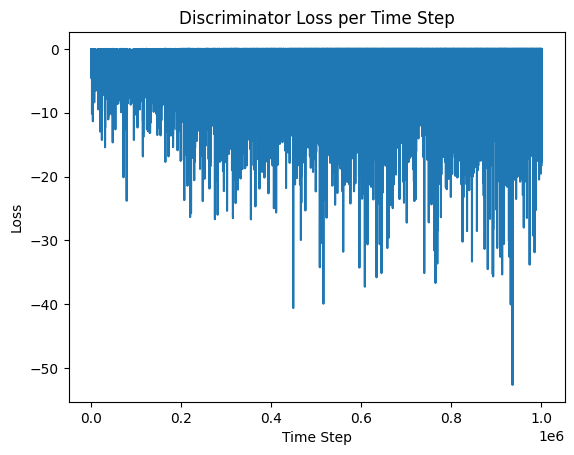

In [4]:
import matplotlib.pyplot as plt

plt.plot(all_loss)
plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.title('Discriminator Loss per Time Step')
plt.show()

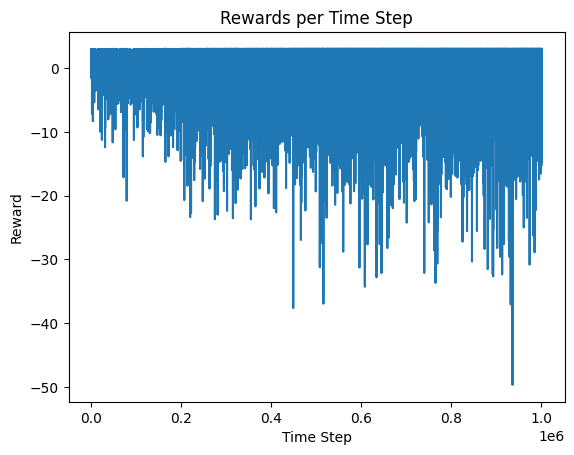

In [5]:
import matplotlib.pyplot as plt

plt.plot(all_rewards)
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Rewards per Time Step')
plt.show()

In [8]:
# Visualize model running

model = PPO.load("diayn_ppo_cheetah_big3")
env = gym.make("HalfCheetah-v4", render_mode="human")
env = CustomEnvWrapper(env)

obs, _ = env.reset()
print(env.cur_skill())
# env.skill = env.skill_dist.sample() # Replace <desired_skill> with the skill you want to use
rewards_all = []
for i in range(10000):
    if (i % 1000 == 0):
        obs, _ = env.reset()
    action, _states = model.predict(obs)
    obs, rewards, dones, info, _ = env.step(action)
    rewards_all.append(rewards)
    # env.render()

    if dones:
        break  

16


KeyboardInterrupt: 

In [13]:
# Record trajectories
num_eval_episodes = NUM_SKILLS

model = PPO.load("diayn_ppo_cheetah_big3")

env = gym.make("HalfCheetah-v4", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="cheetah-diayn-big3-embed", name_prefix="eval",
                  episode_trigger=lambda x: True)
# env = RecordEpisodeStatistics(env)
env = CustomEnvWrapper(env)

for episode_num in range(env.skill_dist.num_skills):
    obs, info = env.reset()
    env.skill = torch.tensor(episode_num)
    print(env.set_skill(episode_num))

    episode_over = False
    while not episode_over:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-0.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-0.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-1.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-1.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-2.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-2.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-3.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-3.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-4.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-4.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-5.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-5.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-6.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-6.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-7.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-7.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-8.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-8.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-9.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-9.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-10.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-10.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-11.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-11.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-12.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-12.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-13.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-13.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-14.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-14.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-15.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-15.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-16.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-16.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-17.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-17.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-18.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-18.mp4
None
Moviepy - Building video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-19.mp4.
Moviepy - Writing video /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/cc/Documents/Stanford/Class Materials/Spring 2024/cs234/cs234/cheetah-diayn-big3-embed/eval-episode-19.mp4


/opt/homebrew/Caskroom/miniconda/base/envs/cs234_clean/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.time_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_queue` for environment variables or `env.get_wrapper_attr('time_queue')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'HalfCheetahEnv' object has no attribute 'time_queue'

In [4]:
# Graph trajectories

model = PPO.load("diayn_ppo_cheetah_big3")

env = gym.make("HalfCheetah-v4", exclude_current_positions_from_observation=False) 
env = CustomEnvWrapper(env)

num_eval_episodes = 100

trajectories_x = []
trajectories_z = []

all_obs = []

skills = []

"""
I was being STUPID asf here
was cutting off the skill here but not the position
"""

for skill in tqdm(range(NUM_SKILLS)):
    for episode_num in range(num_eval_episodes):
        trajectory_x = []
        trajectory_z = []
        obs_ = []
        obs, info = env.reset()
        env.skill_i = torch.tensor(skill)
        env.skill = env.skill_dist.embed(env.skill_i)

        # trajectory_x.append(obs[:-1])
        # trajectory_z.append(obs[0])
        # append without the skill embedding
        obs_.append(obs[:-10])
        # get rid of embedding dimensions
        obs = np.delete(obs, -11)
        skills.append(env.cur_skill())

        # print(env.cur_skill())

        episode_over = False
        while not episode_over:
            action, _states = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            # trajectory_x.append(obs[:-1])
            # trajectory_z.append(obs[0])
            obs_.append(obs[:-10])
            obs = np.delete(obs, -11)

            episode_over = terminated or truncated

        # trajectories_x.append(trajectory_x)
        # trajectories_z.append(trajectory_z)
        all_obs.append(obs_)
    
env.close()

100%|██████████| 20/20 [20:15<00:00, 60.77s/it]


In [54]:
import numpy as np

mean_list = []
variance_list = []

for skill in range(NUM_SKILLS):
    skill_obs = []
    for j in range(num_eval_episodes):
        skill_obs += all_obs[skill * num_eval_episodes + j]

    skill_obs = np.array(skill_obs)
    skill_mean = np.mean(skill_obs, axis=0)
    skill_var = np.var(skill_obs, axis=0)

    mean_list.append(skill_mean)
    variance_list.append(skill_var)

mean_list = np.array(mean_list)
variance_list = np.array(variance_list)

[7.26428283e-02 2.35977421e-05 3.98971316e-02 1.15286620e-06
 2.32352392e-06 2.35530181e-06 6.32469180e-06 1.66798989e-06
 1.29195921e-06 6.03392354e-05 2.17638733e-06 3.83088351e-05
 9.75353052e-06 1.17860832e-05 1.92852010e-05 3.19726574e-05
 1.15252571e-05 2.28312527e-05]


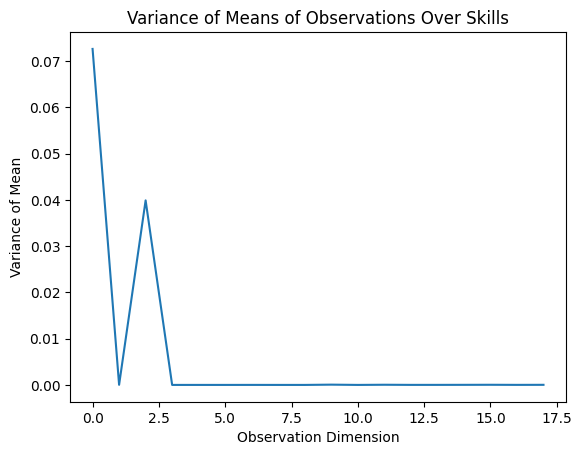

In [55]:
mean_list_ = np.var(mean_list, axis=0)
print(mean_list_)
plt.xlabel('Observation Dimension')
plt.ylabel('Variance of Mean')
plt.title('Variance of Means of Observations Over Skills')
plt.plot(mean_list_)

[2.34515675e+00 2.08470263e-06 6.93343662e-01 3.15875413e-07
 1.63214837e-07 1.29041492e-07 1.61051279e-06 6.06782910e-07
 1.97913518e-07 1.17579240e-04 1.03838940e-04 1.32545116e-03
 1.51680520e-01 1.74539695e-01 1.75122441e-01 1.76943908e-01
 2.47890555e-01 7.35669454e-02]


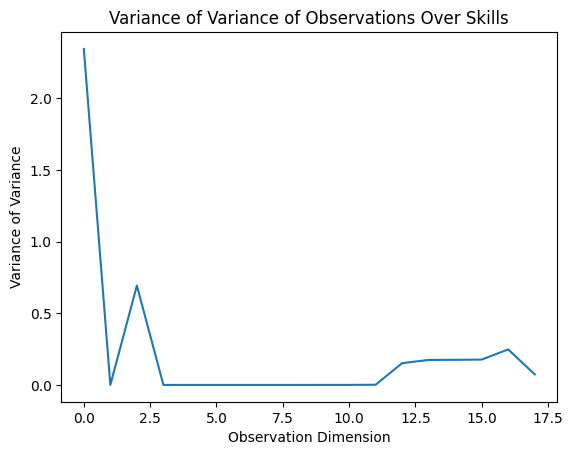

In [56]:
variance_list_ = np.var(variance_list, axis=0)
print(variance_list_)
plt.xlabel('Observation Dimension')
plt.ylabel('Variance of Variance')
plt.title('Variance of Variance of Observations Over Skills')
plt.plot(variance_list_)

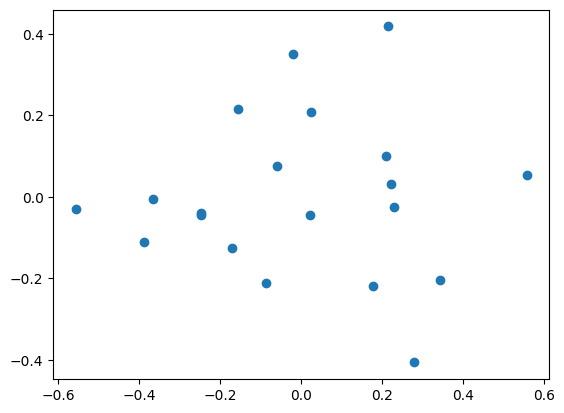

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out = pca.fit_transform(mean_list)
plt.scatter(out[:, 0], out[:, 1])
plt.show()

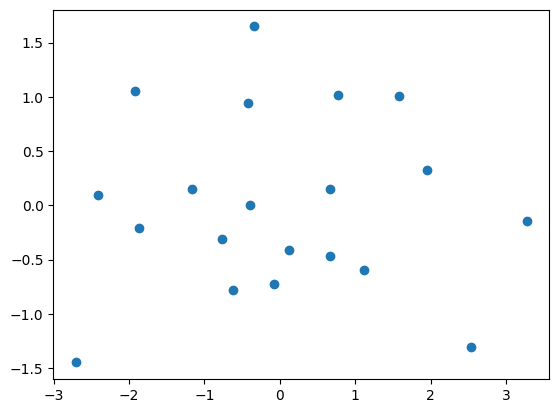

In [58]:
ca = PCA(n_components=2)
out = pca.fit_transform(variance_list)
plt.scatter(out[:, 0], out[:, 1])
plt.show()

In [29]:
import numpy as np

mean_list = []
variance_list = []

for skill in range(NUM_SKILLS):
    skill_obs = []
    for j in range(num_eval_episodes):
        skill_obs += all_obs[skill * num_eval_episodes + j]

    skill_obs = np.array(skill_obs)
    

mean_list = np.array(mean_list)
variance_list = np.array(variance_list)

20 100 2000


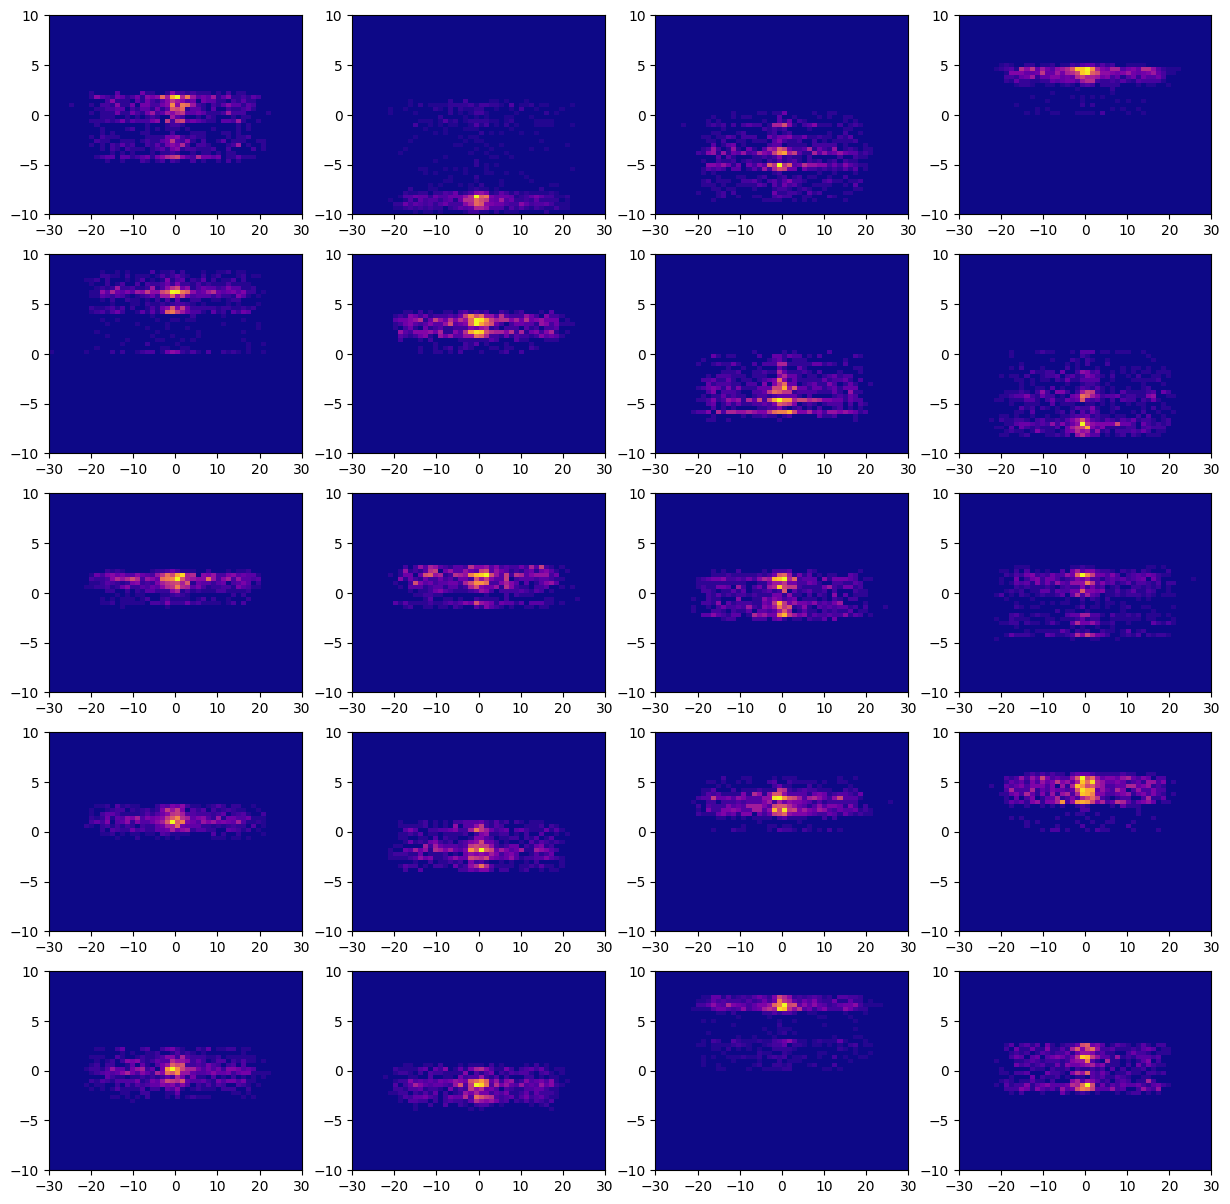

In [59]:
# z = [e[0].item() for e in obs_ for obs_ in all_obs]
# x = [e[-1].item() for e in obs_ for obs_ in all_obs

import math 

grid_size = int(np.ceil(np.sqrt(NUM_SKILLS)))

fig, axs = plt.subplots(5, 4, figsize=(15, 15))

j = 0
# for i in range(sk)

print(NUM_SKILLS, num_eval_episodes, len(all_obs))

for i in range(NUM_SKILLS):
    ax = axs[i // 4, i % 4]
    ax.set_xlim(-30, 30)
    ax.set_ylim(-10, 10)
    for j in range(num_eval_episodes):
        z = [e[0].item() for e in all_obs[i * num_eval_episodes + j]]
        x = [e[-1].item() for e in all_obs[i * num_eval_episodes + j]]
        edges0 = np.linspace(-30, 30, 51)
        edges1 = np.linspace(-10, 10, 51)
        bins = np.array([edges0, edges1])
        ax.hist2d(x, z, bins=bins, cmap='plasma', cmin=-30, cmax=30)

plt.show()

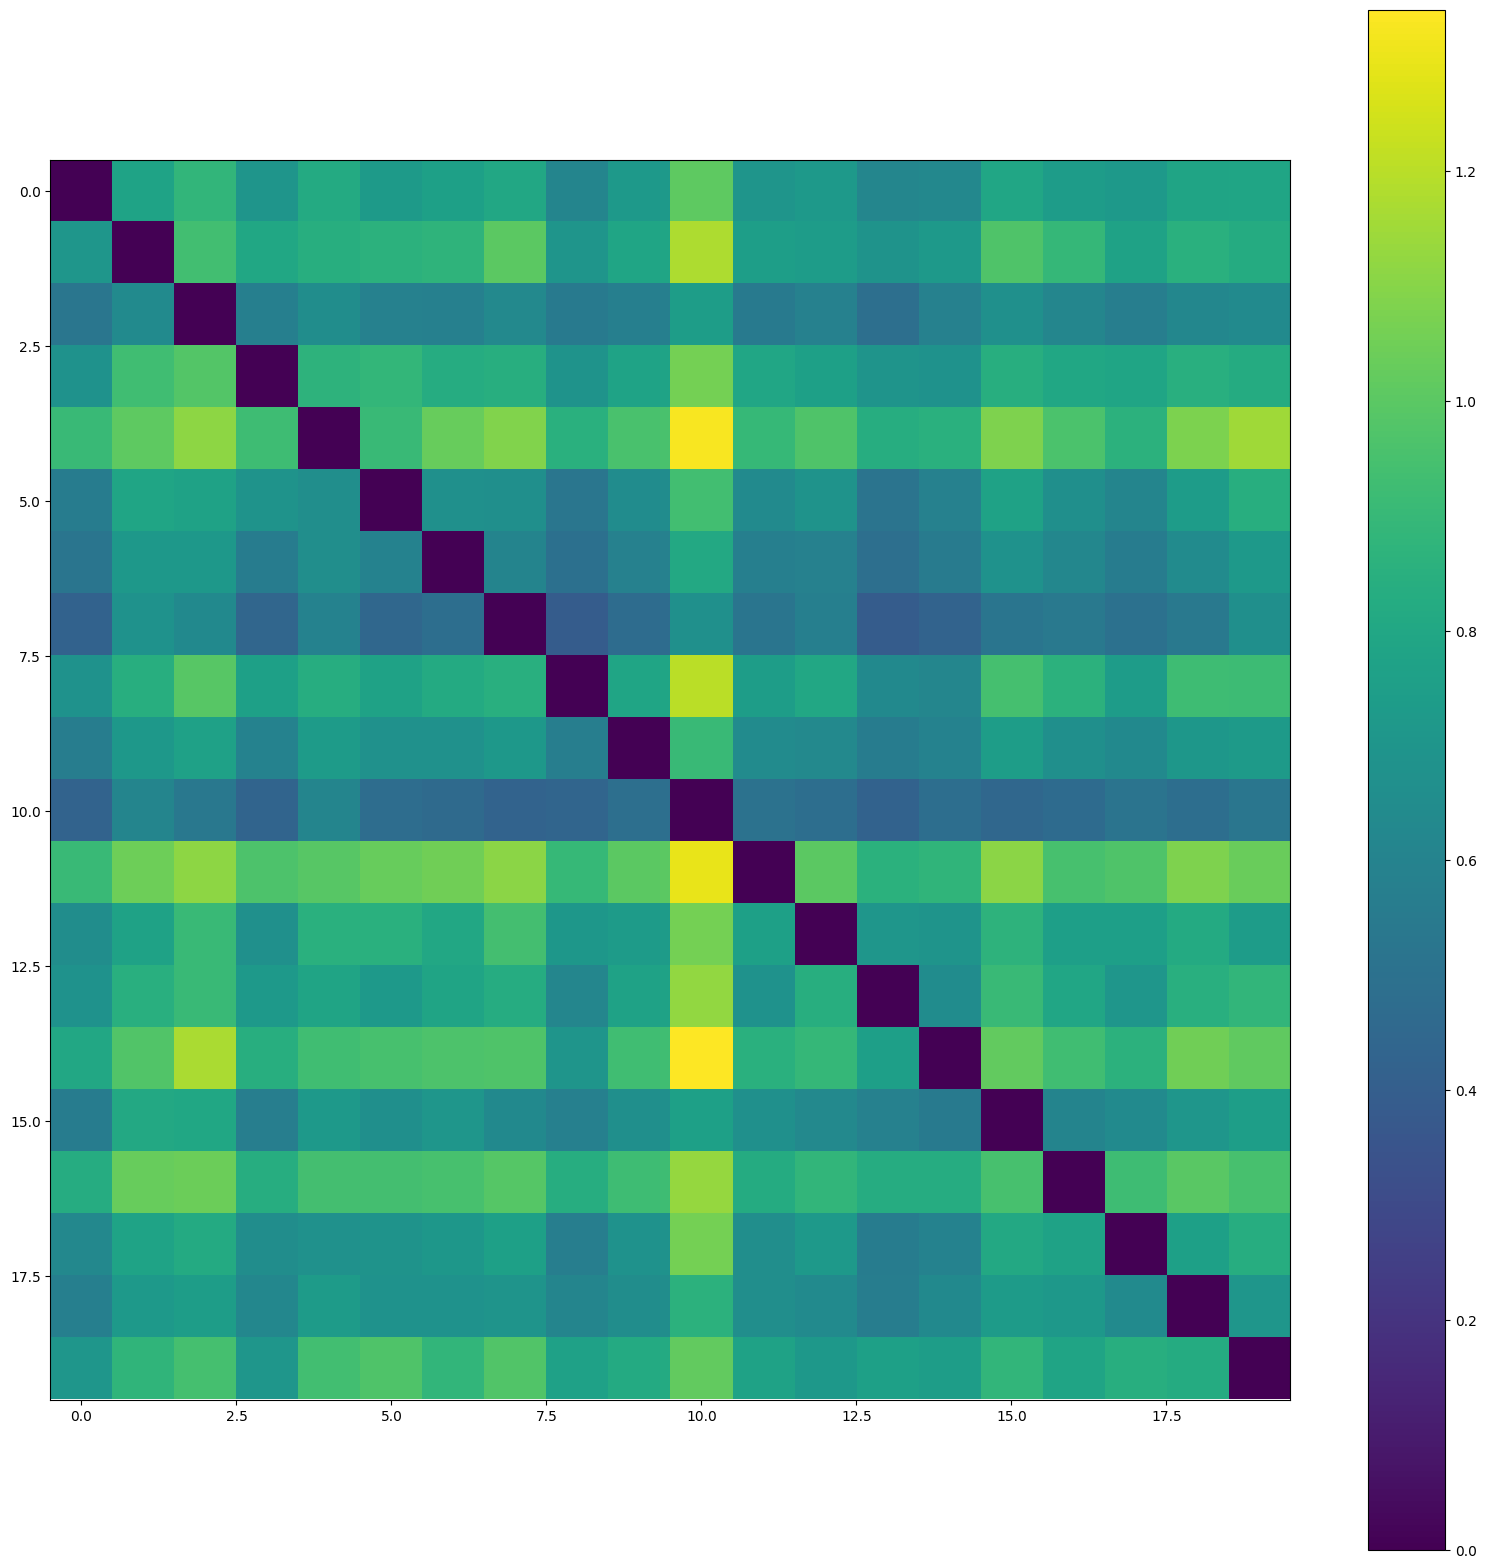

In [63]:
# fig, axs = plt.subplots(20,, figsize=(15, 15))

j = 0
# for i in range(sk)

# print(NUM_SKILLS, num_eval_episodes, len(all_obs))

fig, ax = plt.subplots(figsize=(20, 20))

kl_mat = np.zeros((NUM_SKILLS, NUM_SKILLS))

for i in range(NUM_SKILLS):
    zi = []
    xi = []
    for k in range(num_eval_episodes):
        zi += [e[0].item() for e in all_obs[i * num_eval_episodes + k]]
        xi += [e[-1].item() for e in all_obs[i * num_eval_episodes + k]]
    for j in range(NUM_SKILLS):
        z = []
        x = []
        for k in range(num_eval_episodes):
            z += [e[0].item() for e in all_obs[j * num_eval_episodes + k]]
            x += [e[-1].item() for e in all_obs[j * num_eval_episodes + k]]

        bin_edges_z = np.histogram_bin_edges(np.concatenate((z, zi)), bins='auto')
        bin_edges_x = np.histogram_bin_edges(np.concatenate((x, xi)), bins='auto')

        j_hist, _, _ = np.histogram2d(x, z, bins=[bin_edges_x, bin_edges_z], density=True)
        i_hist, _, _ = np.histogram2d(xi, zi, bins=[bin_edges_x, bin_edges_z], density=True)

        epsilon = 1e-10
        j_hist += epsilon
        i_hist += epsilon

        j_prob = j_hist / np.sum(j_hist)
        i_prob = i_hist / np.sum(i_hist)

        kl = np.sum(i_prob * np.log(i_prob / j_prob))

        kl_mat[i, j] = kl

cax = ax.imshow(kl_mat)
fig.colorbar(cax, ax=ax)

# for i in range(NUM_SKILLS):
#     for j in range(NUM_SKILLS):
#         text = ax.text(j, i, kl_mat[i, j], ha="center", va="center", color="w")

plt.show()

In [80]:
all_obs_flat = [obs for obs_ in all_obs for obs in obs_]
all_obs_flat_2d = [np.reshape(obs, (1, -1)) for obs in all_obs_flat]
# pca = PCA(n_components=2).fit(all_obs_flat)
from sklearn.manifold import TSNE
all_obs_flat_ = np.concatenate(all_obs_flat_2d)
print(all_obs_flat_.shape)
pca = TSNE(n_components=2).fit(all_obs_flat_)

for i in range(NUM_SKILLS):
    all_for_skill = []
    for j in range(num_eval_episodes):
        all_for_skill += all_obs[i * num_eval_episodes + j]
    print(len(all_for_skill))
    # pca = PCA(n_components=2)
    out = pca.transform(all_for_skill)
    plt.scatter(out[:, 0], out[:, 1], s=3, alpha=0.1)
    plt.show()

# plt.show()

(2002000, 18)
